In [2]:
import sys
sys.path.append('..')
from src.evo_eq_model import *

In [3]:
import random
import numpy.random as rnd
# import networkx as nx
# from anytree import Node
from tqdm import tqdm
import numpy as np
import os
import sys

if(sys.version_info[1]<= 7):
    import pickle5 as pickle
else:
    import pickle

import pandas as pd
import scipy.interpolate as spi
import scipy.optimize as so

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl

from matplotlib.ticker import FuncFormatter

fmt = lambda x, pos: '{:.1f}'.format(x)
from numba import jit

#matplotlib.use('TkAgg')
from matplotlib.lines import Line2D
plt.rc('mathtext', default='regular')
plt.rc('lines', linewidth=3.0)
plt.rcParams['xtick.labelsize']=30
plt.rcParams['ytick.labelsize']=30
plt.rcParams['axes.labelsize']=35
plt.rcParams['legend.fontsize']= 35
plt.rcParams['figure.figsize'] = (20, 10)
plt.rcParams['image.cmap']='coolwarm'
plt.rcParams['axes.titlesize'] = 40
plt.rcParams['figure.titlesize'] = 40
#set legend titlesize to 40
plt.rcParams['legend.title_fontsize'] = 40

In [4]:
def model(X, t, R0, kappa):
    x = X[0]
    y = X[1]
    z = X[2]
    dxdt = - R0/(1+kappa * y) *x * y
    dydt =  R0/(1+kappa* y) * x * y - y
    dzdt = y
    return [dxdt, dydt, dzdt]

def model_w_params(R0, N, k): 
    def model(y,t):
        S = y[0]
        I = y[1]
        R0_eff = R0/(1+k*I/(N))
        dSdt = - R0_eff * S*I/N 
        dIdt =  R0_eff * S*I/N -I
        return [dSdt,dIdt]
    return model

@jit(nopython=True)    
def find_t_intersection(f,g, t):
    #print(np.sign(f - g))
    idx = np.argwhere(np.diff(np.sign(f - g))).flatten()
    #print(idx)
    if len(idx)>0:
        return t[idx[0]]
    else:
        return np.inf

@jit(nopython=True)    
def find_ind_intersection(f,g):
    #print(np.sign(f - g))
    idx = np.argwhere(np.diff(np.sign(f - g))).flatten()
    #print(idx)
    if len(idx)>0:
        return idx[0]
    else:
        return np.inf

@jit(nopython=True)
def get_p_surv_inv_int(fit, dt,reg= 1e-1):
    L = len(fit)
    pi_ext_ode_hand_inv_t = np.zeros(L)
    pi_ext_ode_hand_inv_t[-1] = np.minimum(1/(1+fit[-1]),1-reg)
    for i in range(L-1):
        pi_ext= pi_ext_ode_hand_inv_t[L-1-i]
        pi_ext_ode_hand_inv_t[L-2-i] = pi_ext -dt * (1-pi_ext)*(-1+pi_ext*(1+fit[L-2-i]))
    p_surv = 1-pi_ext_ode_hand_inv_t
    return p_surv

def find_x_inf(R0,k):
    if k>0:
        c = (R0-k+R0*k)/(k*(R0-k))
        rho = 1/(R0/k)
        y_x = lambda x: c*x**rho + x/(rho-1) - 1/k

        roots = so.fsolve(y_x, 0)
        return roots[0]
    else:
        return np.real(-1/R0*sps.lambertw(-R0*np.exp(-R0)))
    
def integrate_trajectory(R0,kappa,N, I0=10,Nsteps = 10000):
    S0 = N-I0
    y0 = [S0,I0]
    x_inf = find_x_inf(R0,kappa)
    
    t_end = 1.5*np.log(N)* (1/(R0-1) + 1/(1-R0*x_inf))
    ts = np.linspace(0, t_end,Nsteps)
    dt = ts[1]-ts[0]
    solution  = odeint(model_w_params(R0,N,kappa),y0,ts).T
    x,y= solution
    tp = ts[np.argmax(y)]


    return ts, solution

In [5]:
home = os.path.expanduser("~")
project_path =  os.path.relpath("..")
if project_path not in sys.path:
    sys.path.append(project_path)

sys.path.insert(1, project_path)
output_folder= project_path+'/outputs/'

In [121]:
fitness_france.date.max(),fitness_france.day_diff.max()

('2022-12-31', 1095)

In [122]:
last_date = '2022-12-31'
covid_data = pd.read_csv(os.getcwd()+'/data/covid_data.csv')
covid_data_World  = covid_data[covid_data['location'] == 'World'].query(f'date < "{last_date}"')

syn_clade_stats_SARS_CoV_2_folder = os.getcwd()+'/data/syn_clade_stats_SARS_CoV_2/'
assert os.path.exists(syn_clade_stats_SARS_CoV_2_folder)

syn_clade_statistics_SARS_CoV_2_World = pd.read_csv(syn_clade_stats_SARS_CoV_2_folder+'/clade_statistics.tsv', sep = '\t')
syn_clade_statistics_SARS_CoV_2_World = syn_clade_statistics_SARS_CoV_2_World.query(f'Time < "{last_date}"')

In [123]:
nonsyn_all_clade_stats_SARS_CoV_2_folder = os.getcwd()+'/data/nonsyn_all_clade_stats_SARS_CoV_2/'

assert os.path.exists(nonsyn_all_clade_stats_SARS_CoV_2_folder)

nonsyn_all_clade_statistics_SARS_CoV_2_World = pd.read_csv(nonsyn_all_clade_stats_SARS_CoV_2_folder+'/clade_statistics.tsv', sep = '\t')
nonsyn_all_clade_statistics_SARS_CoV_2_World = nonsyn_all_clade_statistics_SARS_CoV_2_World.query(f'Time < "{last_date}"')


In [124]:
nonsyn_S_clade_stats_SARS_CoV_2_folder = os.getcwd()+'/data/nonsyn_S_clade_stats_SARS_CoV_2/'
assert os.path.exists(nonsyn_S_clade_stats_SARS_CoV_2_folder)
nonsyn_S_clade_statistics_SARS_CoV_2_World = pd.read_csv(nonsyn_S_clade_stats_SARS_CoV_2_folder+'/clade_statistics.tsv', sep = '\t')
nonsyn_S_clade_statistics_SARS_CoV_2_World = nonsyn_S_clade_statistics_SARS_CoV_2_World.query(f'Time < "{last_date}"')

In [125]:
nonsyn_RBD_clade_stats_SARS_CoV_2_folder = os.getcwd()+'/data/RBD_clade_stats_SARS_CoV_2/'

assert os.path.exists(nonsyn_RBD_clade_stats_SARS_CoV_2_folder)

nonsyn_RBD_clade_statistics_SARS_CoV_2_World = pd.read_csv(nonsyn_RBD_clade_stats_SARS_CoV_2_folder+'/clade_statistics.tsv', sep = '\t')

nonsyn_RBD_clade_statistics_SARS_CoV_2_World = nonsyn_RBD_clade_statistics_SARS_CoV_2_World.query(f'Time < "{last_date}"')

In [126]:
nonsyn_RBD_clade_statistics_SARS_CoV_2_World.query('Clade == 100')

Clade        Time  Sublineage_Freq    Clade_Freq
15739    100  2021-11-14     4.214165e-22  4.214165e-22
15740    100  2021-11-15     1.723293e-20  1.723293e-20
15741    100  2021-11-16     5.417796e-19  5.417796e-19
15742    100  2021-11-17     1.326325e-17  1.326325e-17
15743    100  2021-11-18     2.560061e-16  2.560061e-16
...      ...         ...              ...           ...
15819    100  2022-02-02     5.089787e-17  5.089787e-17
15820    100  2022-02-03     2.639602e-18  2.639602e-18
15821    100  2022-02-04     1.080454e-19  1.080454e-19
15822    100  2022-02-05     3.447224e-21  3.447224e-21
15823    100  2022-02-06     8.463830e-23  8.463830e-23

[85 rows x 4 columns]

In [127]:
#create a dataframe with columns, clade, time, max_freq, orig_time
syn_clade_stats = pd.DataFrame(columns = ['Clade','Max_Freq','Orig_Time'])
syn_clade_stats['Clade'] = syn_clade_statistics_SARS_CoV_2_World['Clade']
syn_clade_stats['Max_Freq'] = syn_clade_statistics_SARS_CoV_2_World.groupby('Clade')['Sublineage_Freq'].transform('max')
syn_clade_stats['Orig_Time'] = syn_clade_statistics_SARS_CoV_2_World.groupby('Clade')['Time'].transform('min')
syn_clade_stats = syn_clade_stats.drop_duplicates()

In [128]:
nonsyn_all_clade_stats = pd.DataFrame(columns = ['Clade','Max_Freq','Orig_Time'])
nonsyn_all_clade_stats['Clade'] = nonsyn_all_clade_statistics_SARS_CoV_2_World['Clade']
nonsyn_all_clade_stats['Max_Freq'] = nonsyn_all_clade_statistics_SARS_CoV_2_World.groupby('Clade')['Sublineage_Freq'].transform('max')
nonsyn_all_clade_stats['Orig_Time'] = nonsyn_all_clade_statistics_SARS_CoV_2_World.groupby('Clade')['Time'].transform('min')
nonsyn_all_clade_stats = nonsyn_all_clade_stats.drop_duplicates()

nonsyn_S_clade_stats = pd.DataFrame(columns = ['Clade','Max_Freq','Orig_Time'])
nonsyn_S_clade_stats['Clade'] = nonsyn_S_clade_statistics_SARS_CoV_2_World['Clade']
nonsyn_S_clade_stats['Max_Freq'] = nonsyn_S_clade_statistics_SARS_CoV_2_World.groupby('Clade')['Sublineage_Freq'].transform('max')
nonsyn_S_clade_stats['Orig_Time'] = nonsyn_S_clade_statistics_SARS_CoV_2_World.groupby('Clade')['Time'].transform('min')
nonsyn_S_clade_stats = nonsyn_S_clade_stats.drop_duplicates()

nonsyn_RBD_clade_stats = pd.DataFrame(columns = ['Clade','Max_Freq','Orig_Time'])
nonsyn_RBD_clade_stats['Clade'] = nonsyn_RBD_clade_statistics_SARS_CoV_2_World['Clade']
nonsyn_RBD_clade_stats['Max_Freq'] = nonsyn_RBD_clade_statistics_SARS_CoV_2_World.groupby('Clade')['Sublineage_Freq'].transform('max')
nonsyn_RBD_clade_stats['Orig_Time'] = nonsyn_RBD_clade_statistics_SARS_CoV_2_World.groupby('Clade')['Time'].transform('min')
nonsyn_RBD_clade_stats = nonsyn_RBD_clade_stats.drop_duplicates()



In [129]:
sns.set_style("whitegrid")

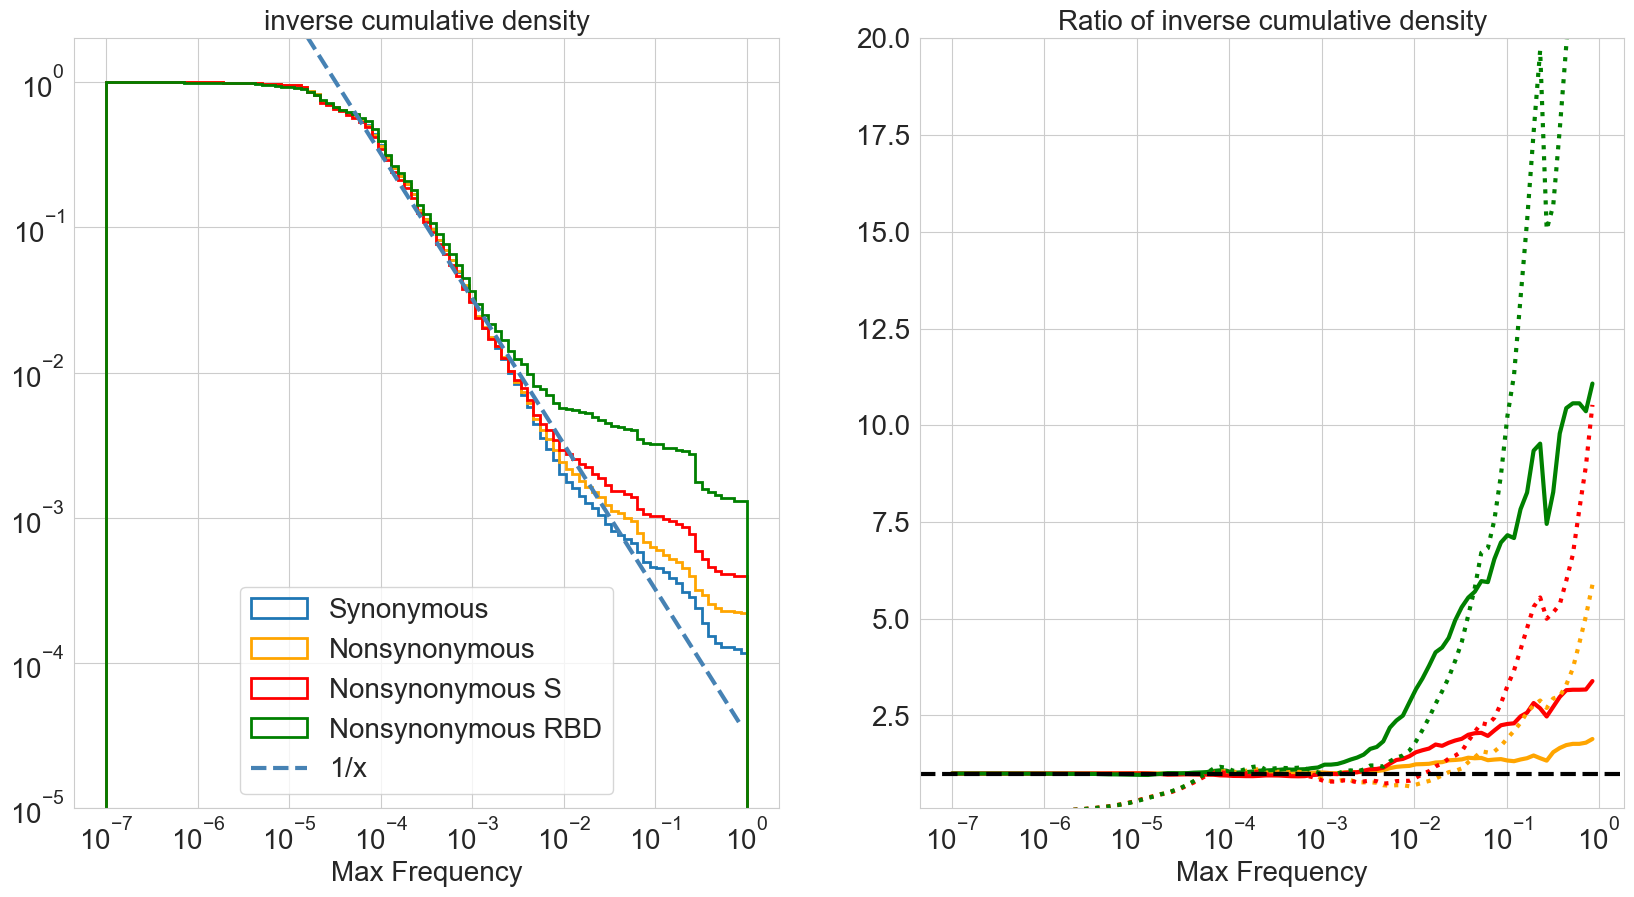

In [130]:
fig, ax = plt.subplots(1,2,figsize = (20,10))
syn_h,syn_b,syn_p = ax[0].hist(syn_clade_stats['Max_Freq'], bins = np.logspace(-7,0,100), density = True, alpha = 1, lw=2, label = 'Synonymous',cumulative=-1, histtype = 'step')

nonsyn_all_h,nonsyn_all_b,nonsyn_all_p = ax[0].hist(nonsyn_all_clade_stats['Max_Freq'], bins = np.logspace(-7,0,100), density = True, alpha = 1, lw=2, label = 'Nonsynonymous',cumulative=-1, histtype = 'step',color='orange')

nonsyn_S_h,nonsyn_S_b,nonsyn_S_p = ax[0].hist(nonsyn_S_clade_stats['Max_Freq'], bins = np.logspace(-7,0,100), density = True, alpha = 1, lw=2, label = 'Nonsynonymous S',cumulative=-1, histtype = 'step',color='red')

nonsyn_RBD_h,nonsyn_RBD_b,nonsyn_RBD_p = ax[0].hist(nonsyn_RBD_clade_stats['Max_Freq'], bins = np.logspace(-7,0,100), density = True, alpha = 1, lw=2, label = 'Nonsynonymous RBD',cumulative=-1, histtype = 'step',color='green')

#fit syn with b/(1+a x)
fitfunc = lambda x,a,b: b/(1+a*x)
popt, pcov = so.curve_fit(fitfunc, syn_b[50:-1],syn_h[50:])
a,b = popt
one_over_x_fit = fitfunc(syn_b[:-1],a,b)
ax[0].plot(syn_b[:-1],one_over_x_fit, label = r'$1/x$',color='steelblue',linestyle='--')
ax[0].legend(loc='best',fontsize=20)
ax[1].plot(syn_b[:-1],nonsyn_all_h/syn_h, label = 'Synonymous',color='orange')
ax[1].plot(syn_b[:-1],nonsyn_S_h/syn_h, label = 'Nonsynonymous S',color='red')
ax[1].plot(syn_b[:-1],nonsyn_RBD_h/syn_h, label = 'Nonsynonymous RBD',color='green')

ax[1].plot(syn_b[:-1],nonsyn_all_h/one_over_x_fit,color='orange',ls= ':')
ax[1].plot(syn_b[:-1],nonsyn_S_h/one_over_x_fit,color='red',ls= ':')
ax[1].plot(syn_b[:-1],nonsyn_RBD_h/one_over_x_fit,color='green',ls= ':')
ax[1].set_ylim(.1,20)

ax[1].axhline(1,linestyle='--',color='black')

ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_ylim(1e-5,2)

ax[1].set_xscale('log')

ax[0].set_xlabel('Max Frequency',fontsize=20)
ax[0].set_title('inverse cumulative density',fontsize=20)

ax[1].set_xlabel('Max Frequency',fontsize=20)
ax[1].set_title('Ratio of inverse cumulative density',fontsize=20)
for a in ax:
    a.tick_params(axis='both', which='major', labelsize=20)


In [131]:
reference_date = pd.to_datetime('2020-01-01')

syn_clade_stats['day_diff'] = (pd.to_datetime(syn_clade_stats['Orig_Time']) - reference_date).dt.days
nonsyn_all_clade_stats['day_diff'] = (pd.to_datetime(nonsyn_all_clade_stats['Orig_Time']) - reference_date).dt.days
nonsyn_S_clade_stats['day_diff'] = (pd.to_datetime(nonsyn_S_clade_stats['Orig_Time']) - reference_date).dt.days
nonsyn_RBD_clade_stats['day_diff'] = (pd.to_datetime(nonsyn_RBD_clade_stats['Orig_Time']) - reference_date).dt.days

In [132]:
4*(1/2)/1.5

1.3333333333333333

In [133]:
World_cases = 7*covid_data_World['new_cases_smoothed']
World_cases = World_cases[World_cases>0]
World_cases = World_cases[~np.isinf(World_cases)]
World_cases = World_cases[~np.isnan(World_cases)]


covid_data_World['Time_datetime'] = pd.to_datetime(covid_data_World['date'])
covid_data_World['day_diff'] = covid_data_World['Time_datetime']-reference_date

covid_data_World['day_diff'] = covid_data_World['day_diff'].apply(lambda x: x.days)
covid_data_World['weekly_new_cases_smoothed'] = covid_data_World['new_cases_smoothed']*7

(-88.30000000000001, 1150.3, -2211809.2479000003, 46448038.2499)

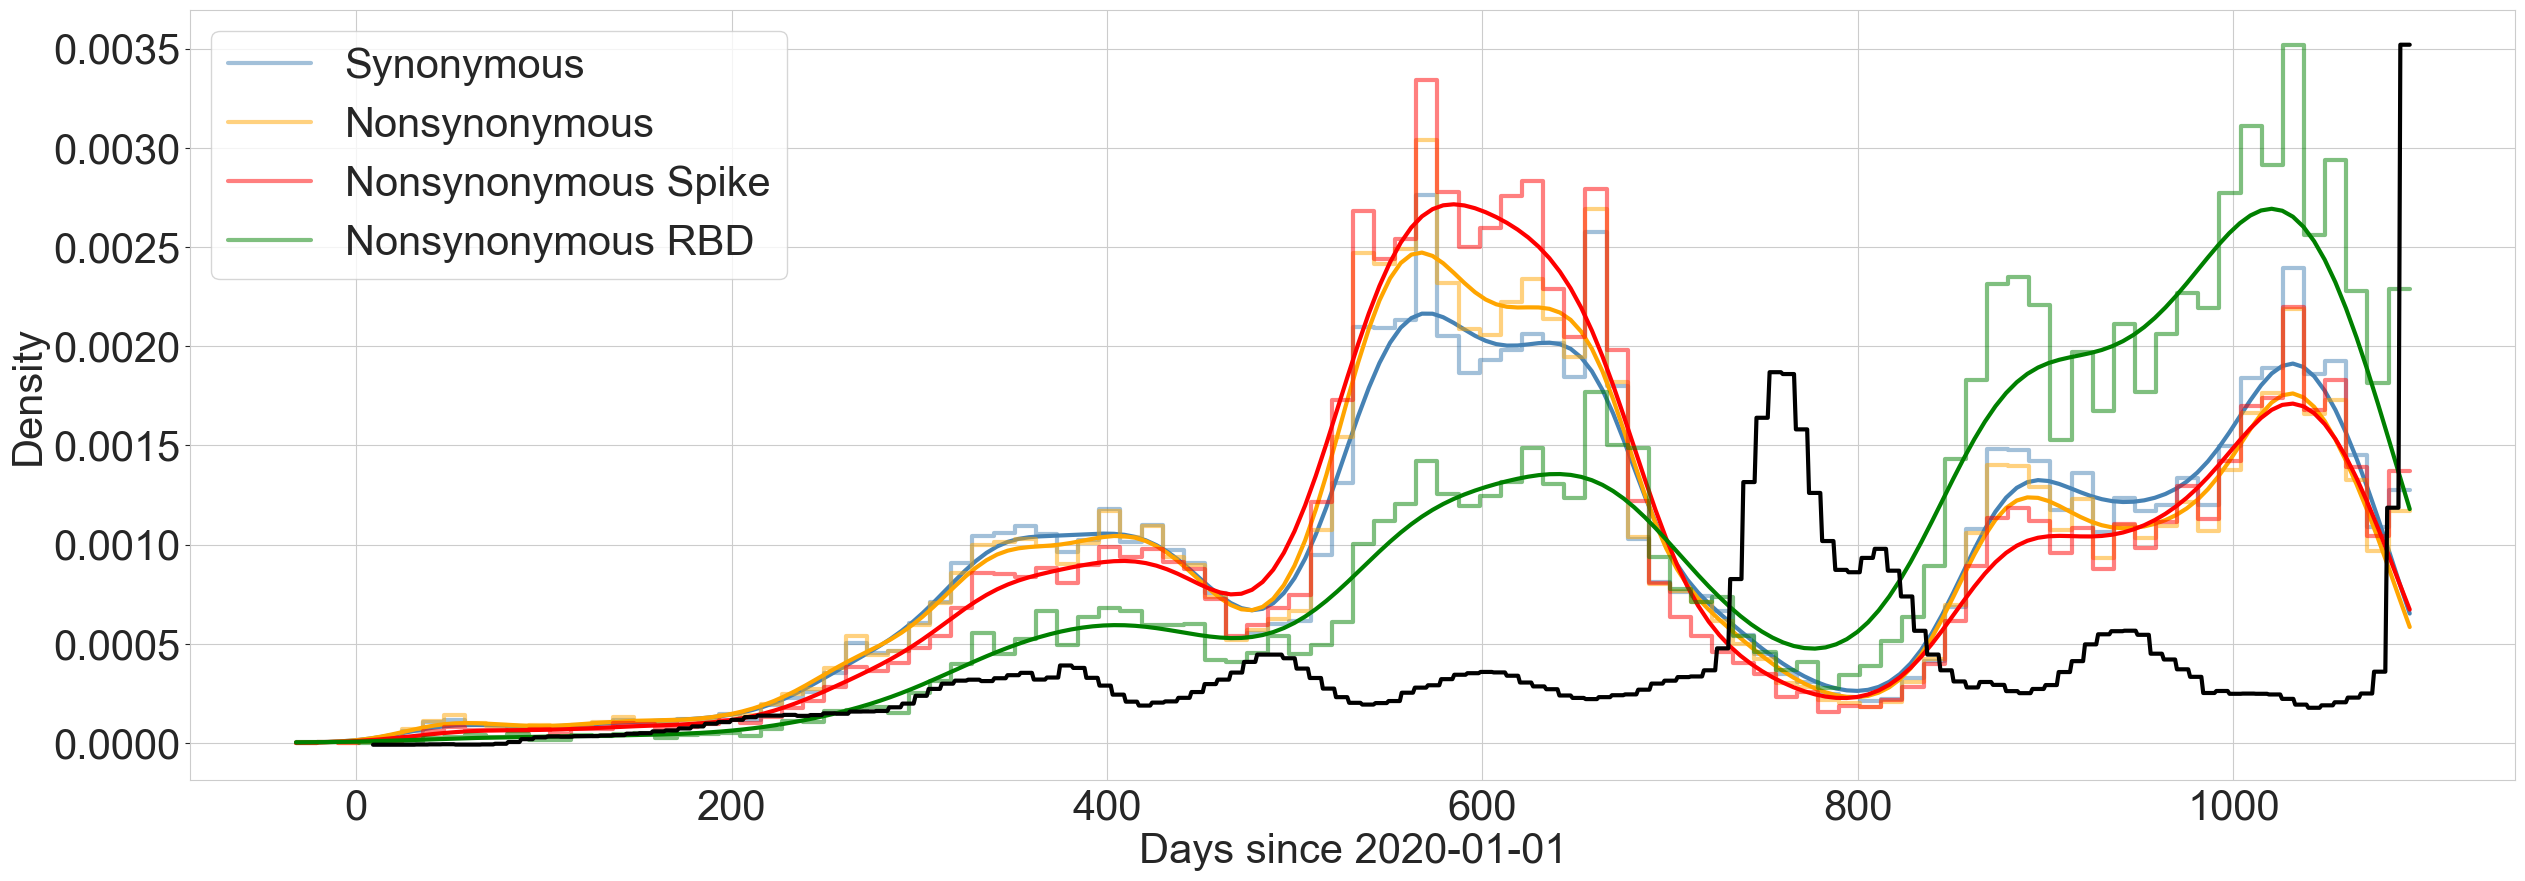

In [134]:
fig,ax = plt.subplots(1,figsize = (30,10))
sns.histplot(syn_clade_stats['day_diff']
             ,bins = 100, label = 'Synonymous',alpha=.5, stat = 'density',color='steelblue',ax=ax,element='step', fill=False,kde=True)

sns.histplot(nonsyn_all_clade_stats['day_diff']
             ,bins = 100, label = 'Nonsynonymous',alpha=.5, stat = 'density',color='orange',ax=ax,element='step', fill=False,kde=True)

sns.histplot(nonsyn_S_clade_stats['day_diff']
             ,bins = 100, label = 'Nonsynonymous Spike',alpha=.5, stat = 'density',color='red',ax=ax,element='step', fill=False,kde=True)

sns.histplot(nonsyn_RBD_clade_stats['day_diff']
                ,bins = 100, label = 'Nonsynonymous RBD',alpha=.5, stat = 'density',color='green',ax=ax,element='step', fill=False,kde=True)

ax.set_ylim(bottom=-(ax.get_ylim()[1])*.05)
tax= ax.twinx()
sns.lineplot(data = covid_data_World, x = 'day_diff', y = 'weekly_new_cases_smoothed', ax = tax ,color='black')

ax.set_xlabel('Days since 2020-01-01',fontsize=30)
ax.set_ylabel('Density',fontsize=30)
tax.set_ylabel('Weekly new cases',fontsize=30)

ax.legend(loc='upper left',fontsize=30)

tax.axis('off')


In [135]:
def fig_x_thresh(x, bins = 100, alpha = .5):
    fig,ax = plt.subplots(1,figsize = (30,10))
    sns.histplot(syn_clade_stats.query(f'Max_Freq >= {x}')['day_diff']
                ,bins = bins, label = 'Synonymous',alpha=alpha, stat = 'density',color='steelblue',ax=ax,element='step', fill=False,kde=True, kde_kws={'bw_adjust':.1})

    sns.histplot(nonsyn_all_clade_stats.query(f'Max_Freq >= {x}')['day_diff']
                ,bins = bins, label = 'Nonsynonymous',alpha=alpha, stat = 'density',color='orange',ax=ax,element='step', fill=False,kde=True, kde_kws={'bw_adjust':.1})

    sns.histplot(nonsyn_S_clade_stats.query(f'Max_Freq >= {x}')['day_diff']
                ,bins = bins, label = 'Nonsynonymous Spike',alpha=alpha, stat = 'density',color='red',ax=ax,element='step', fill=False,kde=True, kde_kws={'bw_adjust':.1})

    sns.histplot(nonsyn_RBD_clade_stats.query(f'Max_Freq >= {x}')['day_diff']
                ,bins = bins, label = 'Nonsynonymous RBD',alpha=alpha, stat = 'density',color='green',ax=ax,element='step', fill=False,kde=True, kde_kws={'bw_adjust':.1})
    
    ax.set_ylim(bottom=-(ax.get_ylim()[1])*.05)
    tax= ax.twinx()
    sns.lineplot(data = covid_data_World, x = 'day_diff', y = 'weekly_new_cases_smoothed', ax = tax ,color='black')



    ax.set_xlabel('Origination time, Days since 2020-01-01',fontsize=30)
    ax.set_ylabel('Density',fontsize=30)
    tax.set_ylabel('Weekly new cases',fontsize=30)

    handles = [Line2D([0], [0], color='steelblue', lw=4, label='Synonymous'),
               Line2D([0], [0], color='orange', lw=4, label='Nonsynonymous, all'),
               Line2D([0], [0], color='red', lw=4, label='Nonsynonymous Spike'),
               Line2D([0], [0], color='black', lw=4, label='Weekly new cases')]
    ax.legend(handles=handles,loc='upper left',fontsize=30)

    tax.axis('off')
    fig.suptitle(f'Frequency threshold: {x}',fontsize=30)

def ax_x_thresh(x, ax, bins = 100, alpha = .5):
    
    sns.histplot(syn_clade_stats.query(f'Max_Freq >= {x}')['day_diff']
                ,bins = bins, label = 'Synonymous',alpha=alpha, stat = 'density',color='steelblue',ax=ax,element='step', fill=False,kde=True, kde_kws={'bw_adjust':.1})

    sns.histplot(nonsyn_all_clade_stats.query(f'Max_Freq >= {x}')['day_diff']
                ,bins = bins, label = 'Nonsynonymous',alpha=alpha, stat = 'density',color='orange',ax=ax,element='step', fill=False,kde=True, kde_kws={'bw_adjust':.1})

    sns.histplot(nonsyn_S_clade_stats.query(f'Max_Freq >= {x}')['day_diff']
                ,bins = bins, label = 'Nonsynonymous Spike',alpha=alpha, stat = 'density',color='red',ax=ax,element='step', fill=False,kde=True, kde_kws={'bw_adjust':.1})

    sns.histplot(nonsyn_RBD_clade_stats.query(f'Max_Freq >= {x}')['day_diff']
                ,bins = bins, label = 'Nonsynonymous RBD',alpha=alpha, stat = 'density',color='green',ax=ax,element='step', fill=False,kde=True, kde_kws={'bw_adjust':.1})
    
    ax.set_ylim(bottom=-(ax.get_ylim()[1])*.05)
    
    ax.set_xlabel('Origination time, Days since 2020-01-01',fontsize=30)
    ax.set_ylabel('Density',fontsize=30)
    tax.set_ylabel('Weekly new cases',fontsize=30)

    handles = [Line2D([0], [0], color='steelblue', lw=4, label='Synonymous'),
               Line2D([0], [0], color='orange', lw=4, label='Nonsynonymous, all'),
               Line2D([0], [0], color='red', lw=4, label='Nonsynonymous Spike'),
               Line2D([0], [0], color='green', lw=4, label='Nonsynonymous RBD')]
               
    ax.legend(handles=handles,loc='upper left',fontsize=30)

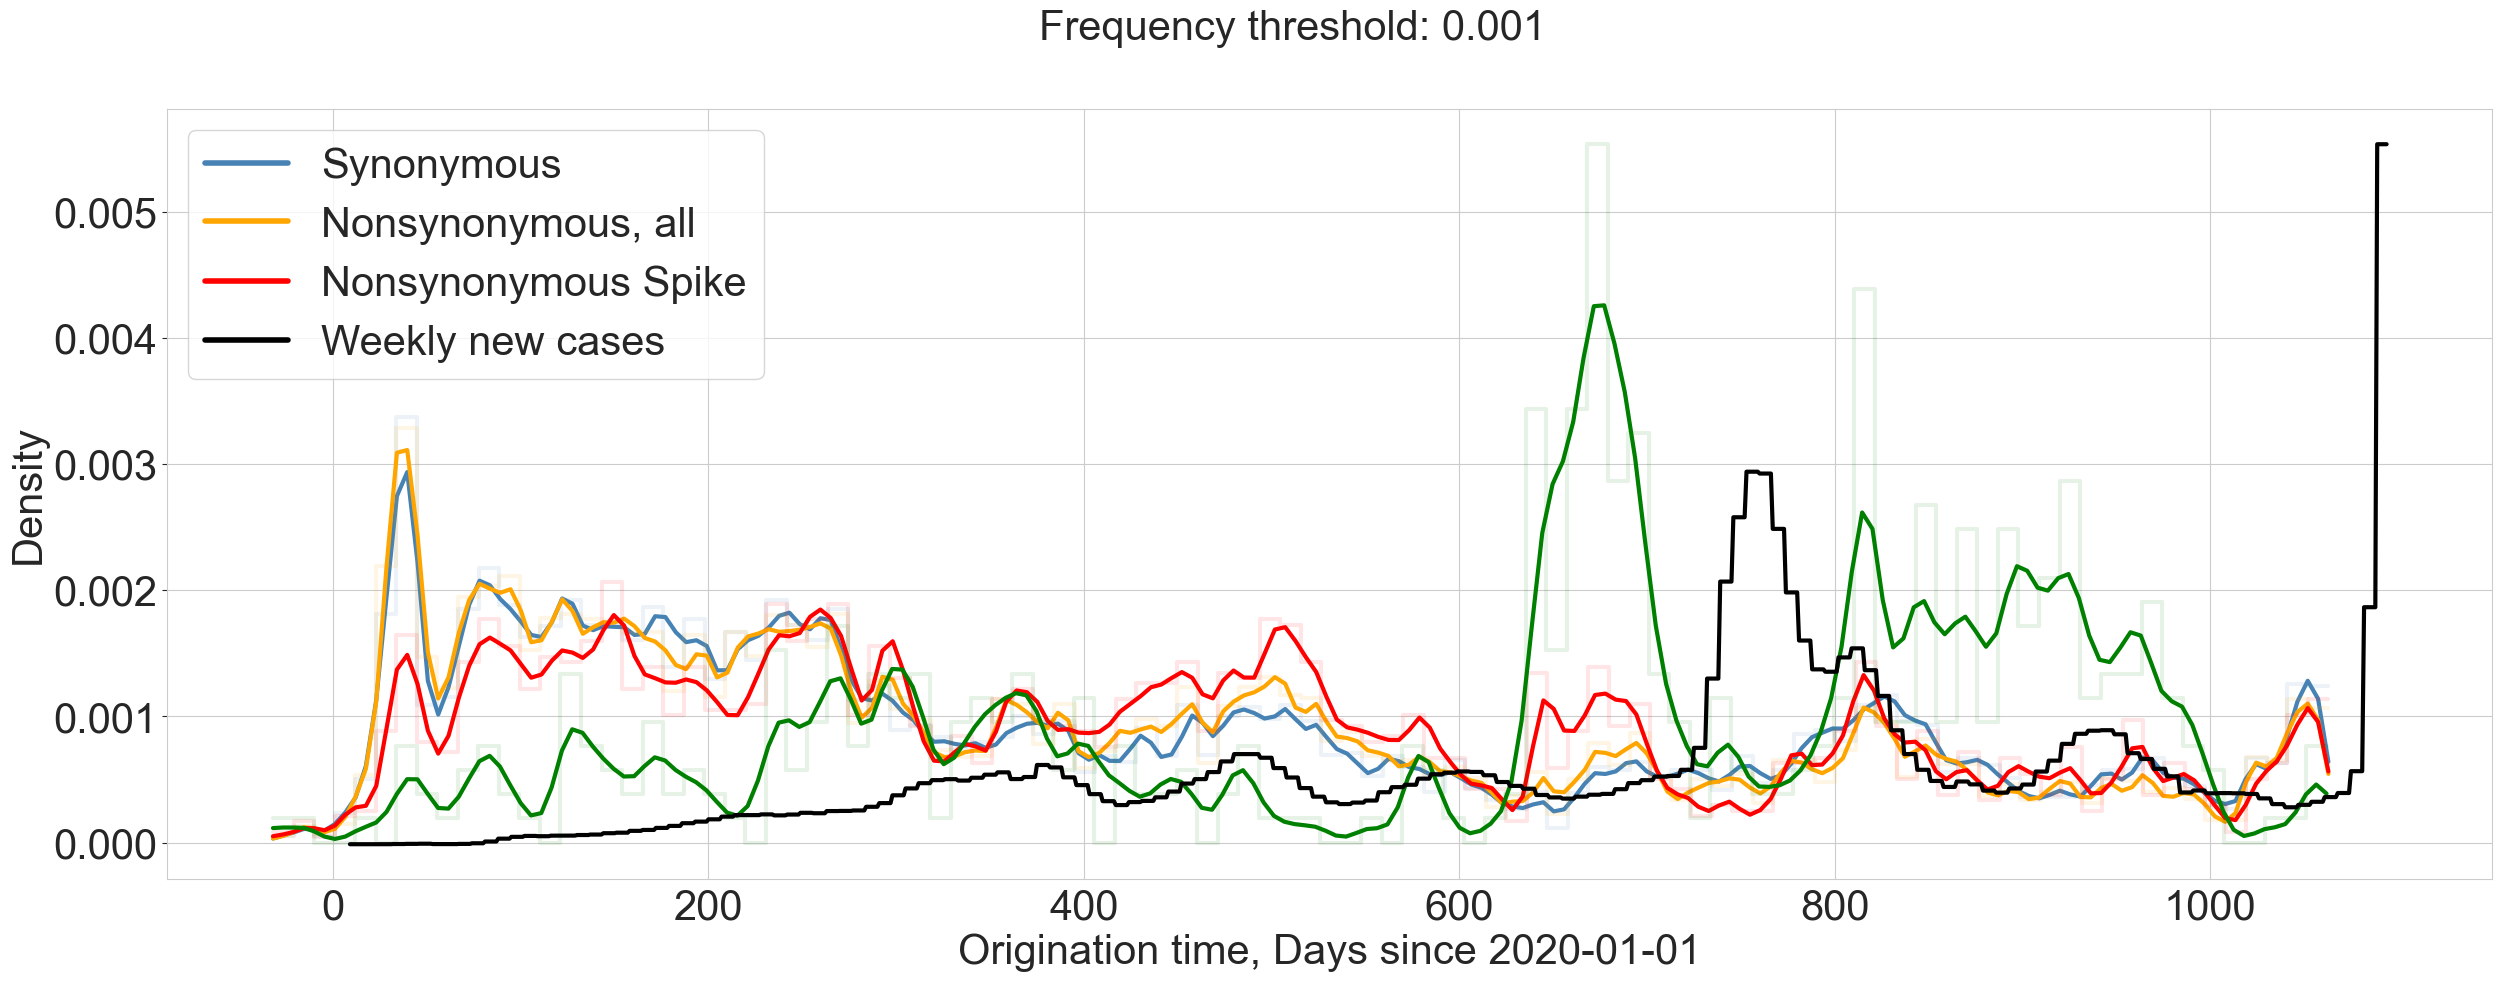

In [136]:
fig_x_thresh(1e-3,alpha=.1)

In [137]:
reference_date = pd.to_datetime('2020-01-01')
syn_clade_statistics_SARS_CoV_2_World['day_diff'] = (pd.to_datetime(syn_clade_statistics_SARS_CoV_2_World['Time']) - reference_date).dt.days
nonsyn_all_clade_statistics_SARS_CoV_2_World['day_diff'] = (pd.to_datetime(nonsyn_all_clade_statistics_SARS_CoV_2_World['Time']) - reference_date).dt.days
nonsyn_S_clade_statistics_SARS_CoV_2_World['day_diff'] = (pd.to_datetime(nonsyn_S_clade_statistics_SARS_CoV_2_World['Time']) - reference_date).dt.days
nonsyn_RBD_clade_statistics_SARS_CoV_2_World['day_diff'] = (pd.to_datetime(nonsyn_RBD_clade_statistics_SARS_CoV_2_World['Time']) - reference_date).dt.days

def initial_growth(clade, df, min_freq = 1e-4):
    # Query once and select only the required columns
    subset = df[df['Clade'] == clade][['day_diff', 'Sublineage_Freq']].values
    subset = subset[subset[:,0].argsort()]
    x = subset[:,0]
    y = subset[:,1]

    x= x[y>min_freq]
    y= y[y>min_freq]
    
    if len(x)>=10:
        g_rate = np.average(np.log(y[1:10] / y[:9]) / (x[1:10] - x[:9]))
    else:
        g_rate = np.average(np.log(y[1:] / y[:-1]) / (x[1:] - x[:-1]))
    # print(g_rate)
    return g_rate


In [138]:
import warnings
warnings.filterwarnings('ignore')

In [139]:
tqdm.pandas()

In [140]:
# df_pot_selection

In [141]:
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)
recompute_S = False
recompute_RBD = False
recompute_syn = False
recompute_all = False
#if nonsyn_all_clade_stats does not exist, create it:
if not os.path.exists('nonsyn_all_clade_stats.feather') or recompute_all:
    nonsyn_all_clade_stats['s'] = nonsyn_all_clade_stats['Clade'].parallel_apply(lambda x: initial_growth(x,nonsyn_all_clade_statistics_SARS_CoV_2_World, min_freq = 1e-3))
    nonsyn_all_clade_stats.to_feather('nonsyn_all_clade_stats.feather')
else:
    print('nonsyn_all_clade_stats.feather exists')
    nonsyn_all_clade_stats = pd.read_feather('nonsyn_all_clade_stats.feather')

if not os.path.exists('nonsyn_S_clade_stats.feather') or recompute_S:
    nonsyn_S_clade_stats['s'] = nonsyn_S_clade_stats['Clade'].parallel_apply(lambda x: initial_growth(x,nonsyn_S_clade_statistics_SARS_CoV_2_World, min_freq = 1e-3))
    nonsyn_S_clade_stats.to_feather('nonsyn_S_clade_stats.feather')
else:
    print('nonsyn_S_clade_stats.feather exists')
    nonsyn_S_clade_stats = pd.read_feather('nonsyn_S_clade_stats.feather')

if not os.path.exists('nonsyn_RBD_clade_stats.feather') or recompute_RBD:
    nonsyn_RBD_clade_stats['s'] = nonsyn_RBD_clade_stats['Clade'].parallel_apply(lambda x: initial_growth(x,nonsyn_RBD_clade_statistics_SARS_CoV_2_World, min_freq = 1e-3))
    nonsyn_RBD_clade_stats.to_feather('nonsyn_RBD_clade_stats.feather')
else:
    print('nonsyn_RBD_clade_stats.feather exists')
    nonsyn_RBD_clade_stats = pd.read_feather('nonsyn_RBD_clade_stats.feather')

if not os.path.exists('syn_clade_stats.feather') or recompute_syn:
    syn_clade_stats['selection'] = syn_clade_stats['Clade'].parallel_apply(lambda x: initial_growth(x,syn_clade_statistics_SARS_CoV_2_World, min_freq = 1e-3))
    syn_clade_stats.to_feather('syn_clade_stats.feather')
else:
    print('syn_clade_stats.feather exists')
    syn_clade_stats = pd.read_feather('syn_clade_stats.feather')

# nonsyn_S_clade_stats['s'] = nonsyn_S_clade_stats['Clade'].progress_apply(lambda x: initial_growth(x,nonsyn_S_clade_statistics_SARS_CoV_2_World))


# nonsyn_RBD_clade_stats['s'] = nonsyn_RBD_clade_stats['Clade'].progress_apply(lambda x: initial_growth(x,nonsyn_RBD_clade_statistics_SARS_CoV_2_World))
# nonsyn_S_clade_stats.to_feather('nonsyn_S_clade_stats.feather')
# nonsyn_RBD_clade_stats.to_feather('nonsyn_RBD_clade_stats.feather')
# # nonsyn_S_clade_stats['s']= nonsyn_S_clade_stats['s'].apply(lambda x: x[0] if x is not None else np.nan)

nonsyn_S_clade_stats['s_w'] = nonsyn_S_clade_stats['s']*7
nonsyn_RBD_clade_stats['s_w'] = nonsyn_RBD_clade_stats['s']*7
syn_clade_stats['s_w'] = syn_clade_stats['selection']*7
nonsyn_all_clade_stats['s_w'] = nonsyn_all_clade_stats['s']*7

INFO: Pandarallel will run on 11 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
nonsyn_all_clade_stats.feather exists
nonsyn_S_clade_stats.feather exists
nonsyn_RBD_clade_stats.feather exists
syn_clade_stats.feather exists


In [142]:
nonsyn_S_clade_stats['Max_Freq'].values.flatten()

array([1.00000000e+00, 2.44828748e-03, 8.11433617e-04, ...,
       2.15633834e-22, 6.22755931e-07, 7.28960959e-18])

In [143]:
nonsyn_S_clade_stats['s_w'][~np.isnan(nonsyn_S_clade_stats['s_w'])]

0          3.454027e-16
1404       6.684756e-01
1574       1.100010e+00
1659       2.462167e+00
1764       3.068723e+00
               ...     
6940639    9.731431e-01
6987623    6.982361e-01
7008214    1.929061e-01
7019126    3.239583e-01
7081181    3.653586e-01
Name: s_w, Length: 1905, dtype: float64

avg_s_w S 0.388, counts = 63893
avg_s_w RBD 0.390, counts = 8629
avg_s_w nonsyn_all 0.379, counts = 233159
avg_s_w syn 0.383, counts = 184908


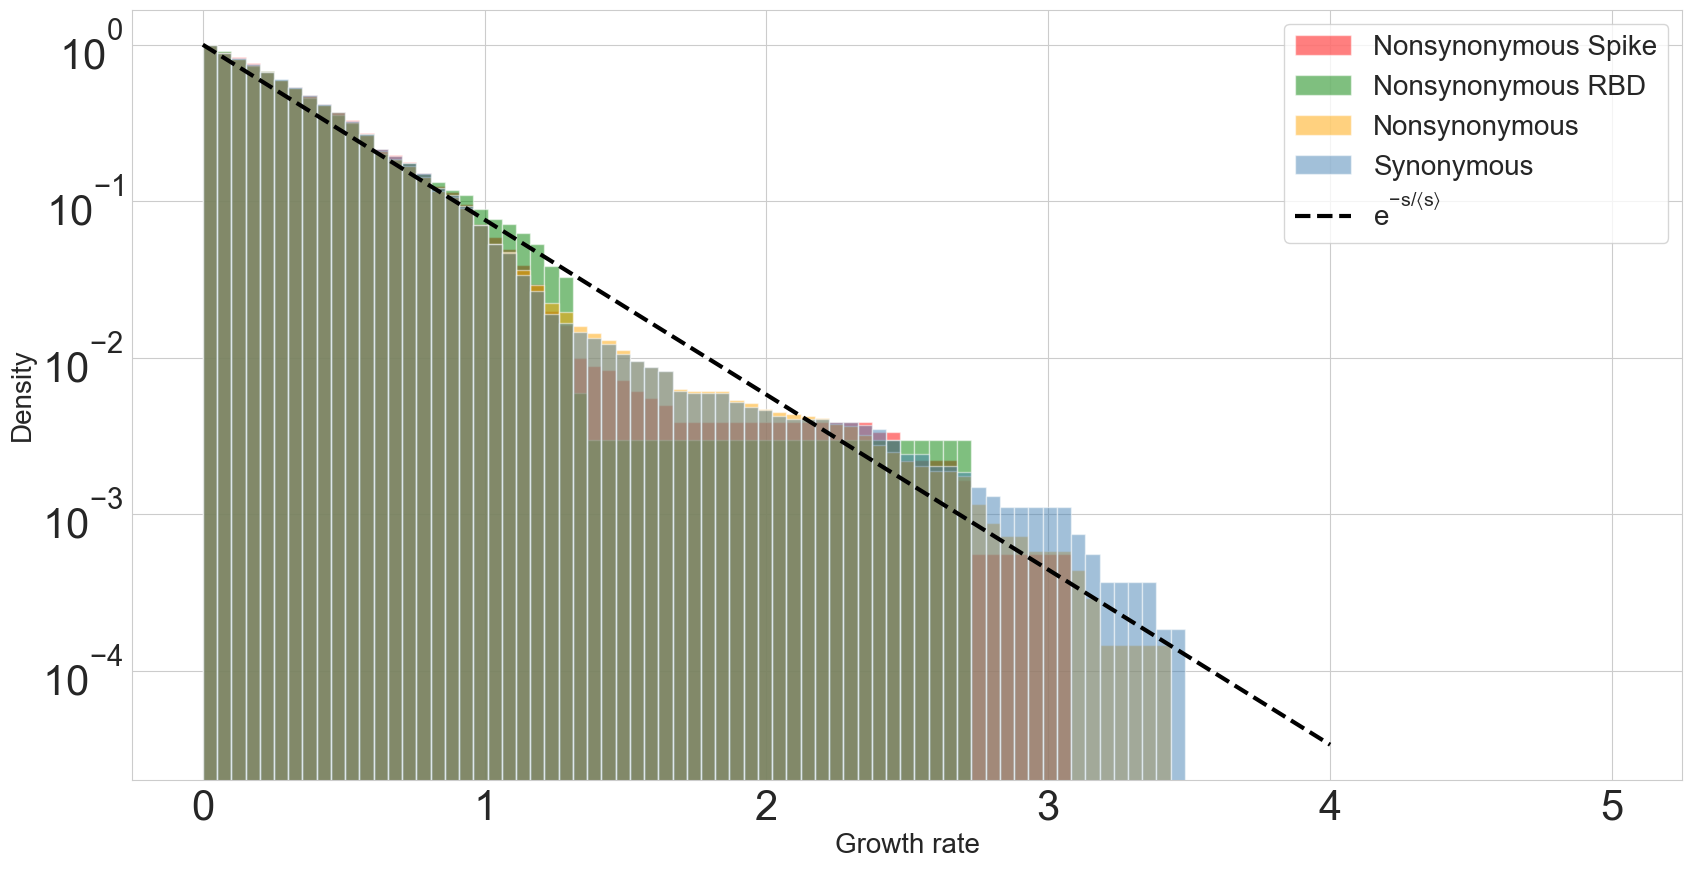

In [144]:
fig,ax= plt.subplots(1,figsize = (20,10))

bins = np.linspace(0,5,100)
ax.hist(nonsyn_S_clade_stats['s_w'].values[~np.isnan(nonsyn_S_clade_stats['s_w'])],bins = bins,density=True, label = 'Nonsynonymous Spike',color='red',cumulative=-1,alpha=.5)

ax.hist(nonsyn_RBD_clade_stats['s_w'].values[~np.isnan(nonsyn_RBD_clade_stats['s_w'])],bins = bins,density=True, label = 'Nonsynonymous RBD',color='green',cumulative=-1,alpha=.5)

ax.hist(nonsyn_all_clade_stats['s_w'].values[~np.isnan(nonsyn_all_clade_stats['s_w'])],bins = bins,density=True, label = 'Nonsynonymous',color='orange',cumulative=-1,alpha=.5)

ax.hist(syn_clade_stats['s_w'].values[~np.isnan(syn_clade_stats['s_w'])],bins = bins,density=True, label = 'Synonymous',color='steelblue',cumulative=-1,alpha=.5)

# ax.set_xscale('log')
svals = np.linspace(0,4,100)
ax.plot(svals,np.exp(-svals/np.average(
    nonsyn_S_clade_stats['s_w'].values[~np.isnan(nonsyn_S_clade_stats['s_w'])])),label = r'$e^{-s/\langle s \rangle}$',color='black',linestyle='--')
ax.set_ylabel('Density',fontsize=20)
ax.set_yscale('log')
ax.set_xlabel('Growth rate',fontsize=20)
ax.legend(loc='best',fontsize=20)
# ax.set_xlim(left=.1,right=.6)
# ax.set_xscale('log')
print(f'avg_s_w S {np.average(nonsyn_S_clade_stats['s_w'].values[~np.isnan(nonsyn_S_clade_stats['s_w'])]):.3f}, counts = {len(nonsyn_S_clade_stats)}')
print(f'avg_s_w RBD {np.average(nonsyn_RBD_clade_stats['s_w'].values[~np.isnan(nonsyn_RBD_clade_stats['s_w'])]):.3f}, counts = {len(nonsyn_RBD_clade_stats)}')
print(f'avg_s_w nonsyn_all {np.average(nonsyn_all_clade_stats['s_w'].values[~np.isnan(nonsyn_all_clade_stats['s_w'])]):.3f}, counts = {len(nonsyn_all_clade_stats)}')
print(f'avg_s_w syn {np.average(syn_clade_stats['s_w'].values[~np.isnan(syn_clade_stats['s_w'])]):.3f}, counts = {len(syn_clade_stats)}')

In [145]:
print(f'sbar_S (max s_w S over log(counts)) {np.max(nonsyn_S_clade_stats["s_w"].values[~np.isnan(nonsyn_S_clade_stats["s_w"])])/np.log(len(nonsyn_S_clade_stats)):.3f}')
print(f'sbar_RBD (max s_w RBD over log(counts)) {np.max(nonsyn_RBD_clade_stats["s_w"].values[~np.isnan(nonsyn_RBD_clade_stats["s_w"])])/np.log(len(nonsyn_RBD_clade_stats)):.3f}')
print(f'sbar_nonsyn_all (max s_w nonsyn_all over log(counts)) {np.max(nonsyn_all_clade_stats["s_w"].values[~np.isnan(nonsyn_all_clade_stats["s_w"])])/np.log(len(nonsyn_all_clade_stats)):.3f}')
print(f'sbar_syn (max s_w syn over log(counts)) {np.max(syn_clade_stats["s_w"].values[~np.isnan(syn_clade_stats["s_w"])])/np.log(len(syn_clade_stats)):.3f}')

sbar_S (max s_w S over log(counts)) 0.277
sbar_RBD (max s_w RBD over log(counts)) 0.298
sbar_nonsyn_all (max s_w nonsyn_all over log(counts)) 0.275
sbar_syn (max s_w syn over log(counts)) 0.283


In [146]:
nonsyn_S_clade_stats['s_w'].values[~np.isnan(nonsyn_S_clade_stats['s_w'])]-np.average(nonsyn_S_clade_stats['s_w'][~np.isnan(nonsyn_S_clade_stats['s_w'])])

array([-0.38843634,  0.28003929,  0.71157367, ..., -0.19553028,
       -0.06447799, -0.02307775])

In [147]:
World_cases = 7*covid_data_World['new_cases_smoothed']
World_cases = World_cases[World_cases>0]
World_cases = World_cases[~np.isinf(World_cases)]
World_cases = World_cases[~np.isnan(World_cases)]


covid_data_World['Time_datetime'] = pd.to_datetime(covid_data_World['date'])
covid_data_World['day_diff'] = covid_data_World['Time_datetime']-reference_date

covid_data_World['day_diff'] = covid_data_World['day_diff'].apply(lambda x: x.days)
covid_data_World['weekly_new_cases_smoothed'] = covid_data_World['new_cases_smoothed']*7

I_over_time = covid_data_World['weekly_new_cases_smoothed'].values

Text(0.5, 1.0, 'Nonsynonymous RBD')

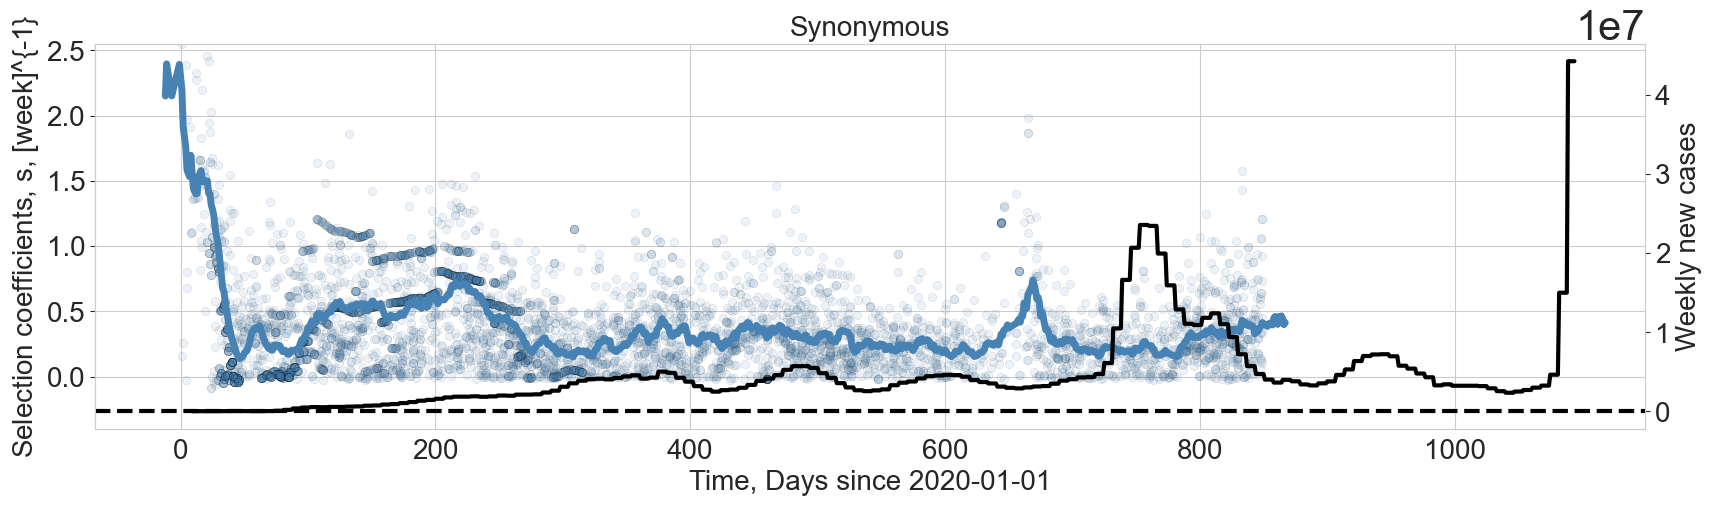

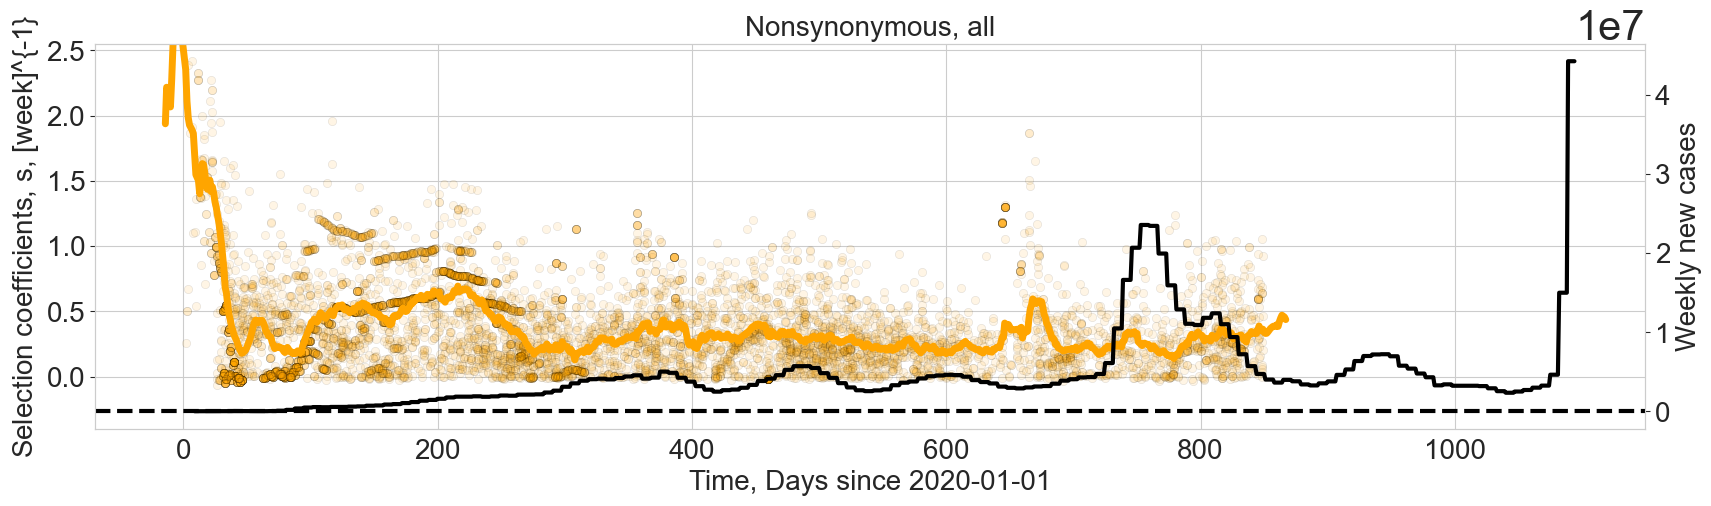

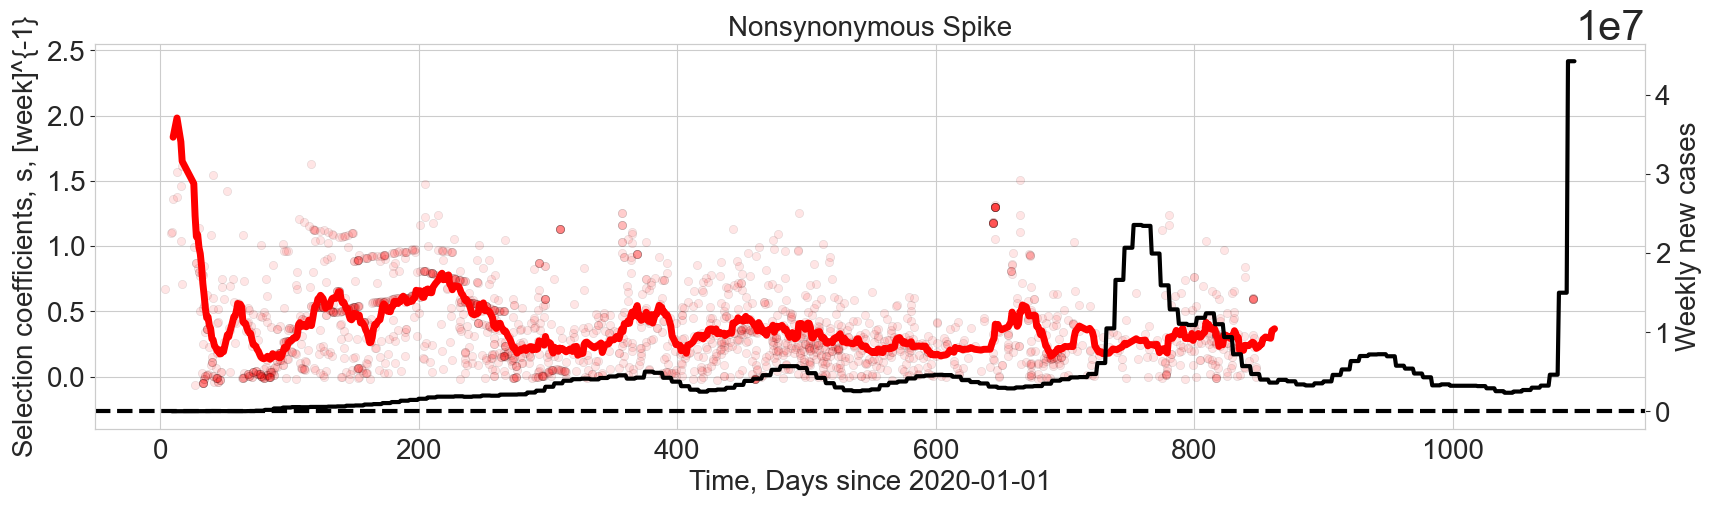

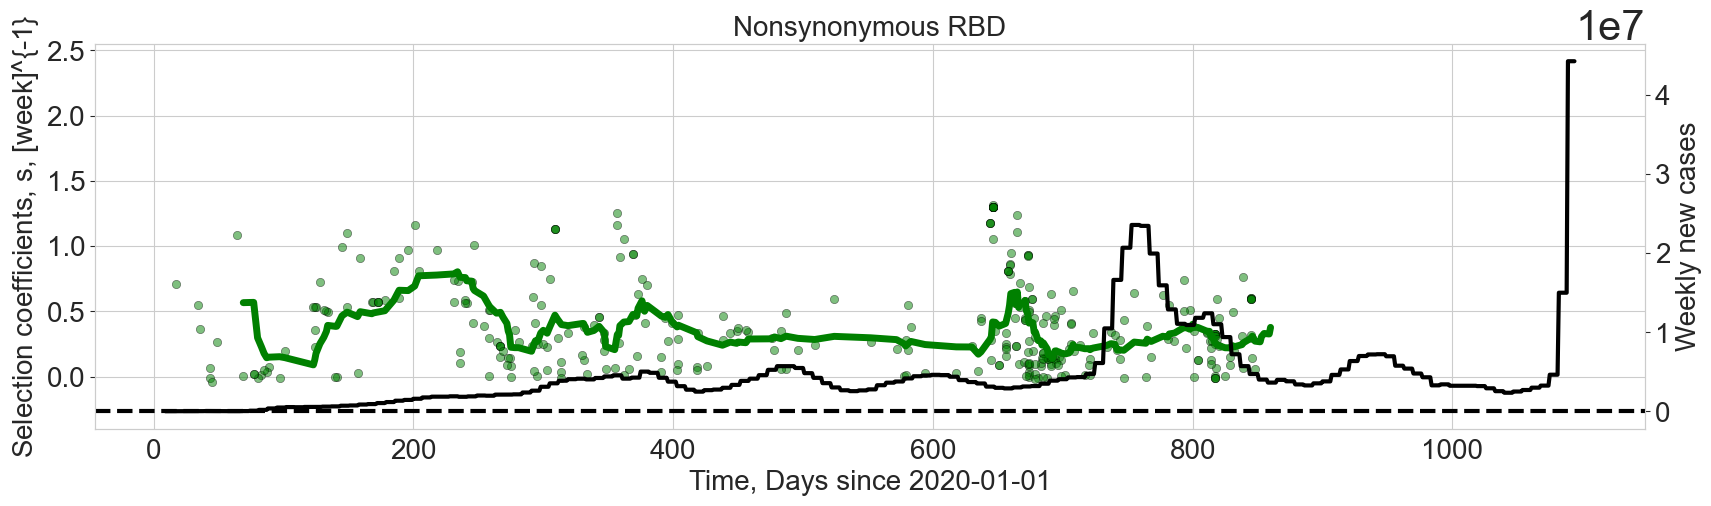

In [148]:
fig,ax= plt.subplots(1,figsize = (20,5))
sns.scatterplot(data = syn_clade_stats.query('day_diff > 0 & day_diff< 850'), x = 'day_diff', y = 's_w',alpha=.1, color='steelblue',legend=False,edgecolor='black')
syn_clade_stats.groupby('day_diff')['s_w'].mean().dropna().rolling(10).mean().plot(color='steelblue',ax=ax,lw=5,)
tax = ax.twinx()
sns.lineplot(data = covid_data_World, x = 'day_diff', y = 'weekly_new_cases_smoothed', ax = tax ,color='black')

ax.set_ylabel(r'Selection coefficients, $s$, [week]^{-1}',fontsize=20)
tax.set_ylabel('Weekly new cases',fontsize=20)
ax.set_xlabel('Time, Days since 2020-01-01',fontsize=20)
ax.set_ylim(-.4,2.55)

tax.set_xlim(ax.get_xlim())
tax.grid(False)
tax.axhline(0,linestyle='--',color='black')
ax.tick_params(axis='both', which='major', labelsize=20)
tax.tick_params(axis='both', which='major', labelsize=20)

ax.set_title('Synonymous',fontsize=20)
############################
fig,ax= plt.subplots(1,figsize = (20,5))
sns.scatterplot(data = nonsyn_all_clade_stats.query('day_diff > 0 & day_diff< 850'), x = 'day_diff', y = 's_w',alpha=.1, color='orange',legend=False,edgecolor='black')
nonsyn_all_clade_stats.groupby('day_diff')['s_w'].mean().dropna().rolling(10).mean().plot(color='orange',ax=ax,lw=5,)
tax = ax.twinx()
sns.lineplot(data = covid_data_World, x = 'day_diff', y = 'weekly_new_cases_smoothed', ax = tax ,color='black')

ax.set_ylabel(r'Selection coefficients, $s$, [week]^{-1}',fontsize=20)
tax.set_ylabel('Weekly new cases',fontsize=20)
ax.set_xlabel('Time, Days since 2020-01-01',fontsize=20)
ax.set_ylim(-.4,2.55)

tax.set_xlim(ax.get_xlim())
tax.grid(False)
tax.axhline(0,linestyle='--',color='black')
ax.tick_params(axis='both', which='major', labelsize=20)
tax.tick_params(axis='both', which='major', labelsize=20)

ax.set_title('Nonsynonymous, all',fontsize=20)
############################
fig,ax= plt.subplots(1,figsize = (20,5))
sns.scatterplot(data = nonsyn_S_clade_stats.query('day_diff > 0 & day_diff< 850'), x = 'day_diff', y = 's_w',alpha=.1, color='red',legend=False,edgecolor='black')
nonsyn_S_clade_stats.groupby('day_diff')['s_w'].mean().dropna().rolling(10).mean().plot(color='red',ax=ax,lw=5,)
tax = ax.twinx()
sns.lineplot(data = covid_data_World, x = 'day_diff', y = 'weekly_new_cases_smoothed', ax = tax ,color='black')

ax.set_ylabel(r'Selection coefficients, $s$, [week]^{-1}',fontsize=20)
tax.set_ylabel('Weekly new cases',fontsize=20)
ax.set_xlabel('Time, Days since 2020-01-01',fontsize=20)
ax.set_ylim(-.4,2.55)

tax.set_xlim(ax.get_xlim())
tax.grid(False)
tax.axhline(0,linestyle='--',color='black')
ax.tick_params(axis='both', which='major', labelsize=20)
tax.tick_params(axis='both', which='major', labelsize=20)

ax.set_title('Nonsynonymous Spike',fontsize=20)
############################
fig,ax= plt.subplots(1,figsize = (20,5))
sns.scatterplot(data = nonsyn_RBD_clade_stats.query('day_diff > 0 & day_diff< 850'), x = 'day_diff', y = 's_w',alpha=.5, color='green',legend=False,edgecolor='black')
# sns.scatterplot(data = nonsyn_S_clade_stats.query('day_diff > 0 & day_diff< 850'), x = 'day_diff', y = 's_w',alpha=.1, color='red',legend=False)
nonsyn_RBD_clade_stats.groupby('day_diff')['s_w'].mean().dropna().rolling(10).mean().plot(color = 'green',ax=ax,lw=5,)
tax = ax.twinx()
sns.lineplot(data = covid_data_World, x = 'day_diff', y = 'weekly_new_cases_smoothed', ax = tax ,color='black')
# ax.set_ylim(avg_s - np.sqrt(var_s),avg_s + 3*np.sqrt(var_s))

ax.set_ylabel(r'Selection coefficients, $s$, [week]^{-1}',fontsize=20)
tax.set_ylabel('Weekly new cases',fontsize=20)
ax.set_xlabel('Time, Days since 2020-01-01',fontsize=20)
ax.set_ylim(-.4,2.55)

# tax.set_ylim(.1,1.5*np.max(covid_data_World['weekly_new_cases_smoothed']))

tax.set_xlim(ax.get_xlim())
tax.grid(False)
tax.axhline(0,linestyle='--',color='black')
ax.tick_params(axis='both', which='major', labelsize=20)
tax.tick_params(axis='both', which='major', labelsize=20)

ax.set_title('Nonsynonymous RBD',fontsize=20)




In [149]:
avg_max_x_by_s = nonsyn_S_clade_stats.groupby('s_w')['Max_Freq'].mean().dropna().rolling(10).mean()
s_w_vals = avg_max_x_by_s.index


In [150]:
#import savgol_filter
from scipy.signal import savgol_filter
#import gaussian smoothing
from scipy.ndimage import gaussian_filter1d

avg_max_x_by_s_smooth = gaussian_filter1d(avg_max_x_by_s, sigma=2)

In [151]:
# s_w_vals = s_w_vals[~np.isnan(avg_max_x_by_s_smooth)]
# avg_max_x_by_s_smooth = avg_max_x_by_s_smooth[~np.isnan(avg_max_x_by_s_smooth)]


(1e-05, 2)

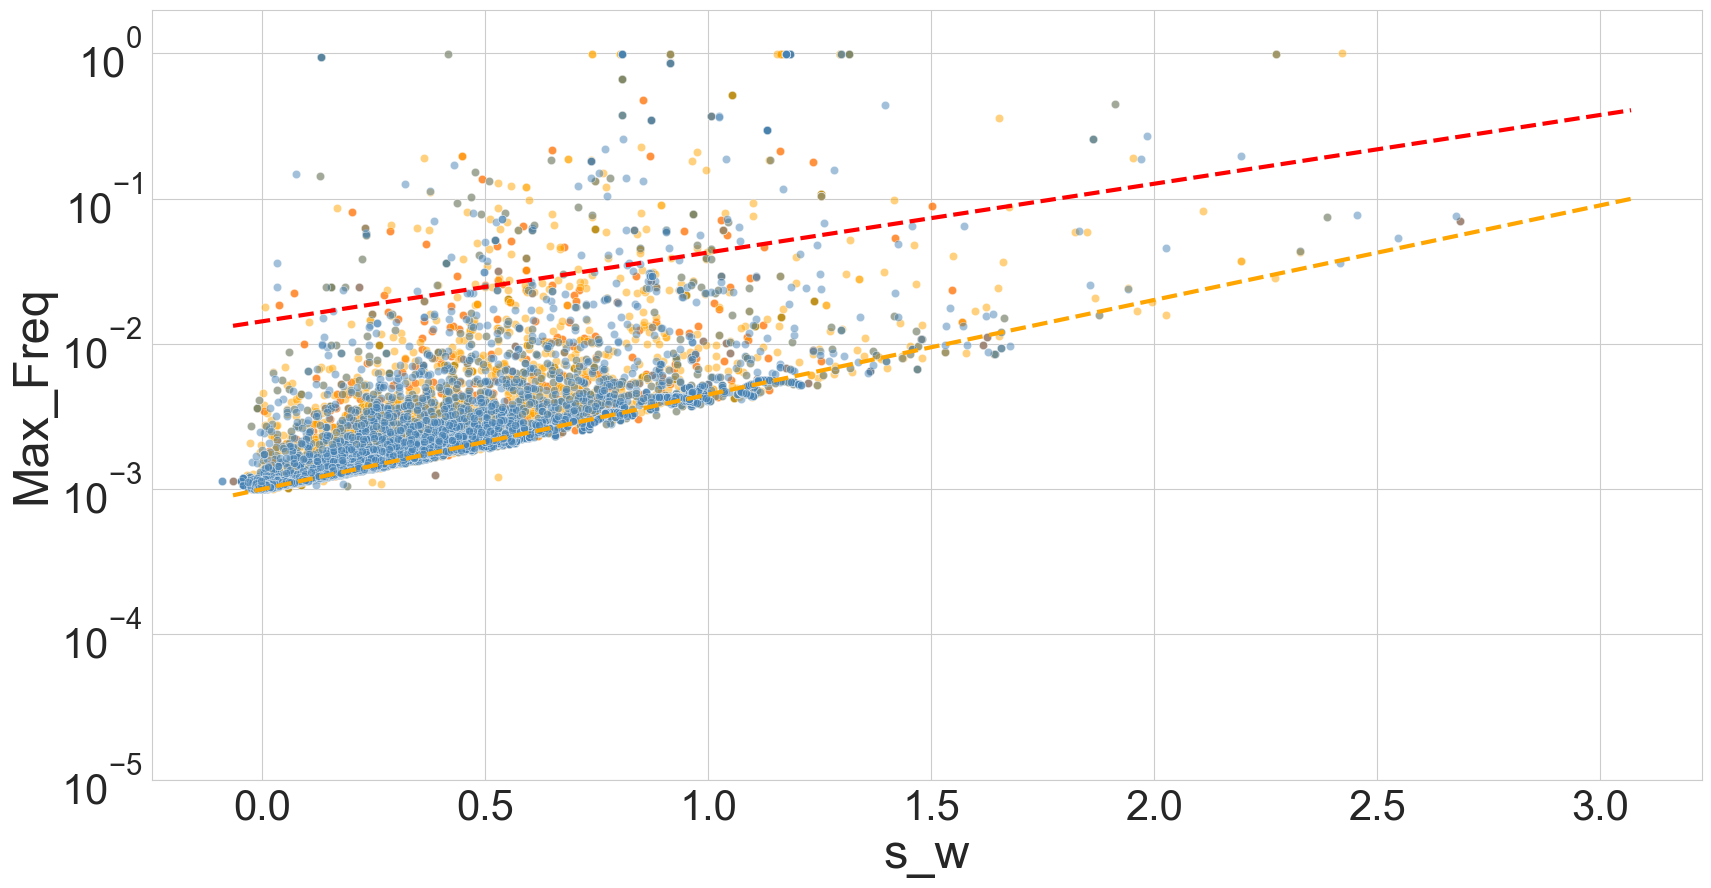

In [152]:
fig,ax = plt.subplots(1,figsize = (20,10))
sns.scatterplot(data = nonsyn_S_clade_stats.query('day_diff > 0 & day_diff< 850'), x = 's_w', y = 'Max_Freq',alpha=.5, color='red')

sns.scatterplot(data = nonsyn_RBD_clade_stats.query('day_diff > 0 & day_diff< 850'), x = 's_w', y = 'Max_Freq',alpha=.5, color='green')

sns.scatterplot(data = nonsyn_all_clade_stats.query('day_diff > 0 & day_diff< 850'), x = 's_w', y = 'Max_Freq',alpha=.5, color='orange')

sns.scatterplot(data = syn_clade_stats.query('day_diff > 0 & day_diff< 850'), x = 's_w', y = 'Max_Freq',alpha=.5, color='steelblue')

# ax.plot(s_w_vals[~np.isnan(avg_max_x_by_s)],avg_max_x_by_s_smooth, color='red',lw=2)
#fit with exponential
fitfunc = lambda x,a,b: a*np.exp(b*x)
popt, pcov = so.curve_fit(fitfunc, s_w_vals[~np.isnan(avg_max_x_by_s)],avg_max_x_by_s[~np.isnan(avg_max_x_by_s)],p0=[1,1])
a,b = popt
ax.plot(s_w_vals,fitfunc(s_w_vals,a,b), color='red',linestyle='--')
ax.plot(s_w_vals,fitfunc(s_w_vals,1e-3,1.5), color='orange',linestyle='--')
ax.set_yscale('log')
ax.set_ylim(1e-5,2)

In [153]:
# df_pot_selection  = pd.read_csv('data/df_pot_selection.txt',sep = '\t')
fitness_france = pd.read_csv('data/fitness_France.txt',sep = '\t')

In [154]:
fitness_france['day_diff'] = (pd.to_datetime(fitness_france['date']) - reference_date).dt.days
fitness_france.columns

Index(['Unnamed: 0', 'WT_freq', 'WT_fitness_inf', 'WT_fitness_vac',
       'WT_F_pot_inf', 'WT_F_pot_vac', 'B.1.617.2_freq',
       'B.1.617.2_fitness_inf', 'B.1.617.2_fitness_vac', 'B.1.617.2_F_pot_inf',
       'B.1.617.2_F_pot_vac', 'B.1.1.7_freq', 'B.1.1.7_fitness_inf',
       'B.1.1.7_fitness_vac', 'B.1.1.7_F_pot_inf', 'B.1.1.7_F_pot_vac',
       'BA.1_freq', 'BA.1_fitness_inf', 'BA.1_fitness_vac', 'BA.1_F_pot_inf',
       'BA.1_F_pot_vac', 'BA.2_freq', 'BA.2_fitness_inf', 'BA.2_fitness_vac',
       'BA.2_F_pot_inf', 'BA.2_F_pot_vac', 'BA.5_freq', 'BA.5_fitness_inf',
       'BA.5_fitness_vac', 'BA.5_F_pot_inf', 'BA.5_F_pot_vac', 'BA.2.86_freq',
       'BA.2.86_fitness_inf', 'BA.2.86_fitness_vac', 'BA.2.86_F_pot_inf',
       'BA.2.86_F_pot_vac', 'JN.1_freq', 'JN.1_fitness_inf',
       'JN.1_fitness_vac', 'JN.1_F_pot_inf', 'JN.1_F_pot_vac', 'XBB.1.5_freq',
       'XBB.1.5_fitness_inf', 'XBB.1.5_fitness_vac', 'XBB.1.5_F_pot_inf',
       'XBB.1.5_F_pot_vac', 'XBB.1.9_freq', 'XBB.1.9_fi

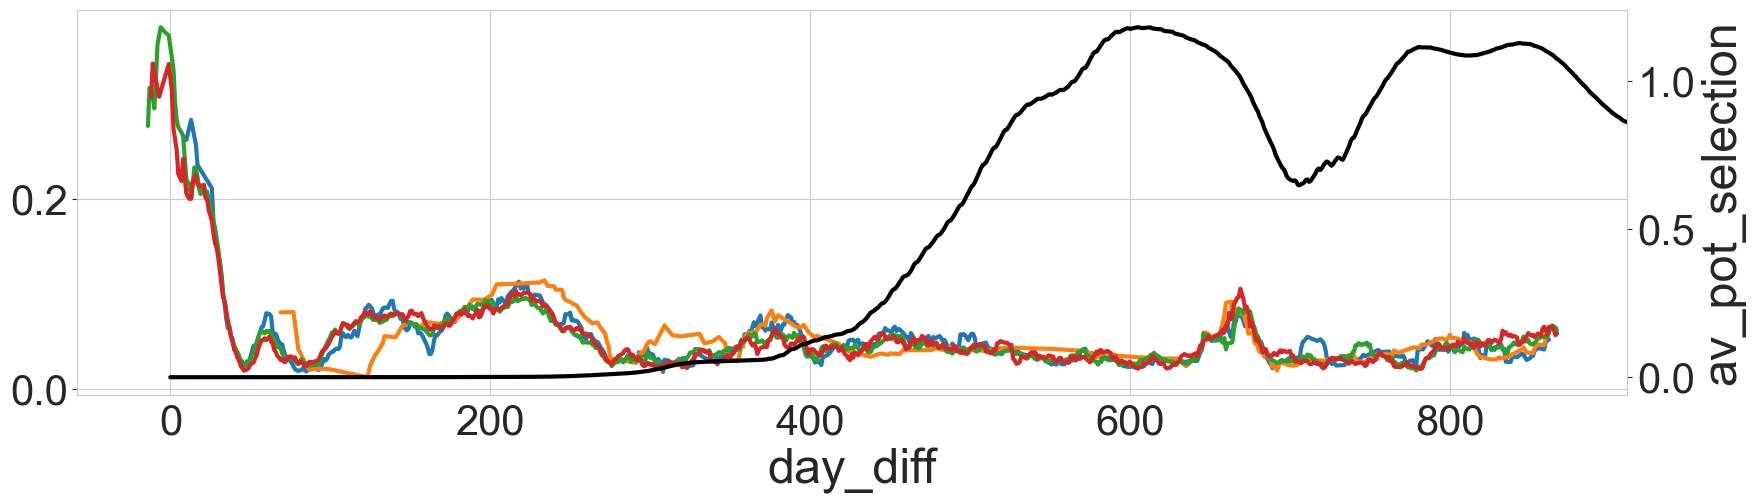

In [155]:
fig,ax= plt.subplots(1,figsize = (20,5))
# nonsyn_S_clade_stats.groupby('day_diff')['s'].mean().plot(ax=ax)
#drop the na values and plot smoothed
nonsyn_S_clade_stats.groupby('day_diff')['s'].mean().dropna().rolling(10).mean().plot(ax=ax)
nonsyn_RBD_clade_stats.groupby('day_diff')['s'].mean().dropna().rolling(10).mean().plot(ax=ax)
nonsyn_all_clade_stats.groupby('day_diff')['s'].mean().dropna().rolling(10).mean().plot(ax=ax)
syn_clade_stats.groupby('day_diff')['selection'].mean().dropna().rolling(10).mean().plot(ax=ax)

xlim = ax.get_xlim()
tax= ax.twinx()
sns.lineplot(data = fitness_france, x = 'day_diff', y = 'av_pot_selection', ax = tax ,color='black')
tax.set_xlim(xlim)
tax.grid(False)

In [156]:
#drop rows with na values on s_w
nonsyn_S_clade_stats_notna = nonsyn_S_clade_stats[~np.isnan(nonsyn_S_clade_stats['s_w'])]

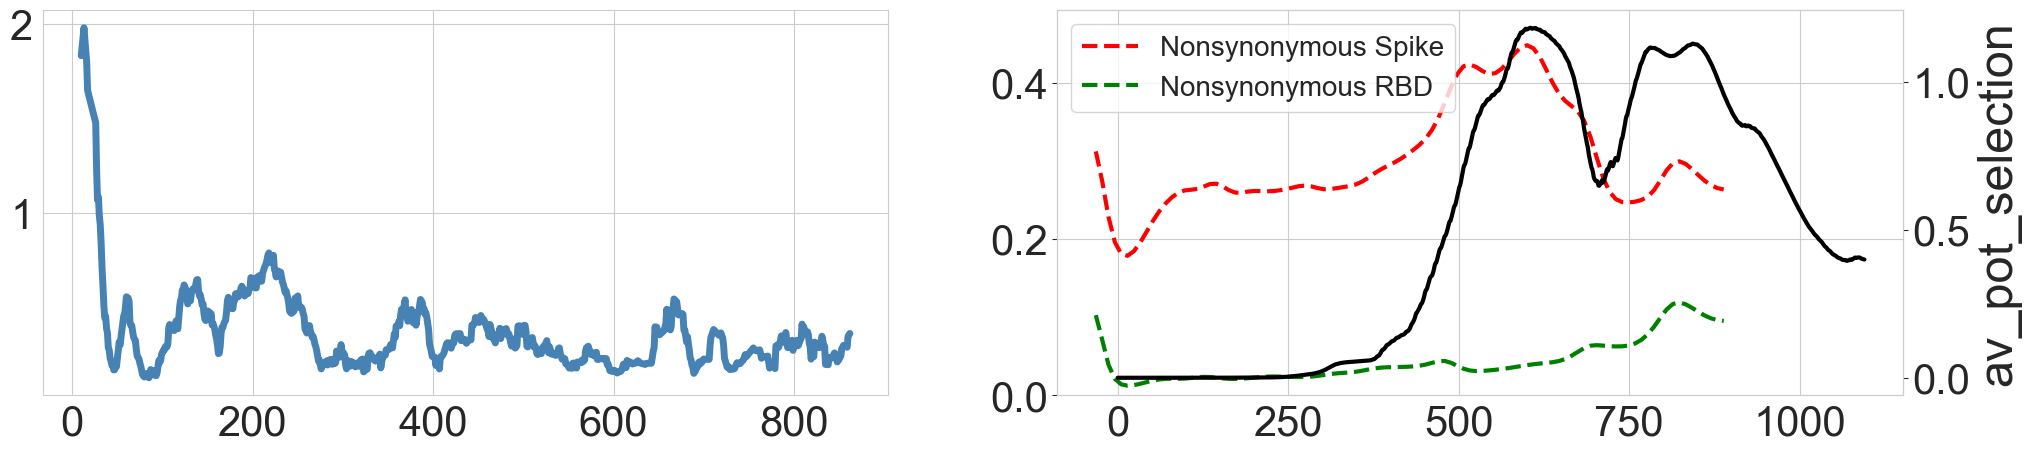

In [171]:
avg_s_nonsyn_S = nonsyn_S_clade_stats_notna.groupby('day_diff')['s_w'].mean()
time_nonsyn_S = np.sort(nonsyn_S_clade_stats_notna.day_diff.unique())

avg_s_nonsyn_RBD = nonsyn_RBD_clade_stats.groupby('day_diff')['s_w'].mean()
time_nonsyn_RBD = np.sort(nonsyn_RBD_clade_stats.day_diff.unique())

for x_thresh in [2e-8,2e-5,2e-2]:

    fig,ax= plt.subplots(1,2,figsize = (24,5))

    ax[0].plot(time_nonsyn_S,avg_s_nonsyn_S.rolling(10).mean(),color='steelblue',lw=5, label = 'selection')
    # ax[0].plot(time_nonsyn_RBD,avg_s_nonsyn_RBD.rolling(10).mean(),color='green',lw=5)

    h_syn,b_syn,p_syn = ax[1].hist(syn_clade_stats.query(f'Max_Freq >{x_thresh}')['day_diff'],bins = 100, lw=2, histtype = 'step',color='steelblue',alpha=0)

    h_nonsyn_S,b_nonsyn_S,p_nonsyn_S = ax[1].hist(nonsyn_S_clade_stats.query(f'Max_Freq >{x_thresh}')['day_diff'],bins = 100, lw=2, histtype = 'step',color='orange',alpha=0)
    h_nonsyn_RBD,b_nonsyn_RBD,p_nonsyn_RBD = ax[1].hist(nonsyn_RBD_clade_stats.query(f'Max_Freq >{x_thresh}')['day_diff'],bins = 100, lw=2, histtype = 'step',color='orange',alpha=0)

    h_smoothed_syn = gaussian_filter1d(h_syn, sigma=2)
    # ax[1].plot(b_syn[:-1],h_smoothed_syn, label = 'Synonymous',color='steelblue',linestyle='--')
    h_smoothed_nonsyn_S = gaussian_filter1d(h_nonsyn_S, sigma=2)
    h_smoothed_nonsyn_RBD = gaussian_filter1d(h_nonsyn_RBD, sigma=2)



    ax[1].plot(b_nonsyn_S[:-1],h_smoothed_nonsyn_S/h_smoothed_syn, label = 'Nonsynonymous Spike',color='Red',linestyle='--')
    ax[1].plot(b_nonsyn_S[:-1],h_smoothed_nonsyn_RBD/h_smoothed_syn, label = 'Nonsynonymous RBD',color='green',linestyle='--')

    max_y_val = np.max(((h_smoothed_nonsyn_S/h_smoothed_syn) [h_smoothed_syn>0], (h_smoothed_nonsyn_RBD/h_smoothed_syn) [ h_smoothed_syn>0]))
    # ax[1].grid(False)

    tax1= ax[1].twinx()
    sns.lineplot(data = fitness_france, x = 'day_diff', y = 'av_pot_selection', ax = tax1 ,color='black',zorder=1)
    tax1.grid(False)
    
    ax[1].set_ylim(0,np.min((max_y_val*1.1,4)))
    ax[1].legend(loc='upper left',fontsize=20)

In [158]:
reference_date

Timestamp('2020-01-01 00:00:00')

In [159]:
fig,ax= plt.subplots(1,1,figsize = (20,5))
ax.plot(time_nonsyn_S,avg_s_nonsyn_S.rolling(10).mean(),color='red',lw=5, label = 'selection')
ax.plot(time_nonsyn_RBD,avg_s_nonsyn_RBD.rolling(4).mean(),color='green',lw=5)

tax = ax.twinx()
sns.lineplot(data = covid_data_World, x = 'day_diff', y = 'weekly_new_cases_smoothed', ax = tax ,color='black')
tax.grid(False)
tax.set_ylabel('Weekly new cases',fontsize=20)
ax.set_ylabel(r'Selection coefficients, $s$, [week]^{-1}',fontsize=20)
ax.set_xlabel('Time, Days since 2020-01-01',fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
tax.tick_params(axis='both', which='major', labelsize=20)

Text(0.5, 0, 'Time, Days since 2020-01-01')

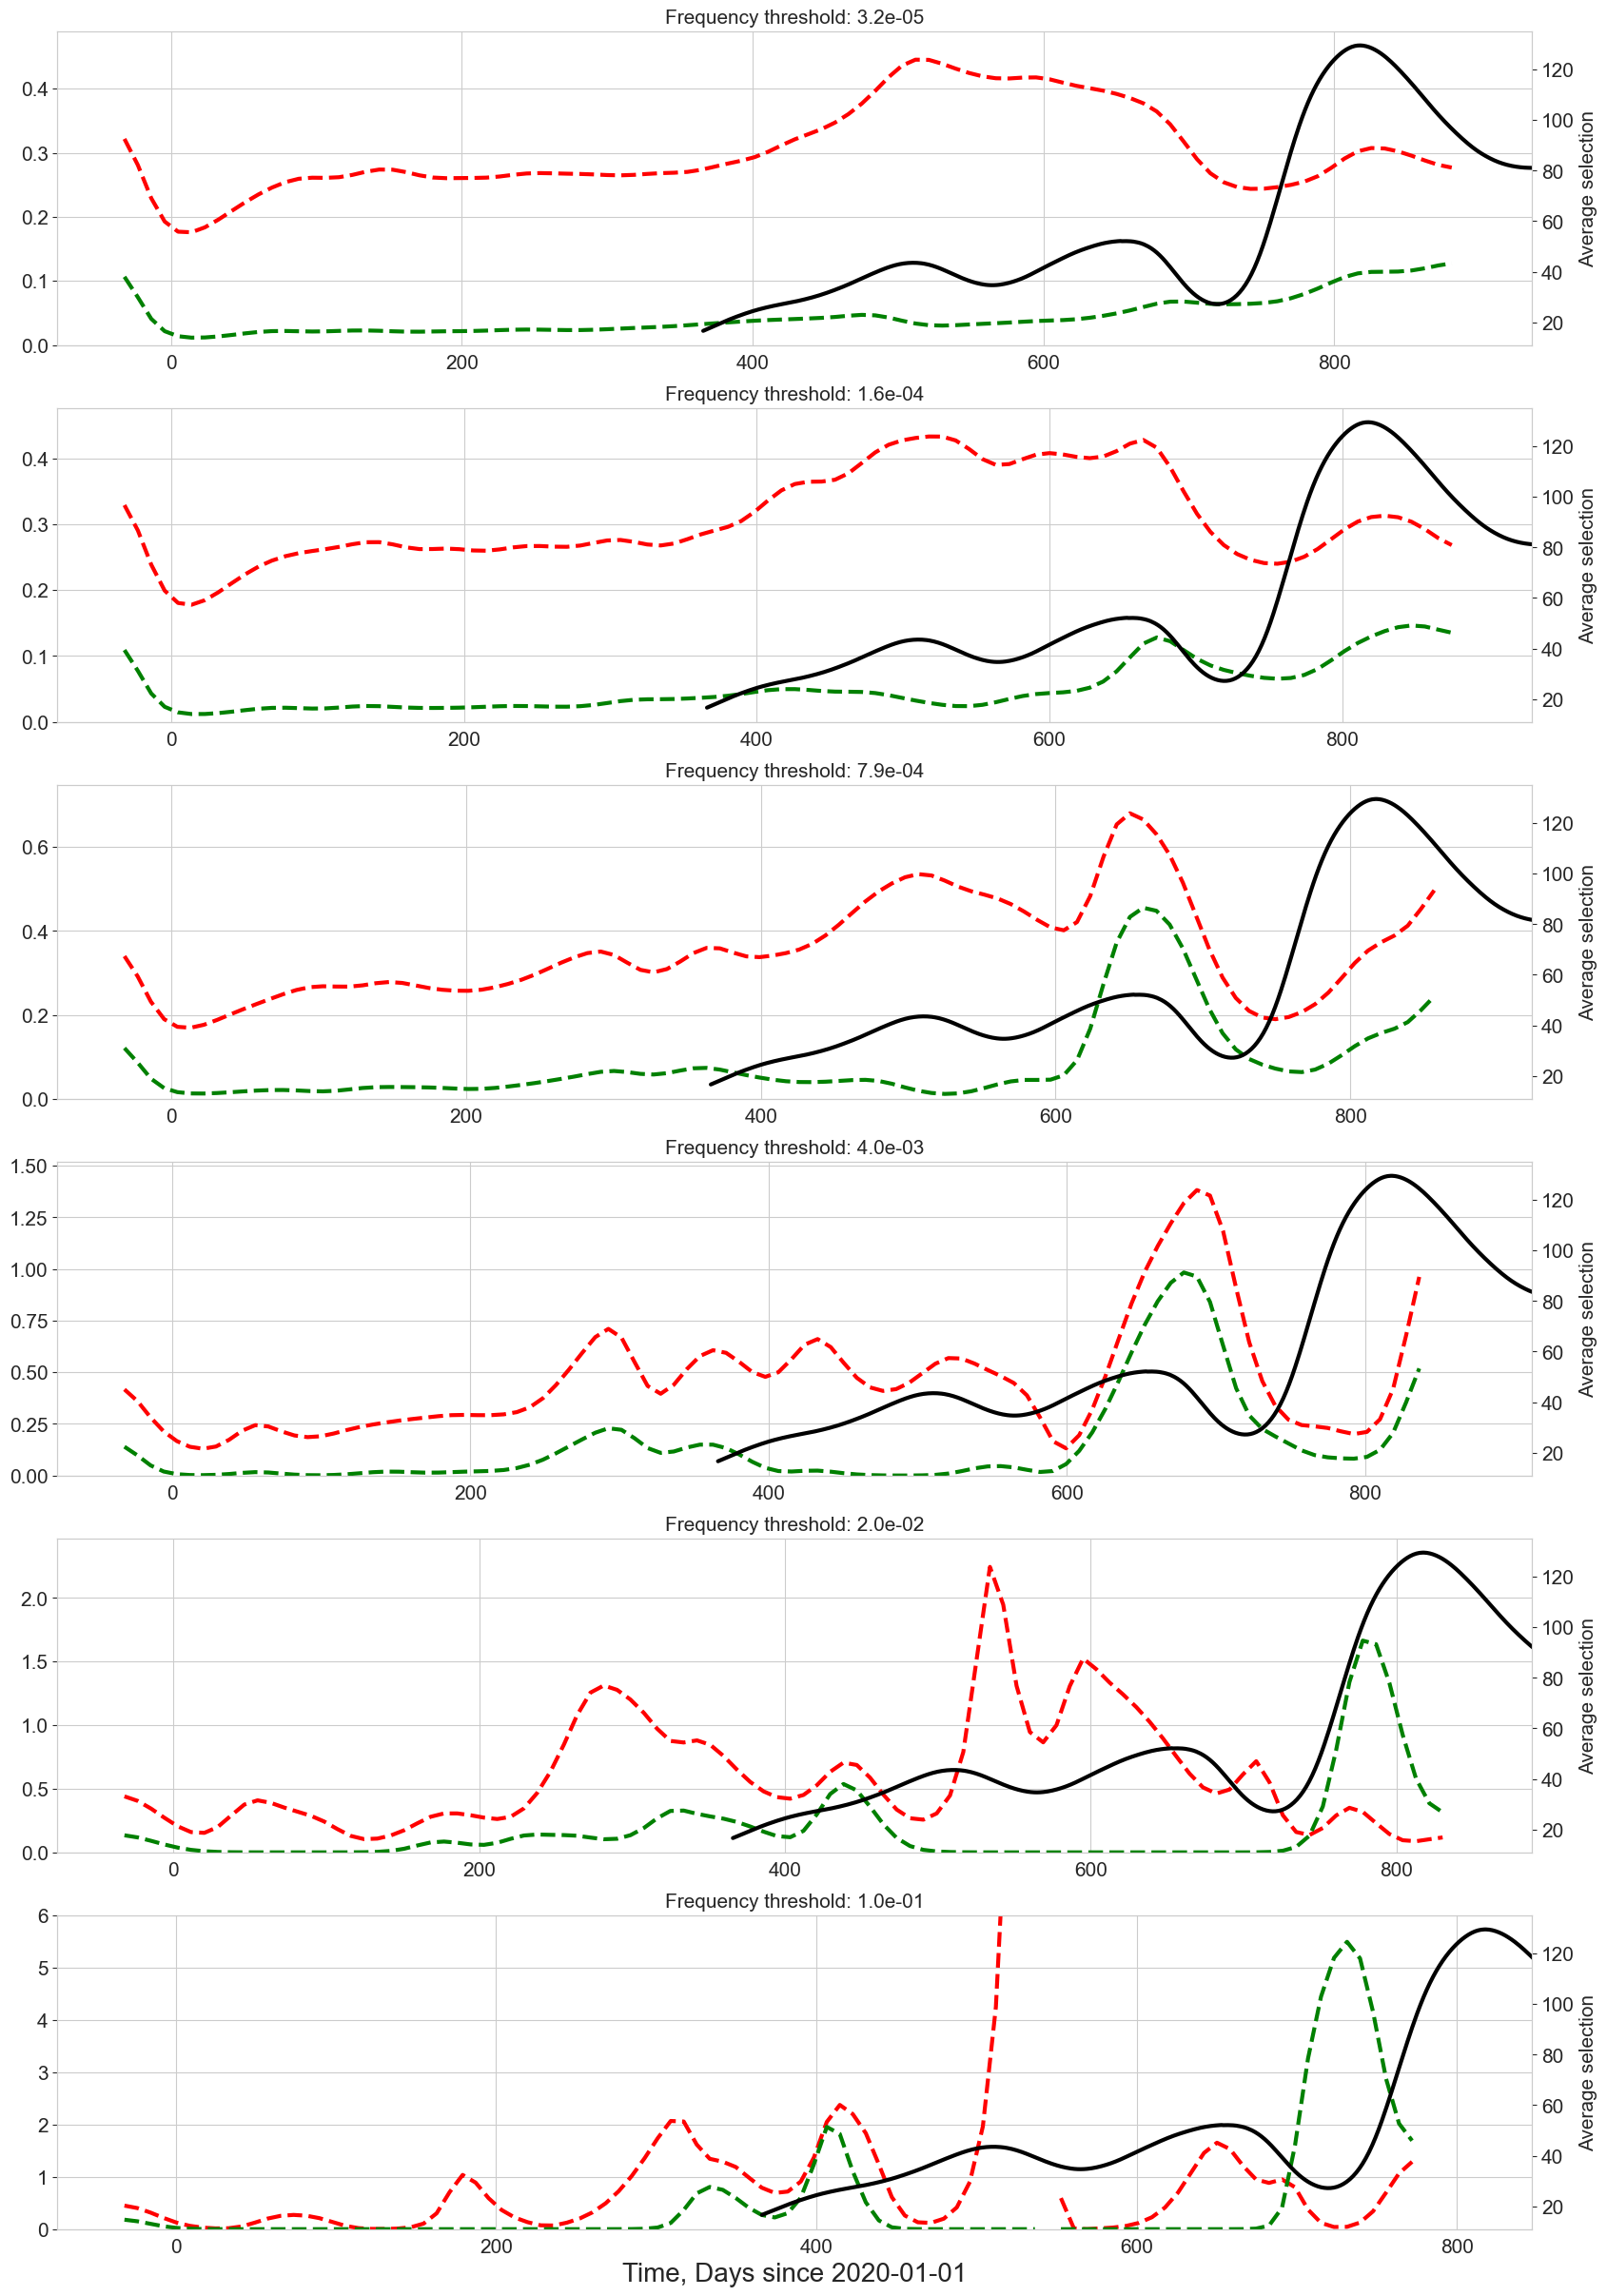

In [160]:
n_vals = 6
x_thresh_vals = np.logspace(-4.5,-1,n_vals)
fig,ax= plt.subplots(n_vals,1,figsize = (20,30))

for i,x_thresh in enumerate(x_thresh_vals):

    h_syn,b_syn,p_syn = ax[i].hist(syn_clade_stats.query(f'Max_Freq >{x_thresh}')['day_diff'],bins = 100, lw=2, histtype = 'step',color='steelblue',alpha=0)

    h_nonsyn_S,b_nonsyn_S,p_nonsyn_S = ax[i].hist(nonsyn_S_clade_stats.query(f'Max_Freq >{x_thresh}')['day_diff'],bins = 100, lw=2, histtype = 'step',color='orange',alpha=0)
    h_nonsyn_RBD,b_nonsyn_RBD,p_nonsyn_RBD = ax[i].hist(nonsyn_RBD_clade_stats.query(f'Max_Freq >{x_thresh}')['day_diff'],bins = 100, lw=2, histtype = 'step',color='orange',alpha=0)

    h_smoothed_syn = gaussian_filter1d(h_syn, sigma=2)
    # ax[i].plot(b_syn[:-1],h_smoothed_syn, label = 'Synonymous',color='steelblue',linestyle='--')
    h_smoothed_nonsyn_S = gaussian_filter1d(h_nonsyn_S, sigma=2)
    h_smoothed_nonsyn_RBD = gaussian_filter1d(h_nonsyn_RBD, sigma=2)



    ax[i].plot(b_nonsyn_S[:-1],h_smoothed_nonsyn_S/h_smoothed_syn, label = 'Nonsynonymous Spike',color='Red',linestyle='--')
    ax[i].plot(b_nonsyn_S[:-1],h_smoothed_nonsyn_RBD/h_smoothed_syn, label = 'Nonsynonymous RBD',color='green',linestyle='--')

    max_y_val = np.max(((h_smoothed_nonsyn_S/h_smoothed_syn) [h_smoothed_syn>0], (h_smoothed_nonsyn_RBD/h_smoothed_syn) [ h_smoothed_syn>0]))
    # ax[i].grid(False)
    ax[i].set_ylim(0,np.min((max_y_val*1.1,6)))
    # ax[i].legend(loc='best',fontsize=20)
    ax[i].set_title(f'Frequency threshold: {x_thresh:.1e}',fontsize=15)
    ax[i].tick_params(axis='both', which='major', labelsize=15)
    xlim = ax[i].get_xlim()
    tax = ax[i].twinx()
    sns.lineplot(data = df_pot_selection, x = 'day_diff', y = 'av_selection', ax = tax ,color='black')
    tax.set_xlim(xlim)
    tax.tick_params(axis='both', which='major', labelsize=15)
    tax.grid(False)
    tax.set_ylabel('Average selection',fontsize=15)

ax[-1].set_xlabel('Time, Days since 2020-01-01',fontsize=20)

In [161]:
average_infected_size = covid_data_World['weekly_new_cases_smoothed'].mean()
average_s = nonsyn_S_clade_stats.query('day_diff < 400')['s_w'].mean()

print(f'N = {average_infected_size:.1e}, s = {average_s:.1e}, Ns = {average_infected_size*average_s:.1e}')
print(f'freq_sel= {1/(average_infected_size*average_s):.1e}') 
print(f'hallatschek`s freq_sel= {1000/(average_infected_size*average_s):.1e}') 

N = 4.5e+06, s = 4.4e-01, Ns = 2.0e+06
freq_sel= 5.0e-07
hallatschek`s freq_sel= 5.0e-04


0.28956111496507103 lifetime: 43.0
nan
0.08255486468006662 lifetime: 43.0
nan
0.04721177725832251 lifetime: 27.0
nan
0.07559866878247962 lifetime: 31.0
nan
0.06004128241691588 lifetime: 29.0
nan
0.09014392402433459 lifetime: 34.0
nan
0.06567690919248946 lifetime: 29.0
nan
0.2773837070869306 lifetime: 44.0
nan
0.16164461295199015 lifetime: 36.0
nan
0.264823710369531 lifetime: 43.0
nan
0.3334503520216925 lifetime: 221.0
0.057241856571847806
0.061891099143490794 lifetime: 63.0
nan
0.24575571603507218 lifetime: 41.0
nan
0.2598487538249637 lifetime: 41.0
nan
0.1978511864064432 lifetime: 73.0
nan
0.20312087380909447 lifetime: 39.0
nan
0.18752811962491867 lifetime: 114.0
nan
0.3557639139020967 lifetime: 183.0
0.02189153207845949
0.186139830540674 lifetime: 79.0
nan
0.11609069775169795 lifetime: 33.0
nan


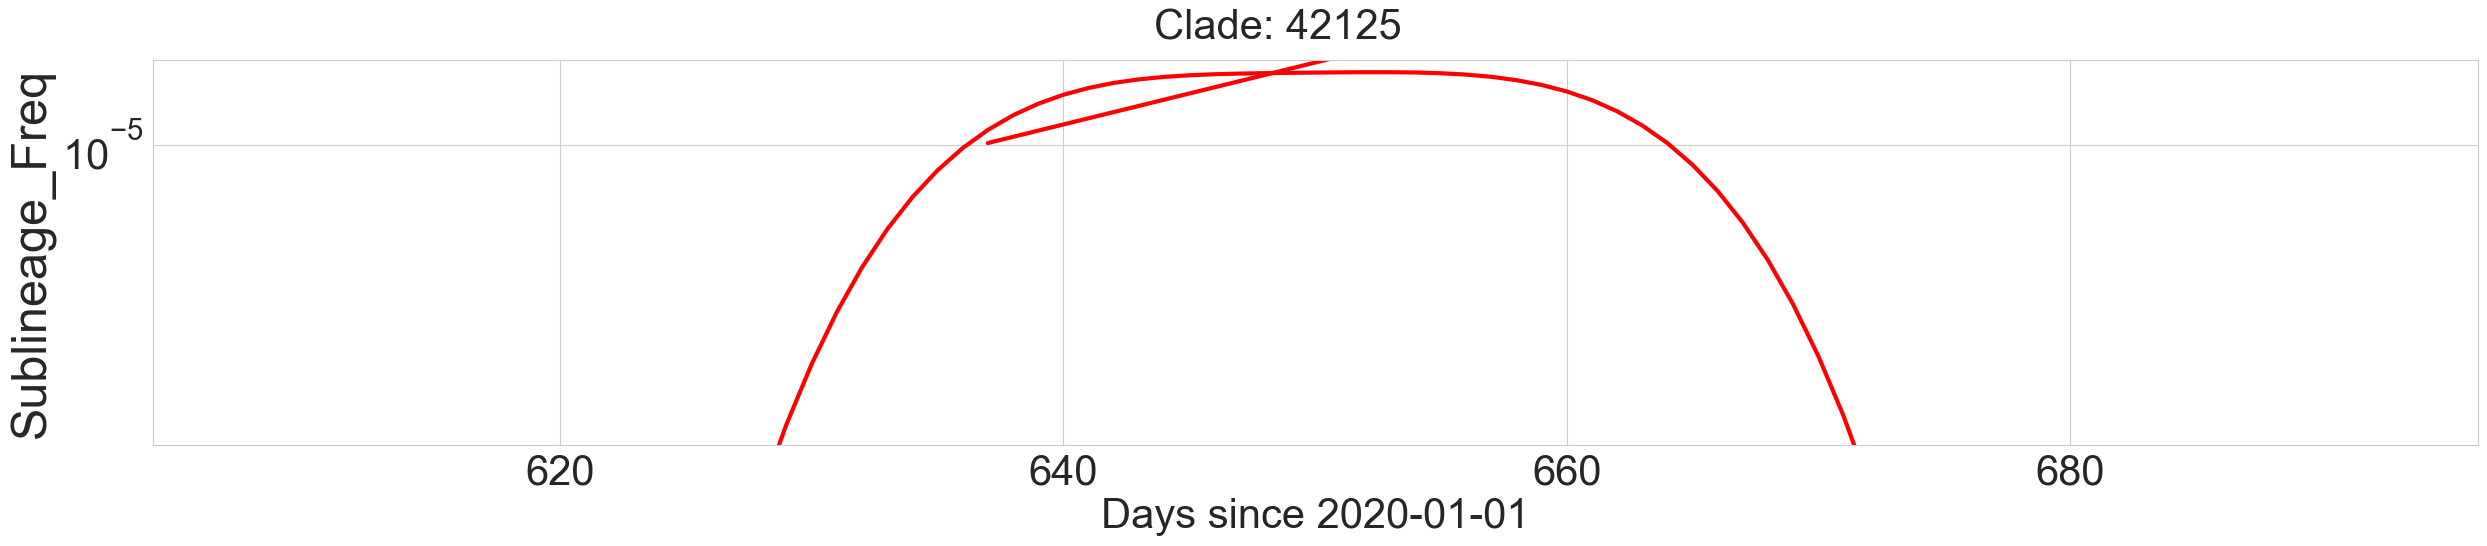

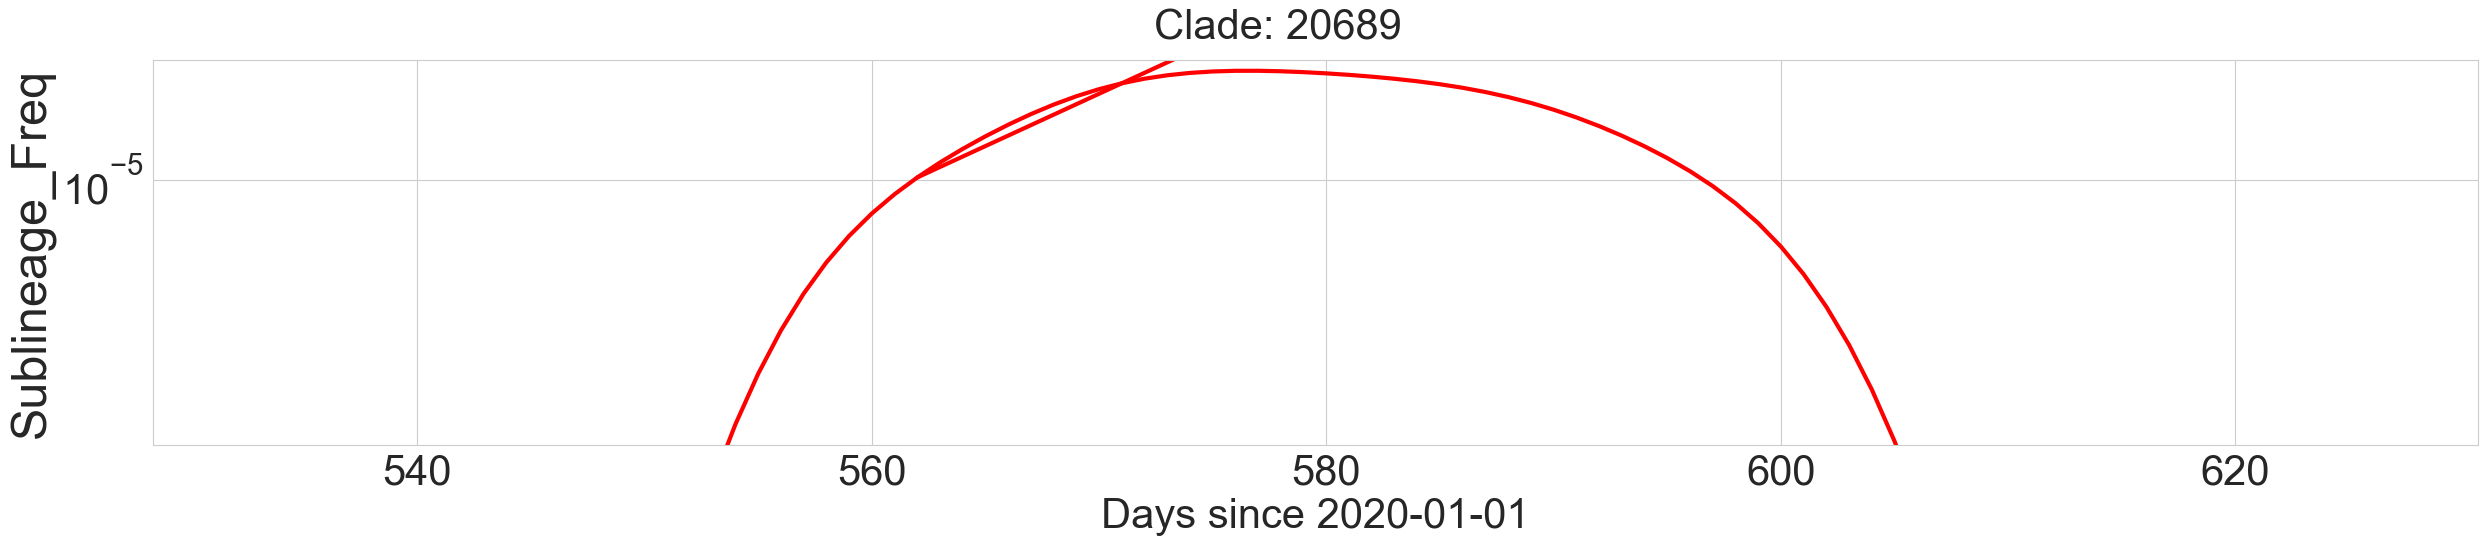

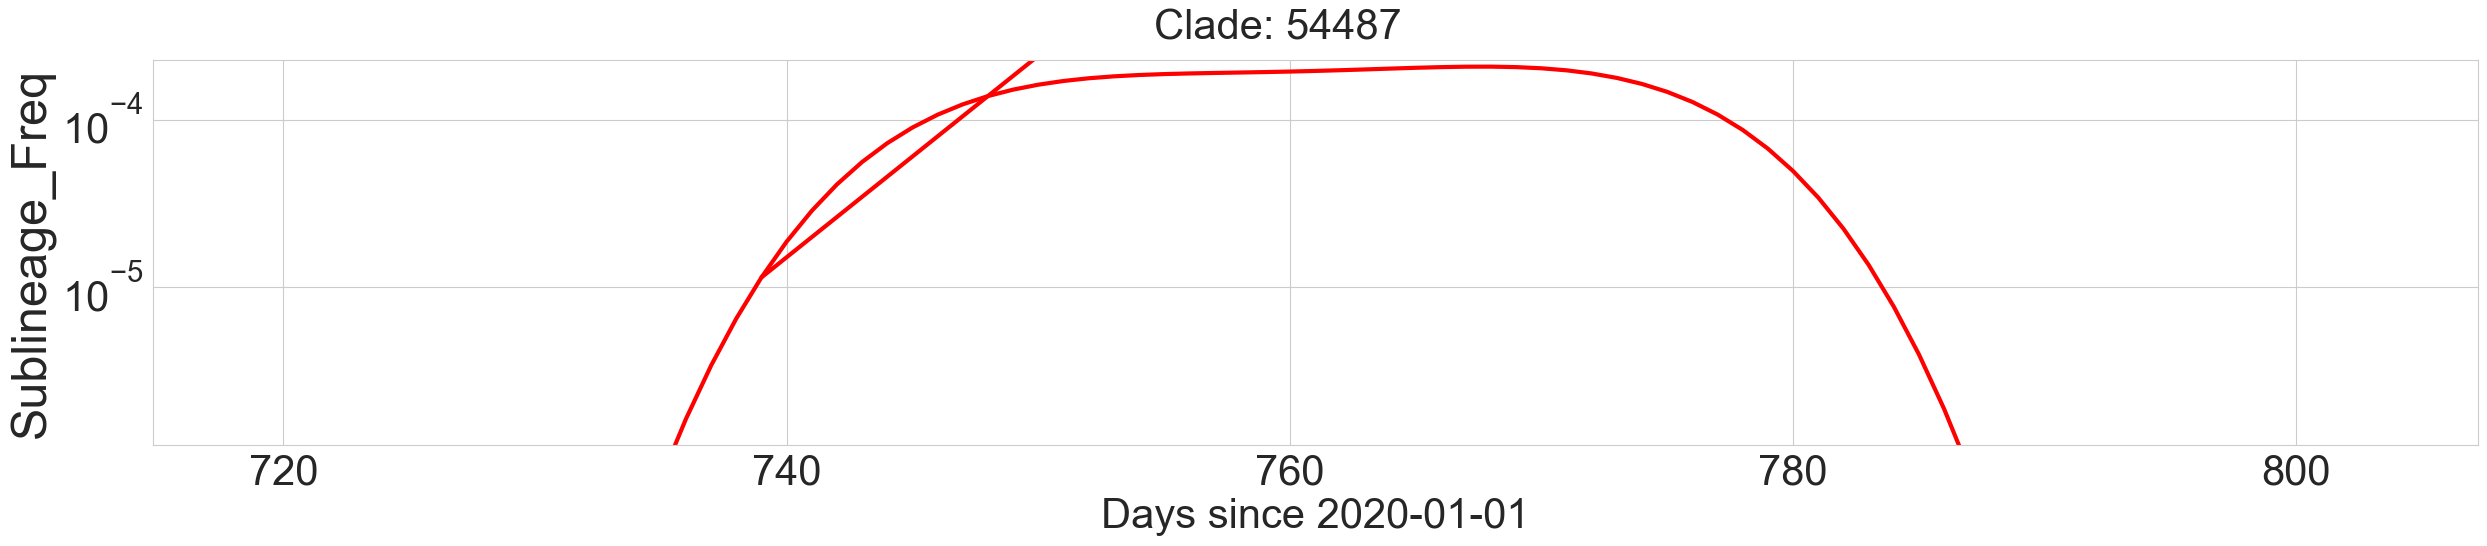

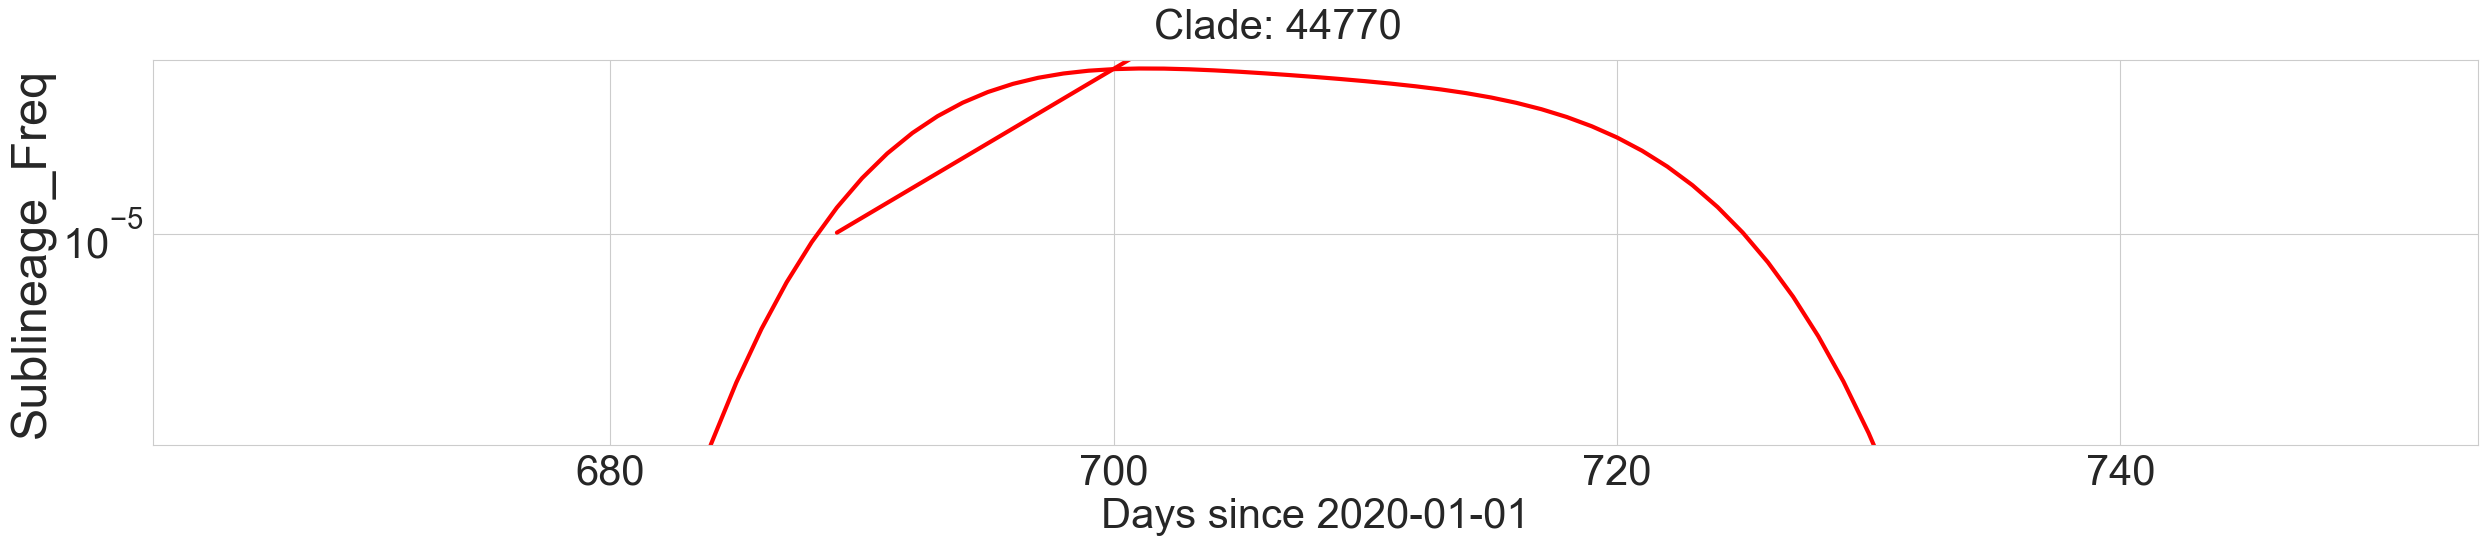

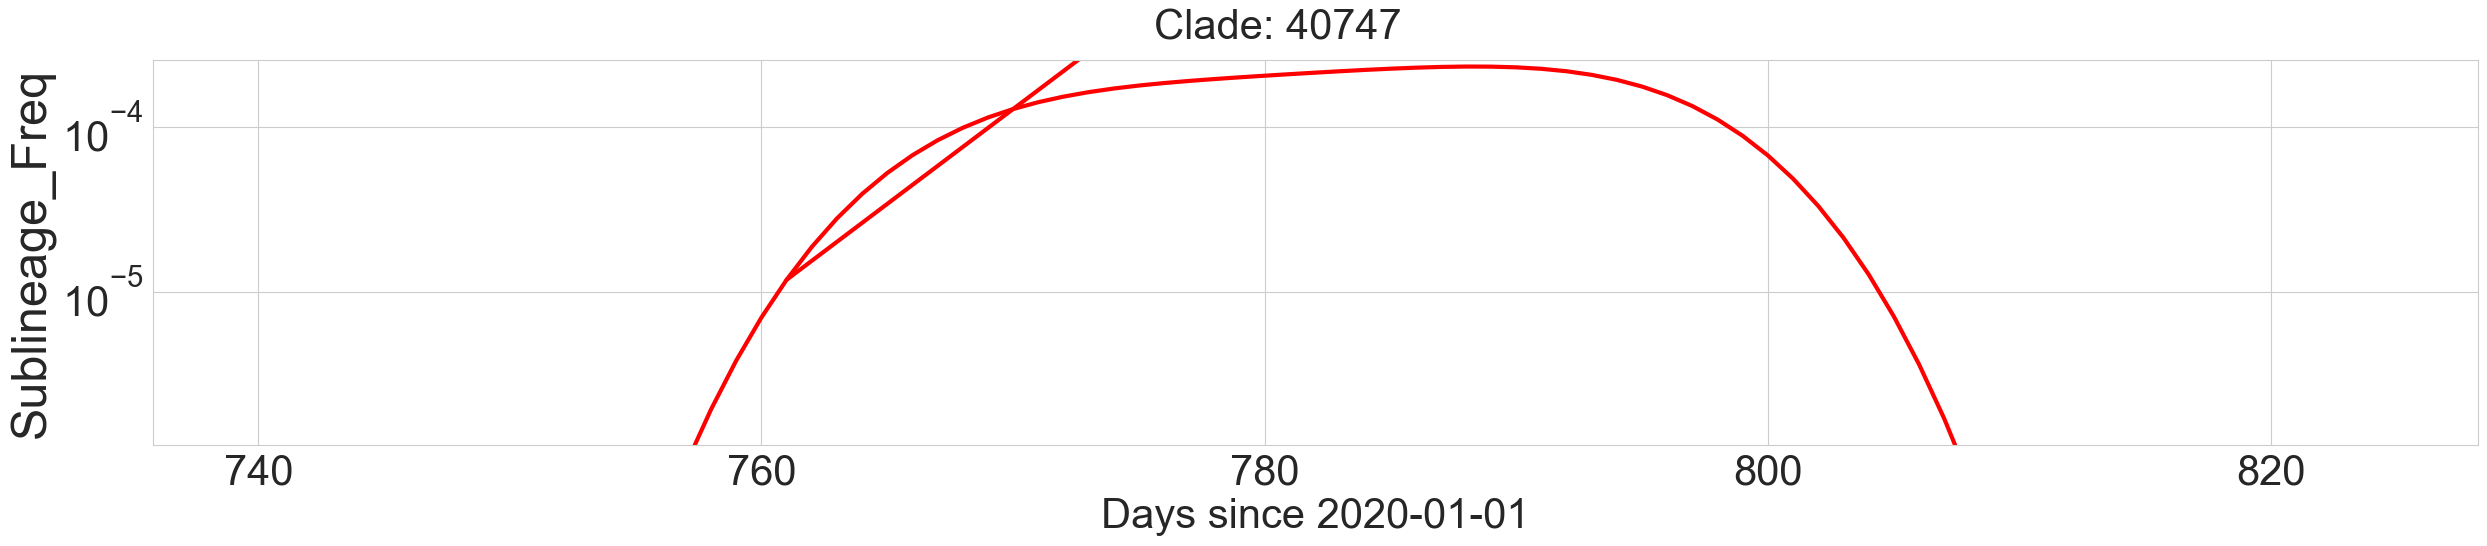

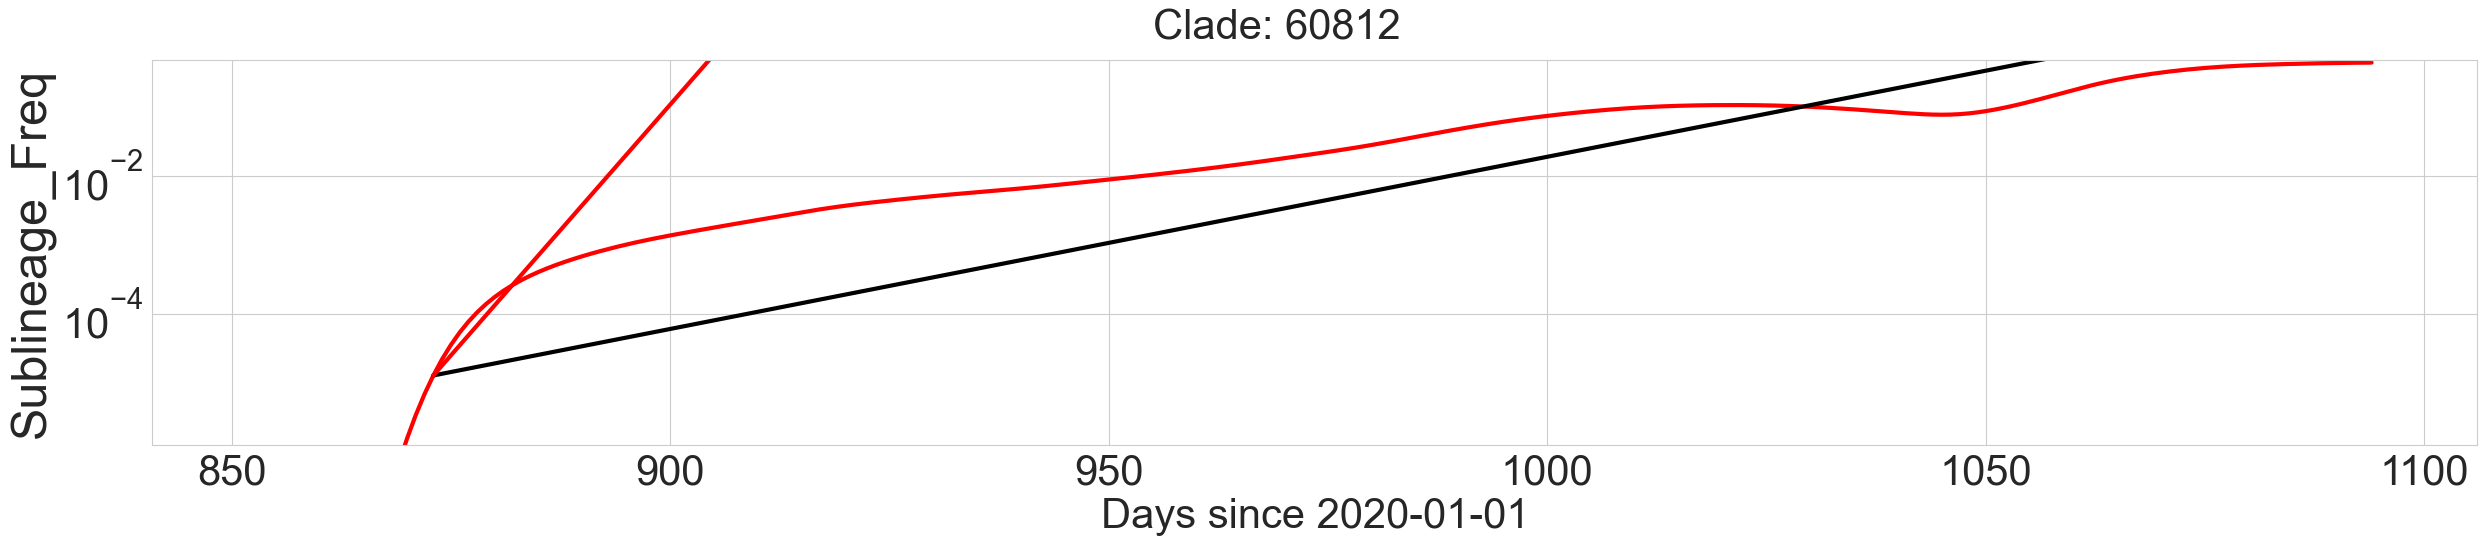

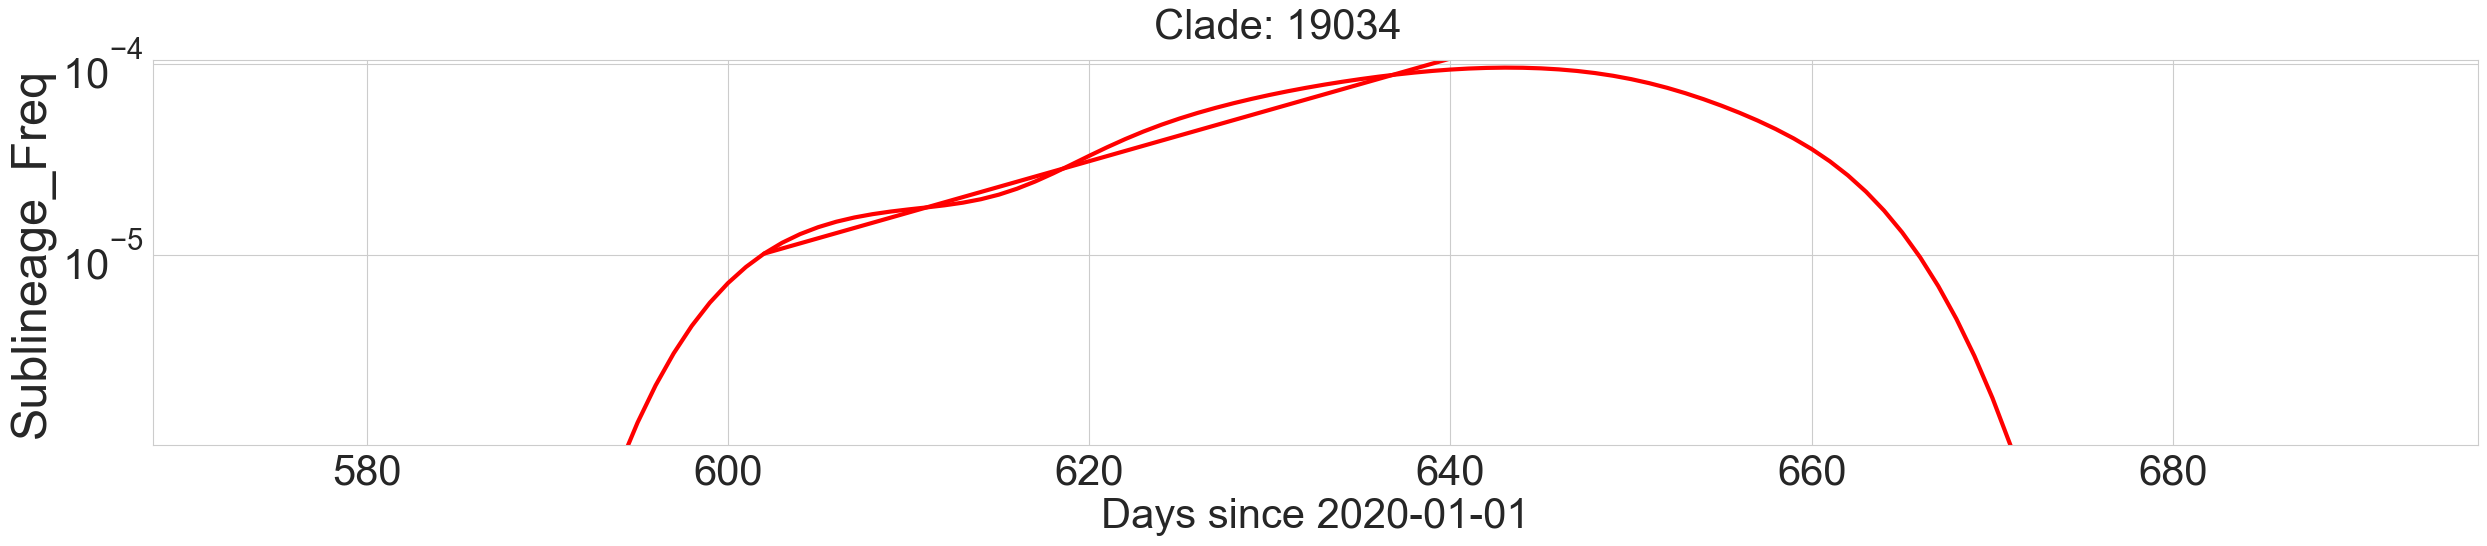

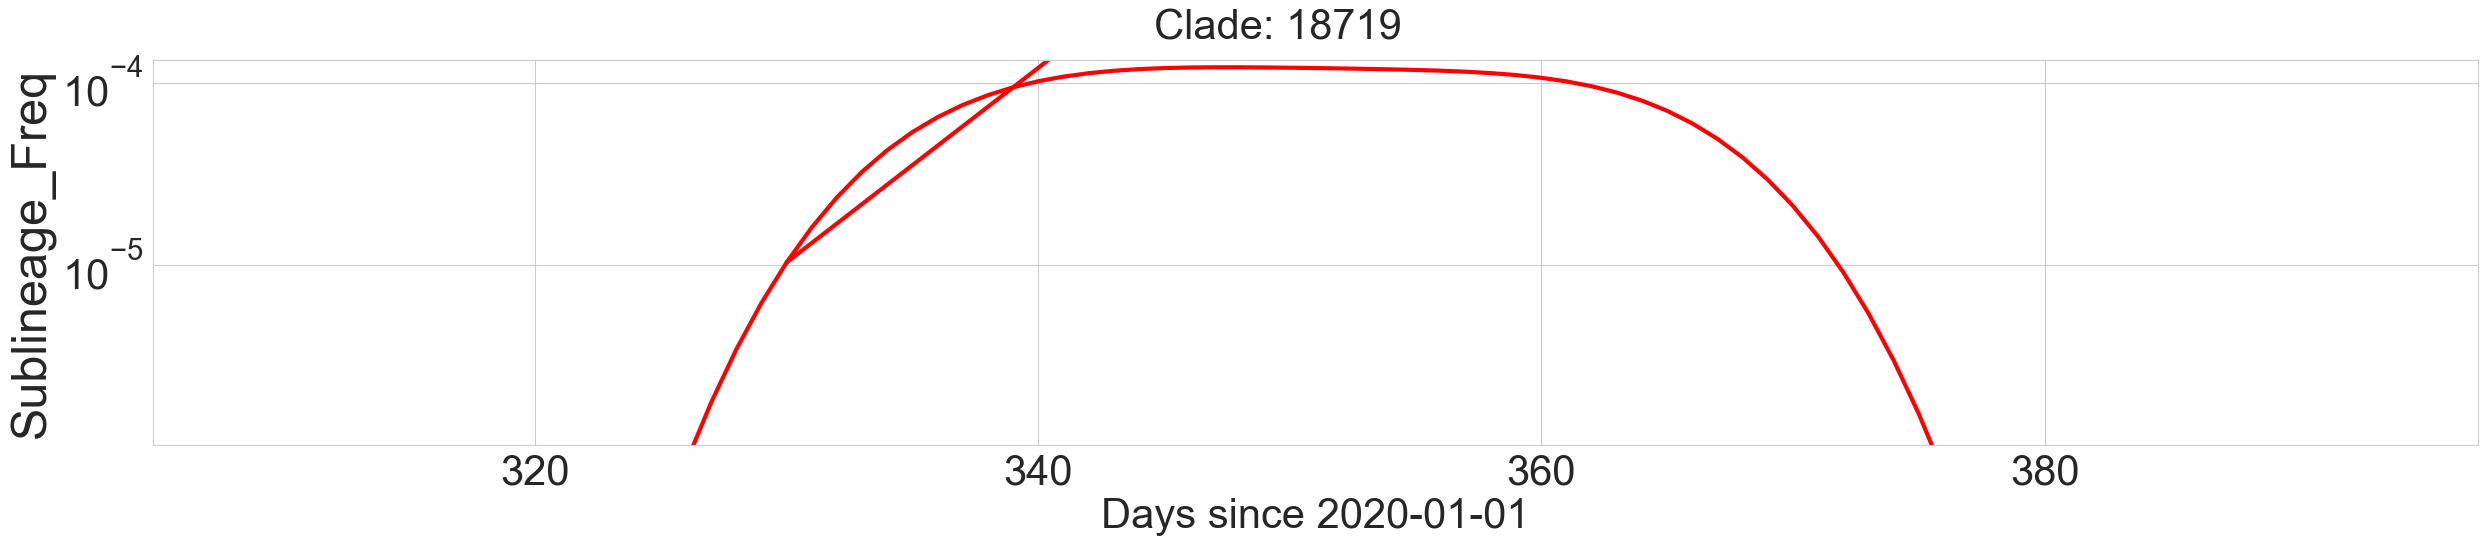

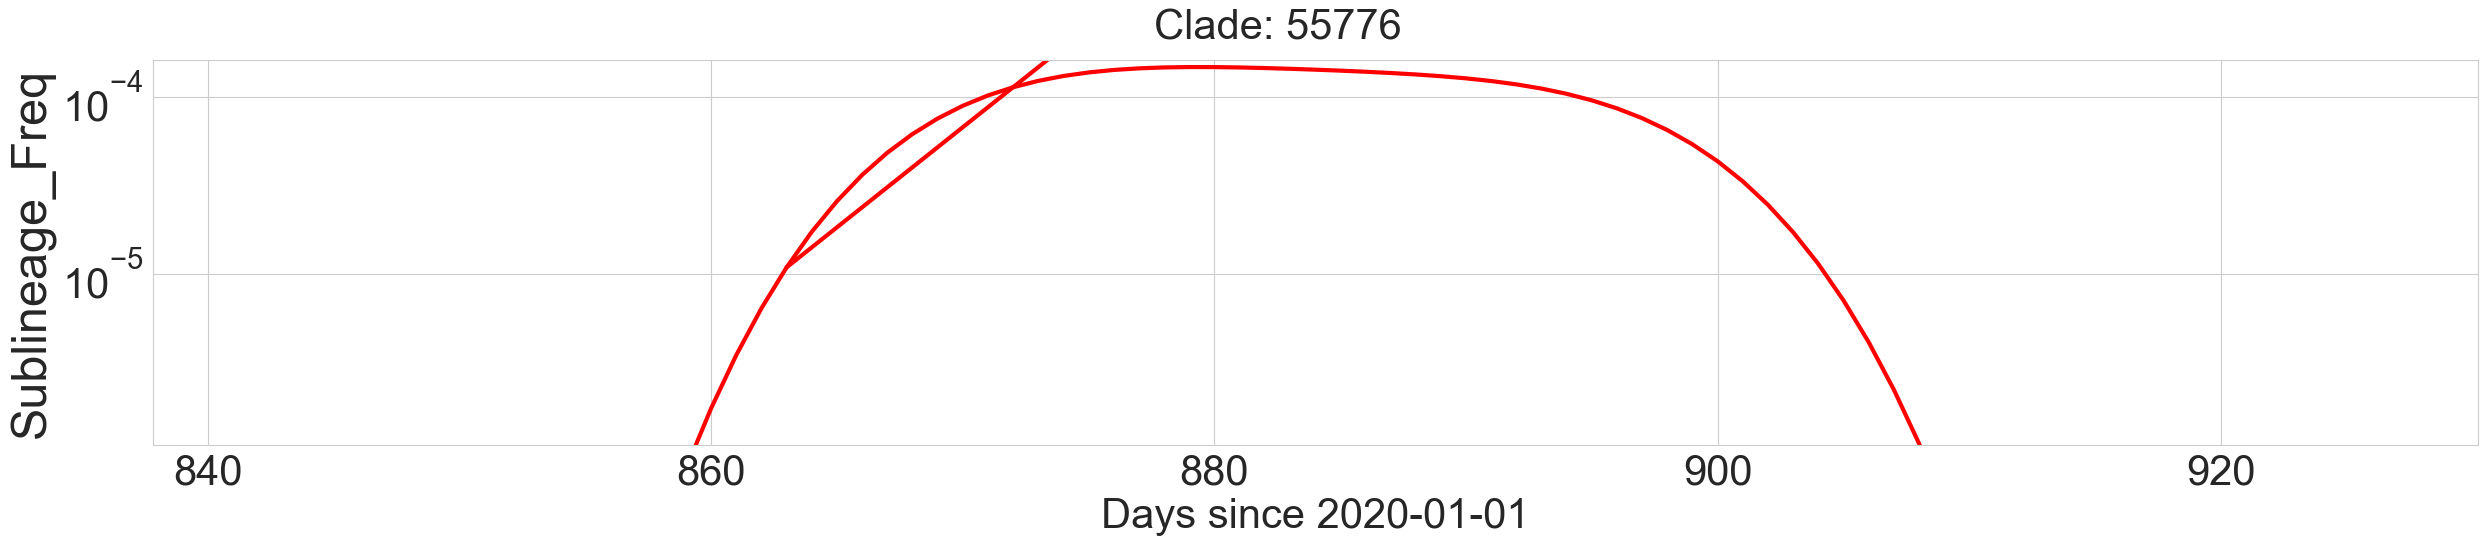

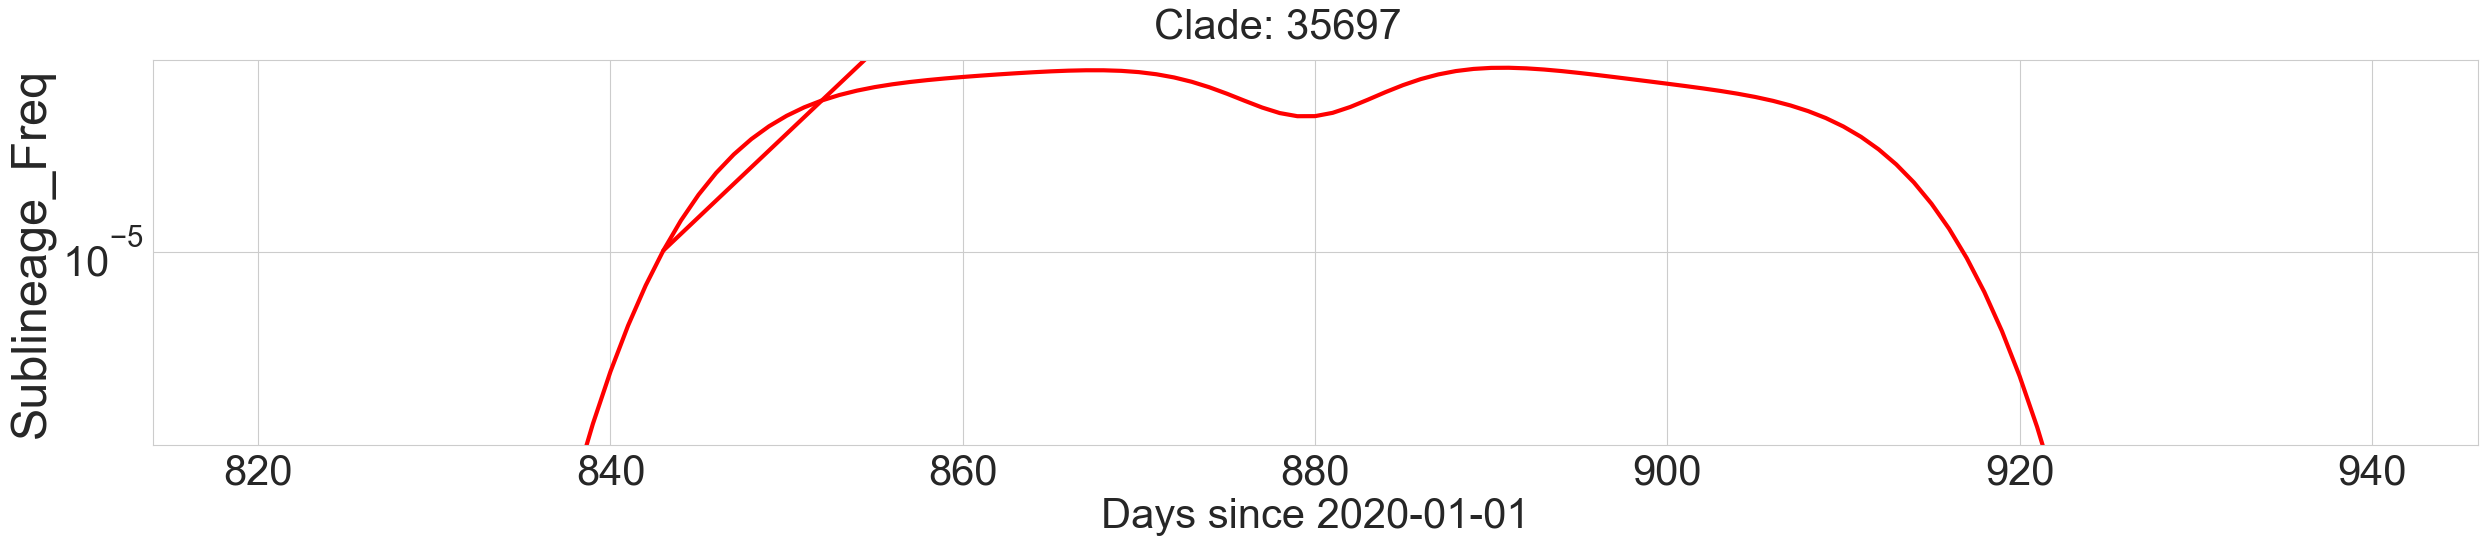

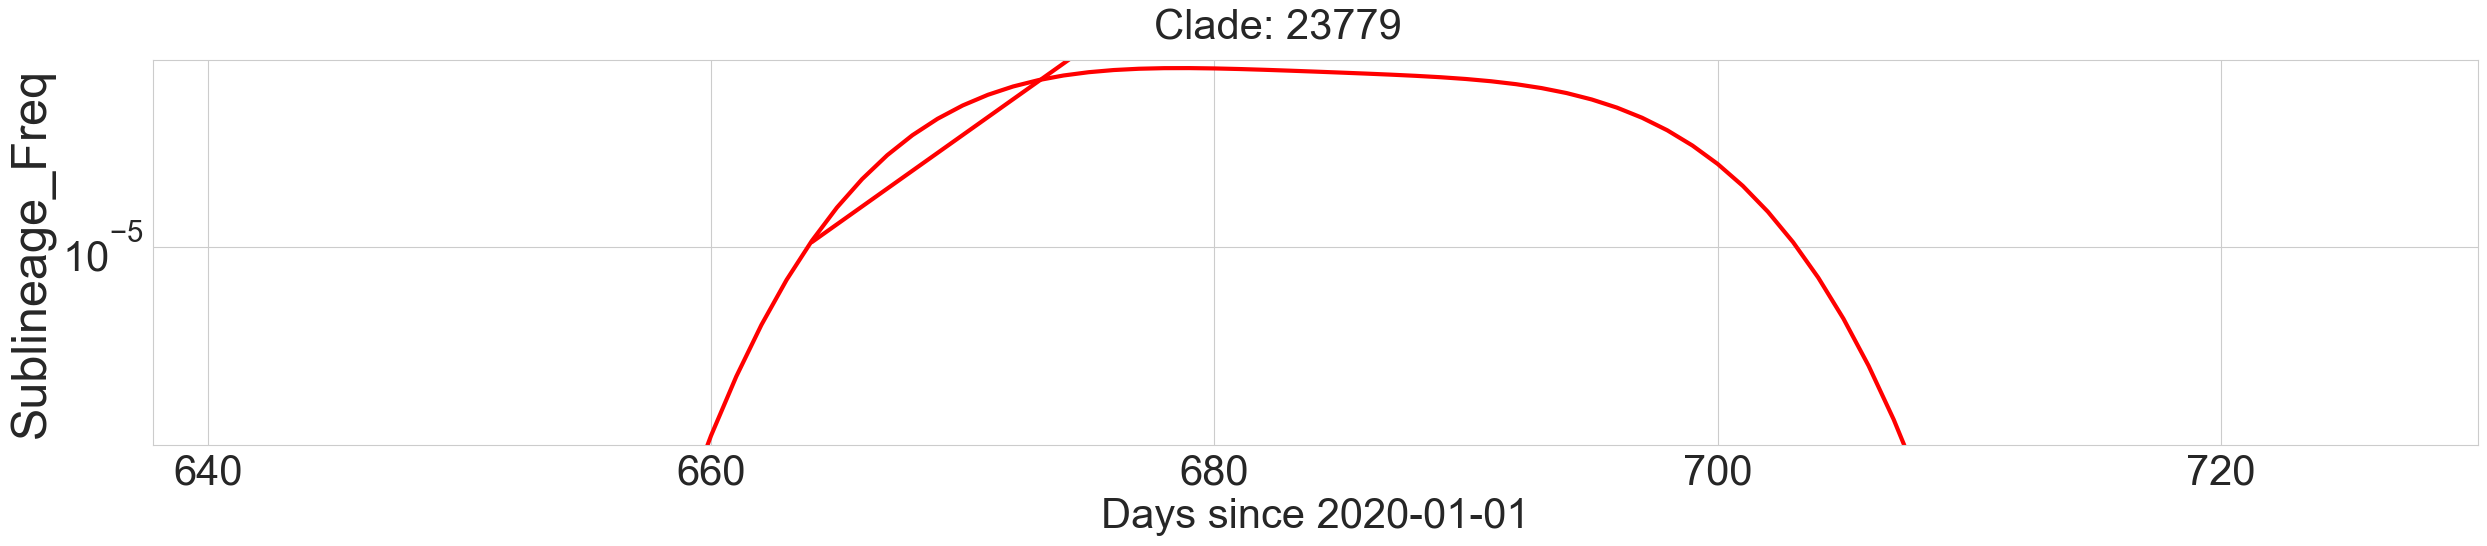

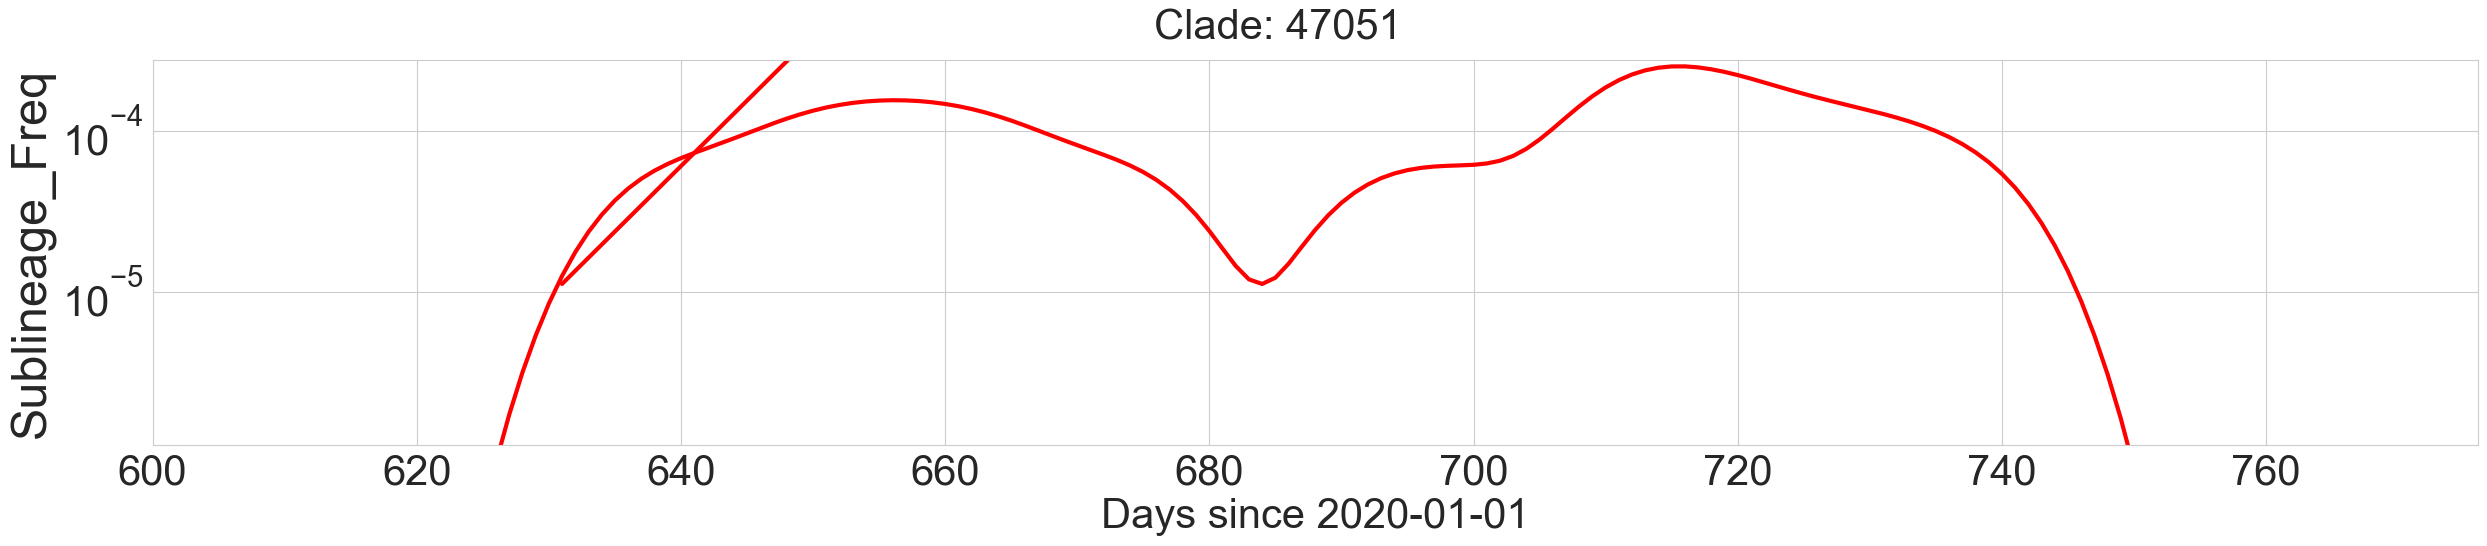

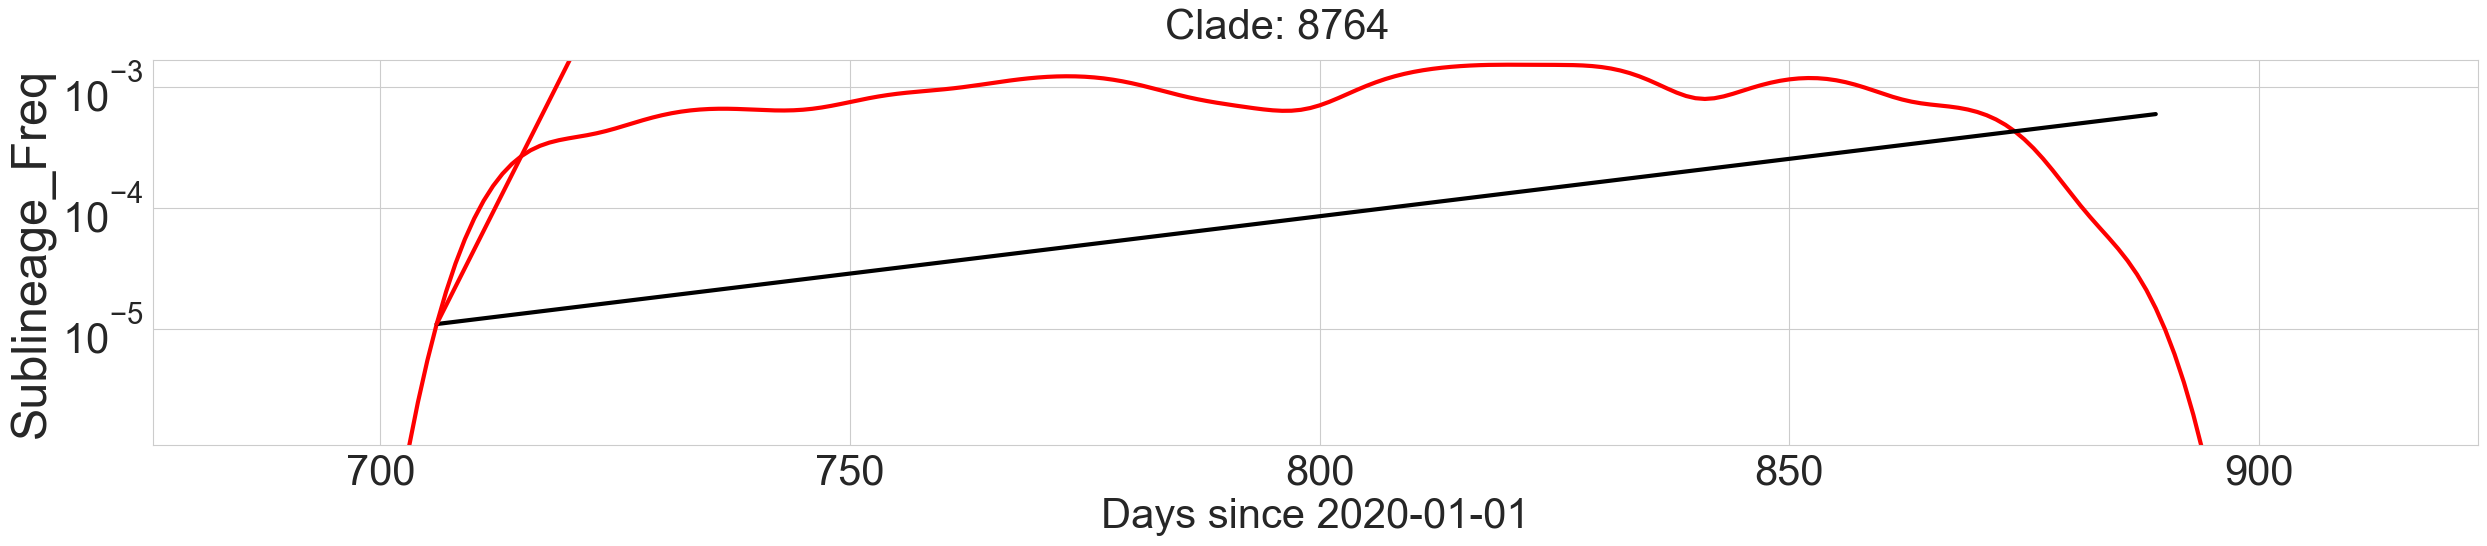

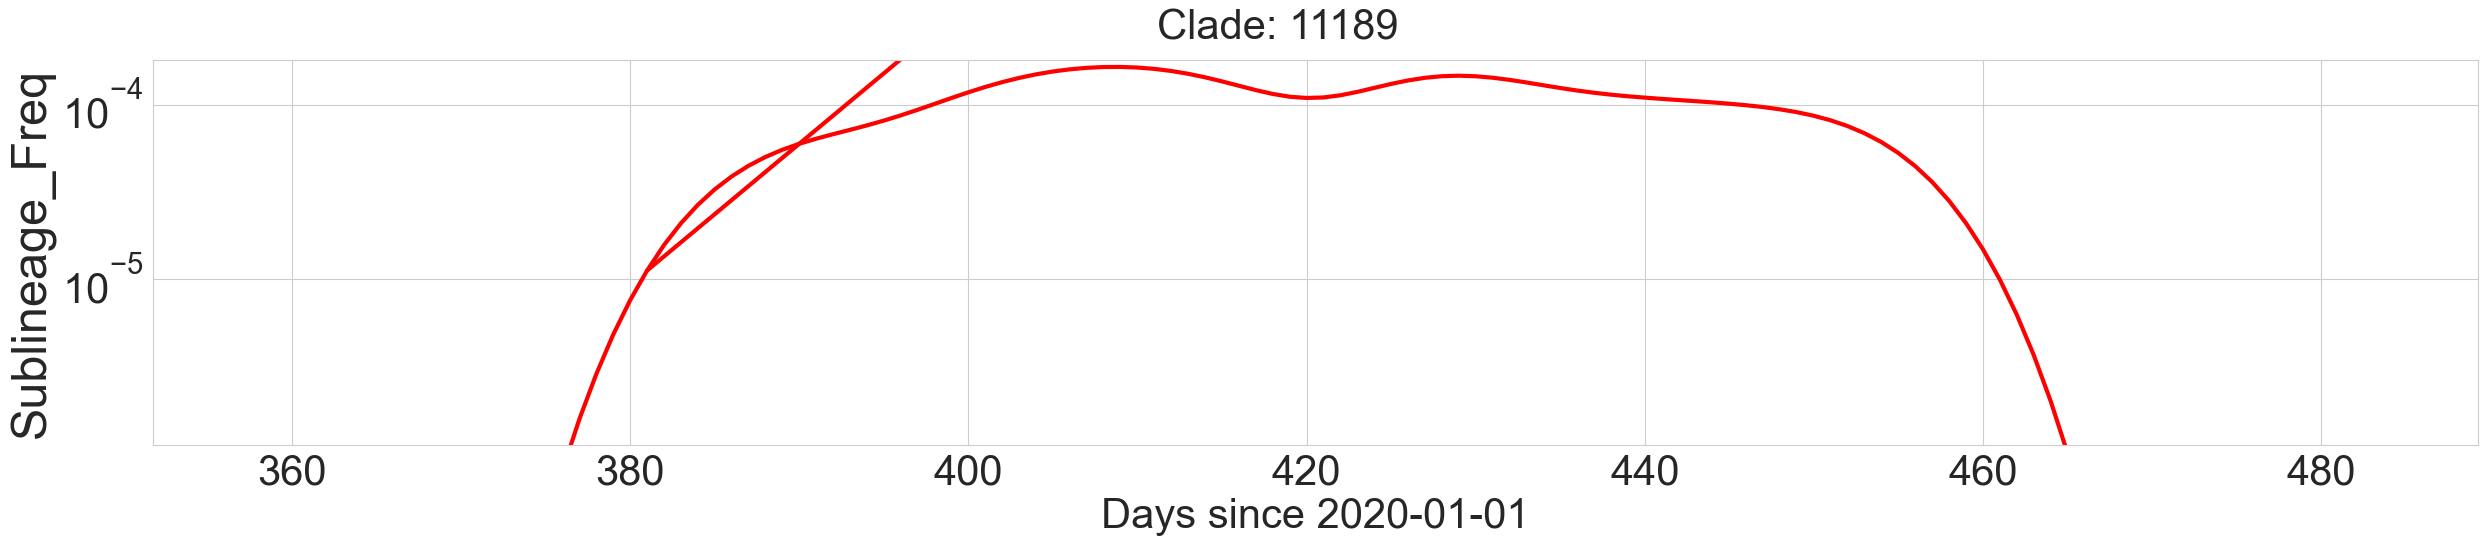

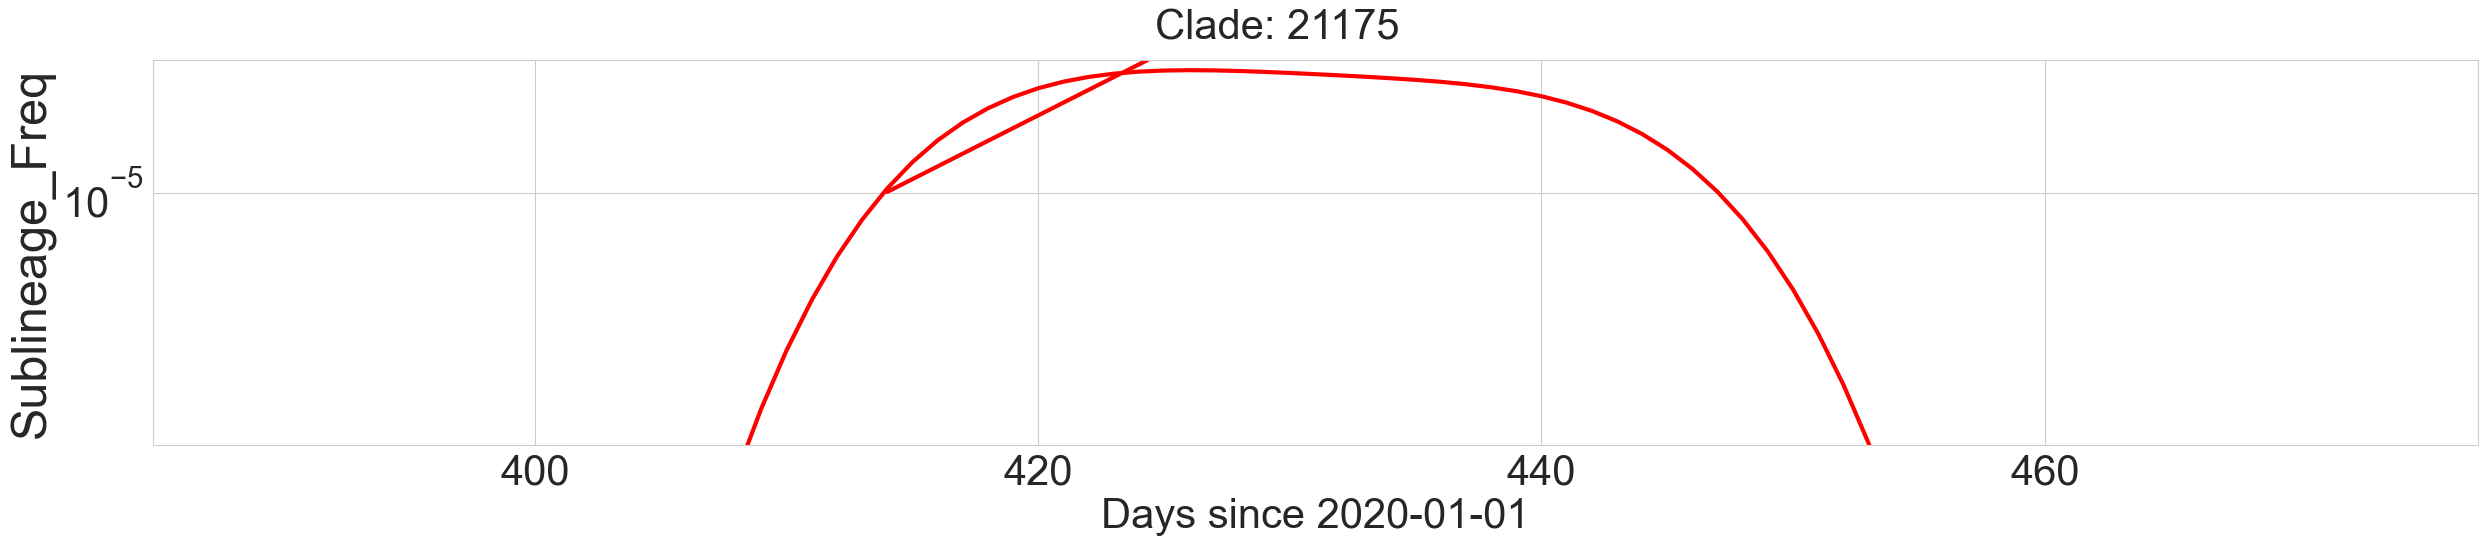

In [162]:
for i in range(20):
    random_clade = random.choice(nonsyn_S_clade_stats['Clade'].values)

    subset = nonsyn_S_clade_statistics_SARS_CoV_2_World[nonsyn_S_clade_statistics_SARS_CoV_2_World['Clade'] == random_clade][['day_diff', 'Sublineage_Freq']].values
    # subset = subset.dropna(subset=['day_diff', 'Sublineage_Freq'])
    #sort by day_diff
    subset = subset[subset[:,0].argsort()]
    x = subset[:,0]
    y = subset[:,1]
    
    try:
        x = x[y>1e-5]
        y = y[y>1e-5] 
        
        g_rate = np.average(np.log(y[1:10] * (1-y[:9]) / (y[:9]*(1-y[1:10]))) / (x[1:10] - x[:9]))
        print(g_rate, f'lifetime: {x[-1]-x[0]}')

        fig,ax = plt.subplots(1,figsize = (30,5))
        sns.lineplot(nonsyn_S_clade_statistics_SARS_CoV_2_World.query(
            f'Clade == {random_clade}'
        ), x = 'day_diff', y = 'Sublineage_Freq',color='red',ax=ax)
        # ax.plot(x,y,marker='o',linestyle='--')

        s= nonsyn_S_clade_stats.query(f'Clade == {random_clade}')['s'].values[0]
        print(s)
        ax.plot(x[:],y.min()*np.exp(s*(x[:]-x[0])),linestyle='-',color='black')
        ax.plot(x[:],y.min()*np.exp(g_rate*(x[:]-x[0])),linestyle='-',color='red')
        ax.set_ylim(np.min(y)*.1,np.max(y)*1.1) 
        ax.set_yscale('log')

        ax.set_xlabel('Days since 2020-01-01',fontsize=30)
        fig.suptitle(f'Clade: {random_clade}',fontsize=30)
    except IndexError:
        pass

(1e-05, 0.99999)

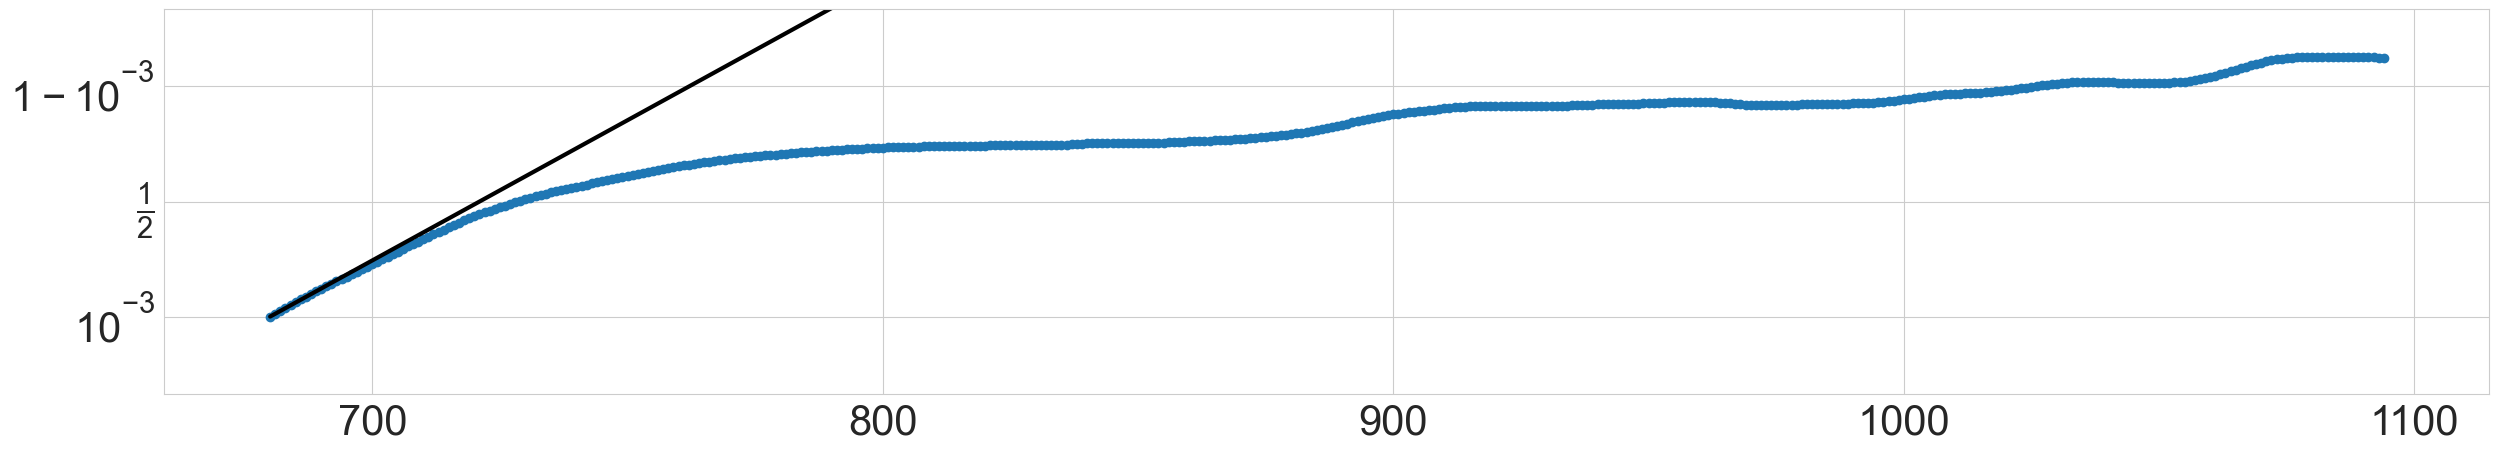

In [163]:
random_clade = random.choice(nonsyn_RBD_clade_stats.query('Max_Freq > .9')['Clade'].values)

subset = nonsyn_RBD_clade_statistics_SARS_CoV_2_World[nonsyn_RBD_clade_statistics_SARS_CoV_2_World['Clade'] == random_clade][['day_diff', 'Sublineage_Freq']].values
# subset = subset.dropna(subset=['day_diff', 'Sublineage_Freq'])
#sort by day_diff
subset = subset[subset[:,0].argsort()]
x = subset[:,0]
y = subset[:,1]
x = x[y>1e-3]
y = y[y>1e-3]
s= nonsyn_RBD_clade_stats.query(f'Clade == {random_clade}')['s'].values[0]
fig,ax = plt.subplots(1,figsize = (30,5))
ax.plot(x,y,marker='o',linestyle='--')
ax.plot(x,y.min()*np.exp(s*(x-x[0]))/(1 +y.min()*np.exp(s*(x-x[0]))),linestyle='-',color='black')
ax.set_yscale('logit')
ax.set_ylim(1e-5,1-1e-5)

In [164]:
y[0]*np.exp(s*x[1:])

array([4.27068654e+46, 5.05068143e+46, 5.97313398e+46, 7.06406255e+46,
       8.35423747e+46, 9.88004894e+46, 1.16845334e+47, 1.38185876e+47,
       1.63424037e+47, 1.93271677e+47, 2.28570667e+47, 2.70316636e+47,
       3.19687058e+47, 3.78074455e+47, 4.47125681e+47, 5.28788369e+47,
       6.25365868e+47, 7.39582206e+47, 8.74658928e+47, 1.03440596e+48,
       1.22332906e+48, 1.44675694e+48, 1.71099150e+48, 2.02348567e+48,
       2.39305353e+48, 2.83011897e+48, 3.34700971e+48, 3.95830497e+48,
       4.68124673e+48, 5.53622601e+48, 6.54735805e+48, 7.74316246e+48,
       9.15736766e+48, 1.08298622e+49, 1.28078199e+49, 1.51470302e+49,
       1.79134721e+49, 2.11851747e+49, 2.50544187e+49, 2.96303383e+49,
       3.50420004e+49, 4.14420442e+49, 4.90109871e+49, 5.79623159e+49,
       6.85485084e+49, 8.10681550e+49, 9.58743801e+49, 1.13384803e+50,
       1.34093315e+50, 1.58584015e+50, 1.87547677e+50, 2.21801239e+50,
       2.62310846e+50, 3.10219096e+50, 3.66877271e+50, 4.33883453e+50,
      

In [165]:
average_infected_size = covid_data_World['weekly_new_cases_smoothed'].mean()
average_s = nonsyn_S_clade_stats.query('day_diff < 400')['s_w'].mean()

print(f'N = {average_infected_size:.1e}, s = {average_s:.1e}, Ns = {average_infected_size*average_s:.1e}')

N = 4.5e+06, s = 4.4e-01, Ns = 2.0e+06


In [166]:
syn_clade_stats['s_w'] = syn_clade_stats['selection']*7
nonsyn_all_clade_stats['s_w'] = nonsyn_all_clade_stats['s']*7
bins = np.linspace(0,5,100)
fig,ax= plt.subplots(1,figsize = (10,10))
plt.hist(syn_clade_stats['s_w'].values[~np.isnan(syn_clade_stats['s_w'])],bins = bins,density= True, label = 'Synonymous',color='steelblue',alpha=1,fill=False,cumulative=-1, histtype = 'step',lw = 2);

plt.hist(nonsyn_S_clade_stats['s_w'].values[~np.isnan(nonsyn_S_clade_stats['s_w'])],bins = bins,density= True, label = 'Nonsynonymous Spike',color='red',alpha=1,fill=False,cumulative=-1, histtype = 'step',lw = 2);

plt.hist(nonsyn_RBD_clade_stats['s_w'].values[~np.isnan(nonsyn_RBD_clade_stats['s_w'])],bins = bins,density= True, label = 'Nonsynonymous RBD',color='green',alpha=1,fill=False,cumulative=-1, histtype = 'step',lw = 2);

plt.hist(syn_clade_stats['s_w'].values[~np.isnan(syn_clade_stats['s_w'])],bins = bins,density= True, label = 'Synonymous',color='steelblue',alpha=1,fill=False,cumulative=-1, histtype = 'step',lw = 2);

plt.hist(nonsyn_all_clade_stats['s_w'].values[~np.isnan(nonsyn_all_clade_stats['s_w'])],bins = bins,density= True, label = 'Nonsynonymous',color='orange',alpha=1,fill=False,cumulative=-1, histtype = 'step',lw = 2);

# ax.set_xlim(left=.39,right=.6)
ax.set_yscale('log')
ax.legend(loc='best',fontsize=20)

sarr = np.linspace(0,.1,100)
ax.plot(sarr, np.exp(- sarr/np.average(nonsyn_S_clade_stats['s_w'].values[~np.isnan(nonsyn_S_clade_stats['s_w'])]) )
,linestyle='--',color='orange')

ax.set_xlabel('Selection coefficient, [week]^{-1}',fontsize=20)
ax.set_ylabel(r'$P(S>s),$ Inverse cumulative density',fontsize=20)

ax.tick_params(axis='both', which='major', labelsize=20)

In [167]:
reference_date

Timestamp('2020-01-01 00:00:00')

In [168]:
reference_date = pd.to_datetime('2020-01-01')
syn_clade_statistics_SARS_CoV_2_World['day_diff'] = (pd.to_datetime(syn_clade_statistics_SARS_CoV_2_World['Time']) - reference_date).dt.days
nonsyn_all_clade_statistics_SARS_CoV_2_World['day_diff'] = (pd.to_datetime(nonsyn_all_clade_statistics_SARS_CoV_2_World['Time']) - reference_date).dt.days
nonsyn_S_clade_statistics_SARS_CoV_2_World['day_diff'] = (pd.to_datetime(nonsyn_S_clade_statistics_SARS_CoV_2_World['Time']) - reference_date).dt.days

def initial_growth(clade,df):
    x = np.sort(df.query(f'Clade=={clade}')['day_diff'].values)
    y = np.sort(df.query(f'Clade=={clade}')['Sublineage_Freq'].values)
    g_rate = np.average(np.log(y[1:10]/y[:9])/(x[1:10]-x[:9]))
    return g_rate

In [169]:
randind = rnd.randint(0,len(syn_clade_stats))
clade = syn_clade_stats.iloc[randind]['Clade']
x = np.sort(syn_clade_statistics_SARS_CoV_2_World.query(f'Clade=={clade}')['day_diff'].values)
y = np.sort(syn_clade_statistics_SARS_CoV_2_World.query(f'Clade=={clade}')['Sublineage_Freq'].values)

fitfunc = lambda x,b: np.exp(b*x)
from time import time
t0 = time()
popt, pcov = so.curve_fit(fitfunc, x[:10]-x[0],y[:10]/y[0])
b = popt
print(time()-t0)
t1 = time()
g_rate = np.average(np.log(y[1:10]/y[:9])/(x[1:10]-x[:9]))
print(time()-t1)
fig,ax = plt.subplots(1,figsize = (30,10))
plt.plot(x,y)
ax.plot(x,y[0]*fitfunc(x-x[0],b))
ax.plot(x,y[0]*np.exp(g_rate*(x-x[0])))
ax.set_yscale('log')
ax.set_ylim(1e-19,1)


0.00032901763916015625
5.4836273193359375e-05


(1e-19, 1)

In [170]:
colors_xmin = dict(zip(xmin_vals, sns.color_palette('viridis',len(xmin_vals))))

NameError: name 'xmin_vals' is not defined

In [ ]:
wt_alpha_crossover_date = pd.to_datetime('2021-03-15')
alpha_delta_crossover_date = pd.to_datetime('2021-06-21')
delta_ba1_crossover_date = pd.to_datetime('2022-01-03')
ba1_ba2_crossover_date = pd.to_datetime('2022-01-31')
ba2_ba5_crossover_date = pd.to_datetime('2022-06-06')
ba5_xbb_crossover_date = pd.to_datetime('2023-02-27')

In [ ]:
xmin_vals =[0]+ list(np.logspace(-7,0,20))

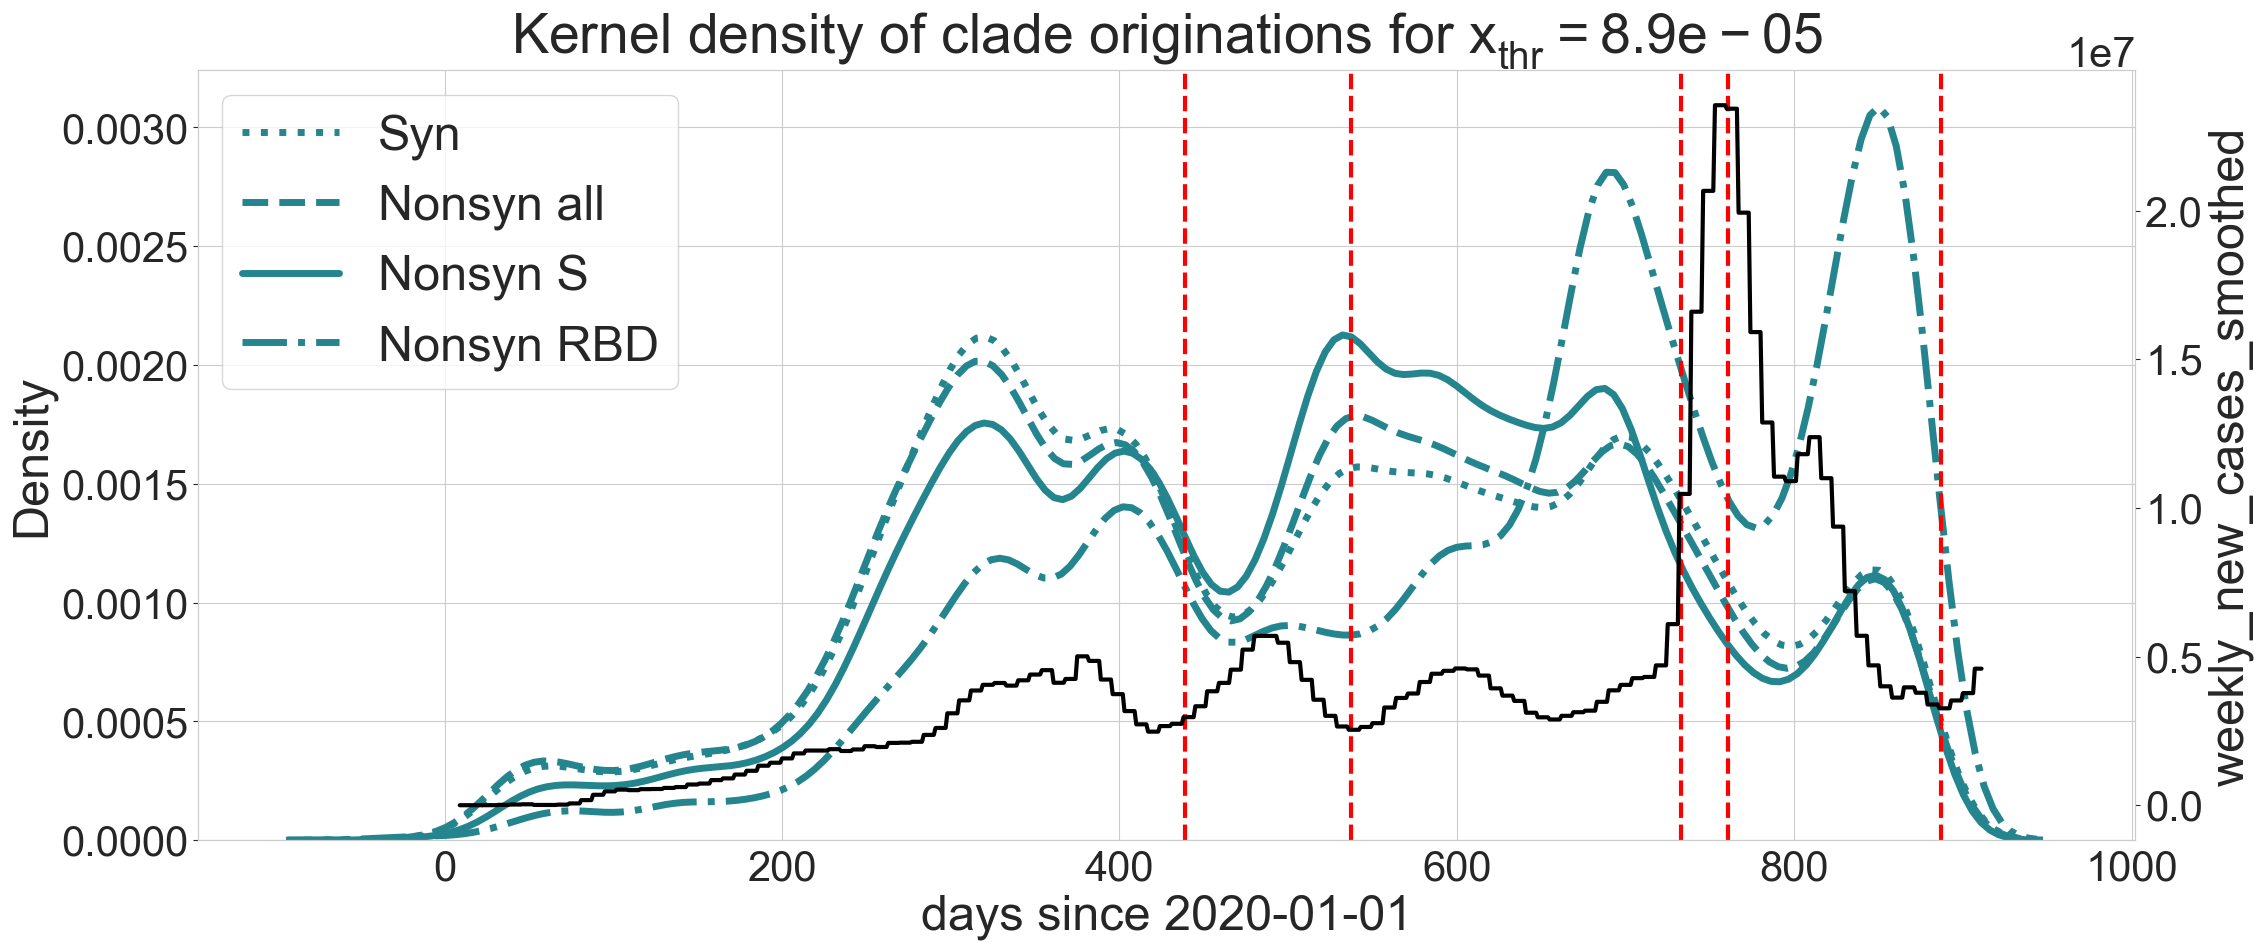

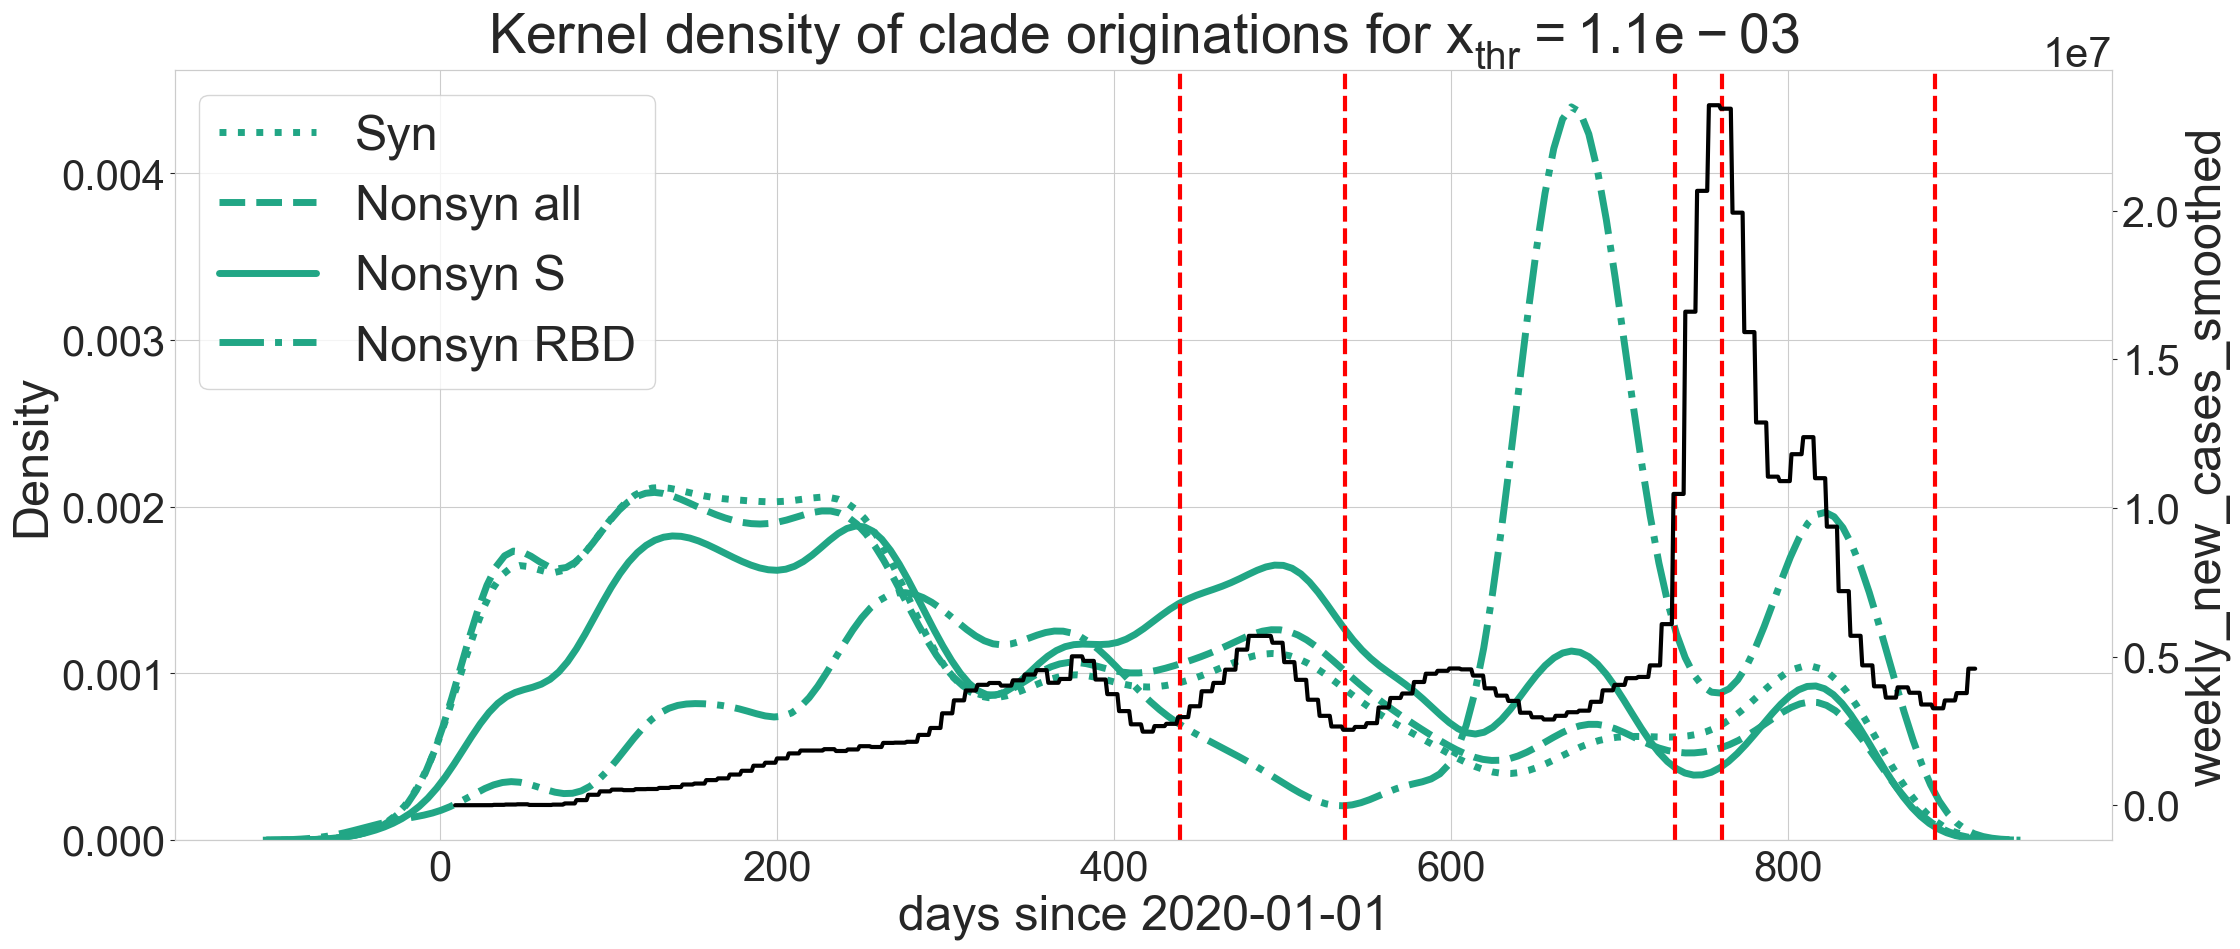

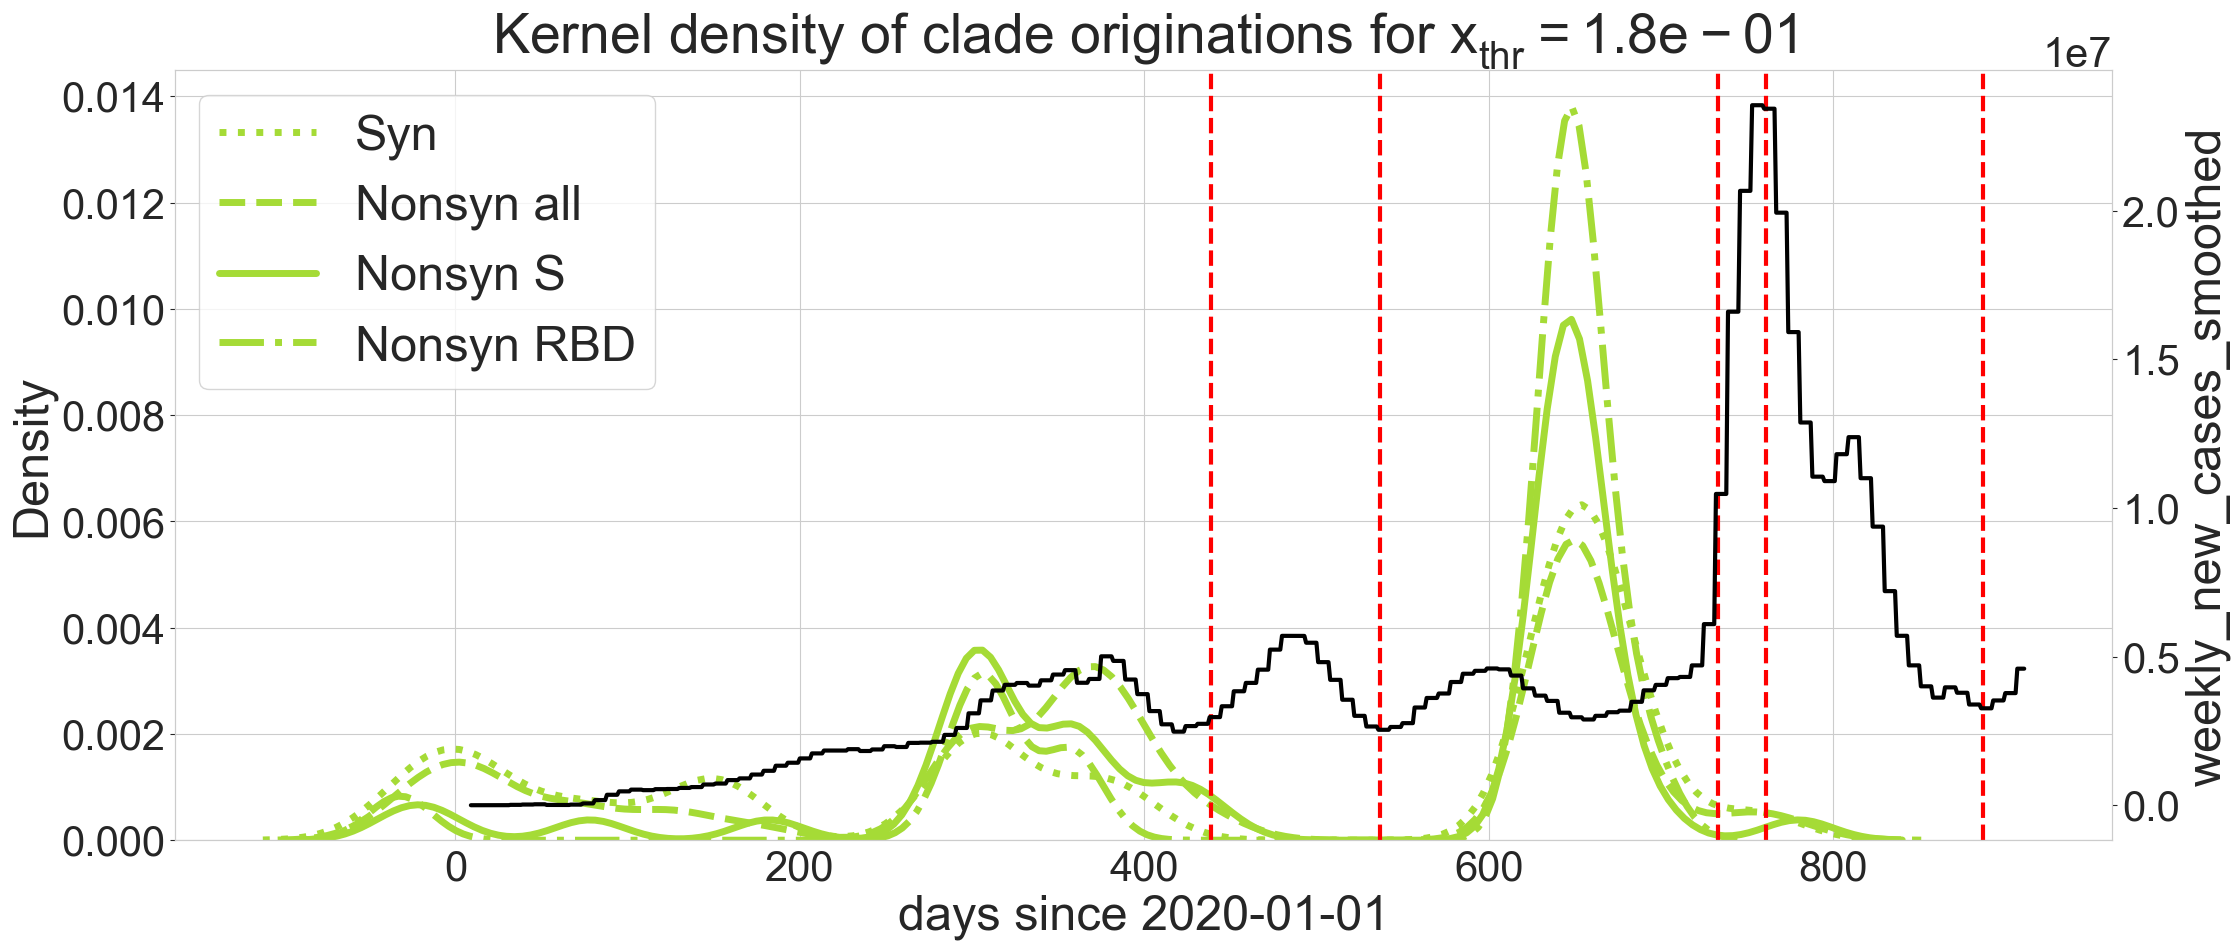

In [ ]:
fig,ax= plt.subplots(1,1,figsize=(25,10))
sns.kdeplot(syn_clade_stats['day_diff'], bw_method=0.1,label='Syn', color='blue',ls=':',ax=ax,lw=5)
# sns.kdeplot(nonsyn_all_clade_stats['day_diff'], bw_method=0.1,label='Nonsyn all',ax=ax,lw=5,ls='--', color='blue')
# sns.kdeplot(nonsyn_S_clade_stats['day_diff'], bw_method=0.1,label='Nonsyn S',ax=ax,lw=5,ls='-', color='blue')
# sns.kdeplot(nonsyn_RBD_clade_stats['day_diff'], bw_method=0.1,label='Nonsyn RBD',ax=ax,lw=5,ls='-.', color='blue')

ax.set_xlabel(f'days since {reference_date.date()}')
ax.set_title('Kernel density of clade originations for $x_{thr}=0$')
tax = ax.twinx()
tax.grid(False)
sns.lineplot(data = covid_data_World, x = 'day_diff', y = 'weekly_new_cases_smoothed', ax = tax ,color='black')
ax.legend(loc='best')

for date in [wt_alpha_crossover_date,alpha_delta_crossover_date,delta_ba1_crossover_date,ba1_ba2_crossover_date,ba2_ba5_crossover_date]:
    ax.axvline((date-reference_date).days, color='r',ls='--')

for xmin in xmin_vals[9::3]:
    
    fig,ax= plt.subplots(1,1,figsize=(25,10))
    sns.kdeplot(syn_clade_stats.query(f'Max_Freq > {xmin}')['day_diff'], bw_method=0.1,color=colors_xmin[xmin],ax=ax,lw=5,ls=':',label='Syn')

    sns.kdeplot(nonsyn_all_clade_stats.query(f'Max_Freq > {xmin}')['day_diff'], bw_method=0.1,color=colors_xmin[xmin],ax=ax,lw=5,ls='--',label='Nonsyn all')

    sns.kdeplot(nonsyn_S_clade_stats.query(f'Max_Freq > {xmin}')['day_diff'], bw_method=0.1,
    color=colors_xmin[xmin],ax=ax,lw=5,ls='-',label='Nonsyn S')

    sns.kdeplot(nonsyn_RBD_clade_stats.query(f'Max_Freq > {xmin}')['day_diff'], bw_method=0.1,
    color=colors_xmin[xmin],ax=ax,lw=5,ls='-.',label='Nonsyn RBD')
    tax = ax.twinx()
    sns.lineplot(data = covid_data_World, x = 'day_diff', y = 'weekly_new_cases_smoothed', ax = tax ,color='black')
    ax.legend(loc='best')
    ax.set_xlabel(f'days since {reference_date.date()}')
    ax.set_title(f'Kernel density of clade originations for $x_{{thr}}={xmin:.1e}$')
    for date in [wt_alpha_crossover_date,alpha_delta_crossover_date,delta_ba1_crossover_date,ba1_ba2_crossover_date,ba2_ba5_crossover_date]:
        ax.axvline((date-reference_date).days, color='r',ls='--')
    tax.grid(False)

In [ ]:
immune_classes = pd.read_csv(os.getcwd()+'/data/immune_classes.txt',sep='\t')

In [ ]:
h,b = np.histogram(syn_clade_stats['day_diff'], bins = np.sort(covid_data_World['day_diff'].unique()),density=True)

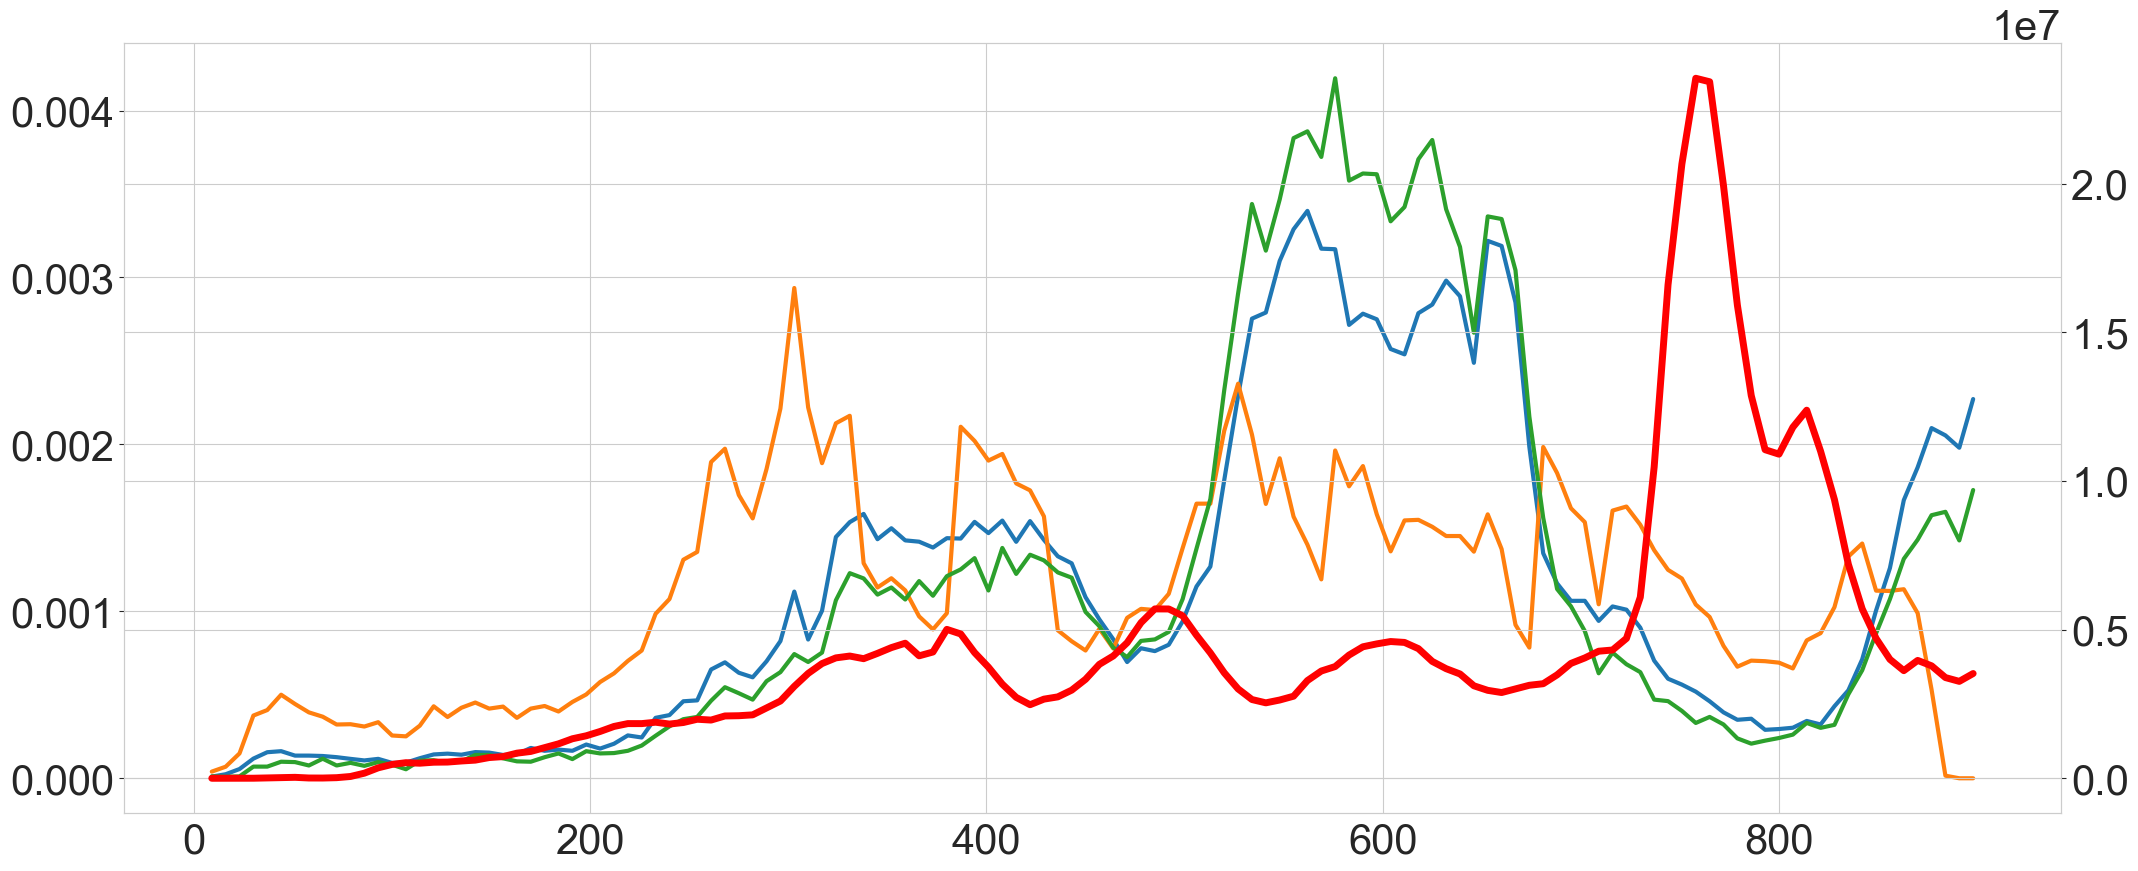

In [ ]:
fig,ax= plt.subplots(1,figsize=(25,10))
day_diff = covid_data_World['day_diff'][~np.isnan(covid_data_World['weekly_new_cases_smoothed'])][::7].values
cases = covid_data_World['weekly_new_cases_smoothed'][~np.isnan(covid_data_World['weekly_new_cases_smoothed'])][::7].values
h_syn_0,b_syn_0 = np.histogram(syn_clade_stats['day_diff'], bins = day_diff,density=True)
h_syn_1e_m4,b_syn_1e_m4 = np.histogram(nonsyn_all_clade_stats.query('Max_Freq > 1e-4')['day_diff'], bins = day_diff,density=True)

h_nnonsyn_spike_0, b_nonsyn_spike_0 = np.histogram(nonsyn_S_clade_stats['day_diff'], bins = day_diff,density=True)

day_diff = day_diff[:-1]
cases = cases[:-1]
plt.plot(b_syn_0[:-1],h_syn_0)


plt.plot(b_syn_1e_m4[:-1],h_syn_1e_m4)

plt.plot(day_diff,h_nnonsyn_spike_0)

tax = ax.twinx()
tax.plot(day_diff,cases,color='red',lw=5)

In [ ]:
fft_syn_0 = np.fft.fft(h_syn_0)
fft_cases = np.fft.fft(cases, n = len(h_syn_0))
ratio_syn_0 = fft_cases/fft_syn_0
ratio_ifft_syn_0 = np.fft.ifft(ratio_syn_0,n = len(h_syn_0))

ratio_ifft_syn_0 = np.fft.fftshift(ratio_ifft_syn_0)

fft_syn_1e_m4 = np.fft.fft(h_syn_1e_m4)
ratio_syn_1e_m4 = fft_cases/fft_syn_1e_m4

ratio_ifft_syn_1e_m4 = np.fft.ifft(ratio_syn_1e_m4,n = len(h_syn_1e_m4))


In [ ]:
# day_diff = day_diff.values
fig,ax= plt.subplots(1,2,figsize=(25,10))
norm_ratio_syn_0 = ratio_ifft_syn_0/np.max(ratio_ifft_syn_0)
smooth_norm_ratio_syn_0 = gaussian_filter1d(norm_ratio_syn_0, sigma=1)
ax[0].plot(day_diff/7,norm_ratio_syn_0)
ax[0].plot(day_diff/7,smooth_norm_ratio_syn_0)

norm_ratio_syn_1e_m4 = ratio_ifft_syn_1e_m4/np.max(ratio_ifft_syn_1e_m4)
smooth_norm_ratio_syn_1e_m4 = gaussian_filter1d(norm_ratio_syn_1e_m4, sigma=1)
ax[0].plot(day_diff/7,norm_ratio_syn_1e_m4)
ax[0].plot(day_diff/7,smooth_norm_ratio_syn_1e_m4)

#get zeros of the smoothed ratio
zero_crossings_syn_0 = np.where(np.diff(np.sign(smooth_norm_ratio_syn_0)))[0]
zero_crossings_syn_1e_m4 = np.where(np.diff(np.sign(smooth_norm_ratio_syn_1e_m4)))[0]
# day_diff[zero_crossings_syn_0[0]]/7
bins = np.linspace(0,20,15)
ax[1].hist(np.diff(day_diff[zero_crossings_syn_0]/7),bins = bins);
ax[1].hist(np.diff(day_diff[zero_crossings_syn_1e_m4]/7),bins = bins,cumulative=False,alpha=.5);

# for d in day_diff[zero_crossings_syn_0]/7:
#     ax[0].axvline(d,color='red')
    # ax[1].axvline(d,color='red')

In [ ]:
#convolution of cases with an exponential kernel of rate 4
kernel = np.exp(-np.abs(day_diff)/20)
cases_conv = np.convolve(cases,kernel)/np.sum(kernel)
fig,ax= plt.subplots(1,figsize=(25,10))
day_diff_full = np.arange(-len(kernel)+1,len(kernel))*7
ax.plot(day_diff_full,np.roll(cases_conv,len(kernel)+1),ls='--',color='red')
ax.plot(day_diff,cases)
ax.set_xlim(0,day_diff[-1])

(0.0, 898.0)

In [ ]:
cases_conv

array([43962.28361842])